In [658]:
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir("E:\KUTTU\Project 1")

In [3]:
df=pd.read_csv('train_cab.csv')

In [4]:
test=pd.read_csv('test.csv')

In [5]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [6]:
df=pd.concat([df.iloc[:,1:],df.iloc[:,0]],axis=1)
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0,4.5
1,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0,16.9
2,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0,5.7
3,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0,7.7
4,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0,5.3


In [7]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


### Assuming that test.csv dataset which is given for dependent variable prediction is perfect. We will not perform data cleaning on it i.e no observations will be removed from test.csv dataset. But we can add/remove columns to match with the train_cab.csv dataset

### We will take 4 different cases in data preprocessing

#### case1: df_1 --> drop the observations which are non sensible and remove all outliers based on boxplot.
#### case2: df_2 --> drop the observations which are non sensible , remove all outliers decided by user based on observations.
#### case3: df_3 --> make the observations which are non sensible and make all outliers (based on boxplot) to NaN and impute them.
#### case4: df_4 --> make the observations which are non sensible and make all outliers (decided by user based on observations) to NaN and impute them.

# 1.Data Cleaning

In [8]:
df.shape

(16067, 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    16067 non-null  object 
 1   pickup_longitude   16067 non-null  float64
 2   pickup_latitude    16067 non-null  float64
 3   dropoff_longitude  16067 non-null  float64
 4   dropoff_latitude   16067 non-null  float64
 5   passenger_count    16012 non-null  float64
 6   fare_amount        16043 non-null  object 
dtypes: float64(5), object(2)
memory usage: 878.8+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    9914 non-null   object 
 1   pickup_longitude   9914 non-null   float64
 2   pickup_latitude    9914 non-null   float64
 3   dropoff_longitude  9914 non-null   float64
 4   dropoff_latitude   9914 non-null   float64
 5   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


In [11]:
# creating a function for dropping rows/columns
def drop(df,index,axis):
    print("Shape of dataset before dropping:",df.shape,"\n")
    df=df.drop(index,axis=axis).reset_index(drop=True)
    print("Shape of dataset after dropping:",df.shape)
    return(df.copy())

## 1.1 fare_amount (target variable)

#### Since fare_amount is the target variable , whichever fare_amount observation that are non sensible will be removed. We won't be changing those observations to NaN and impute them.

In [12]:
try:
    df['fare_amount'].astype(float)
except Exception as e:
    print("Error:",e)

Error: could not convert string to float: '430-'


### From this error we will come to know that in one of the observations the fare_amount value is '430-'

In [13]:
df[df['fare_amount']=='430-']

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1123,2009-09-22 19:01:01 UTC,-73.97961,40.771326,-73.975764,40.781965,1.0,430-


#### Changing 430- to 430

In [14]:
df.loc[1123,'fare_amount']=430

In [15]:
df.loc[1123,'fare_amount']

430

In [16]:
df['fare_amount']=df['fare_amount'].astype(float)

In [17]:
df['fare_amount'].describe()

count    16043.000000
mean        15.040871
std        430.459997
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

#### Checking whether fare_amount <=0

In [18]:
df[df['fare_amount']<=0]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2039,2010-03-09 23:37:10 UTC,-73.789450,40.643498,-73.788665,40.641952,1.0,-2.9
2486,2015-03-22 05:14:27 UTC,-74.000031,40.720631,-73.999809,40.720539,1.0,-2.5
10002,2010-02-15 14:26:01 UTC,-73.987115,40.738808,-74.005911,40.713960,1.0,0.0
13032,2013-08-30 08:57:10 UTC,-73.995062,40.740755,-73.995885,40.741357,4.0,-3.0


In [19]:
index=df[df['fare_amount']<=0].index
index

Int64Index([2039, 2486, 10002, 13032], dtype='int64')

In [20]:
df=drop(df,index,0)

Shape of dataset before dropping: (16067, 7) 

Shape of dataset after dropping: (16063, 7)


## 1.2 pickup_datetime

In [21]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'],errors='coerce')

In [22]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],errors='coerce')

In [23]:
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,4.5
1,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,16.9
2,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,5.7
3,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,7.7
4,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,5.3


## 1.3 pickup_longitude

In [24]:
df['pickup_longitude'].describe()

count    16063.000000
mean       -72.462419
std         10.579675
min        -74.438233
25%        -73.992154
50%        -73.981696
75%        -73.966838
max         40.766125
Name: pickup_longitude, dtype: float64

## 1.4 pickup_latitude

In [25]:
df['pickup_latitude'].describe()

count    16063.000000
mean        39.914527
std          6.827426
min        -74.006893
25%         40.734935
50%         40.752615
75%         40.767382
max        401.083332
Name: pickup_latitude, dtype: float64

#### Since latitude ranges between -90 to +90 degrees, we have to remove those latitudes >90 degrees (case1 and case2) or we have to change those values to NaN (case 3 and case4)

#### Upto now our case1 observations = case2 obs and case3 obs = case4 obs. So dividing the main data(df) to case1(df_1) and case3(df_3) 

In [26]:
df_1=df.copy()
df_3=df.copy()

### 1.4.1 case 1 and case 2

In [27]:
df_1[df_1['pickup_latitude']>90]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
5684,2011-07-30 11:15:00+00:00,-73.947235,401.083332,-73.951392,40.778927,1.0,3.3


In [28]:
index=df_1[df_1['pickup_latitude']>90].index
index

Int64Index([5684], dtype='int64')

In [29]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (16063, 7) 

Shape of dataset after dropping: (16062, 7)


### 1.4.2 case 3 and case 4

In [30]:
df_3[df_3['pickup_latitude']>90]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
5684,2011-07-30 11:15:00+00:00,-73.947235,401.083332,-73.951392,40.778927,1.0,3.3


In [31]:
df_3.loc[df_3['pickup_latitude']>90,'pickup_latitude']=np.nan

In [32]:
df_3.shape

(16063, 7)

## 1.5 dropoff_longitude

### 1.5.1 case 1 and case 2

In [33]:
df_1['dropoff_longitude'].describe()

count    16062.000000
mean       -72.461865
std         10.576675
min        -74.429332
25%        -73.991182
50%        -73.980170
75%        -73.963643
max         40.802437
Name: dropoff_longitude, dtype: float64

### 1.5.2 case 3 and case 4

In [34]:
df_3['dropoff_longitude'].describe()

count    16063.000000
mean       -72.461958
std         10.576352
min        -74.429332
25%        -73.991182
50%        -73.980168
75%        -73.963643
max         40.802437
Name: dropoff_longitude, dtype: float64

## 1.6 dropoff_latitude

### 1.6.1 case 1 and case 2

In [35]:
df_1['dropoff_latitude'].describe()

count    16062.000000
mean        39.897650
std          6.188033
min        -74.006377
25%         40.734662
50%         40.753576
75%         40.768015
max         41.366138
Name: dropoff_latitude, dtype: float64

### 1.6.2 case 3 and case 4

In [36]:
df_3['dropoff_latitude'].describe()

count    16063.000000
mean        39.897705
std          6.187844
min        -74.006377
25%         40.734662
50%         40.753577
75%         40.768021
max         41.366138
Name: dropoff_latitude, dtype: float64

## 1.7 passenger_count

In [37]:
test['passenger_count'].describe()

count    9914.000000
mean        1.671273
std         1.278747
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

### 1.7.1 case 1 and case 2

In [38]:
df_1['passenger_count'].describe()

count    16007.000000
mean         2.625390
std         60.853618
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       5345.000000
Name: passenger_count, dtype: float64

In [39]:
# checking for passenger_count>6
df_1[(df_1['passenger_count'])>6].sort_values('passenger_count')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1043,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0,5.7
8628,2012-12-10 22:28:00+00:00,-73.955445,40.670232,-74.004795,40.731477,43.0,20.0
1242,2011-10-16 00:22:00+00:00,-73.981095,40.738160,-73.990587,40.740105,43.0,5.3
8403,2010-08-25 11:41:00+00:00,0.000000,0.000000,0.000000,0.000000,53.0,6.9
1007,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0,3.7
413,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0,NaN
8442,2009-03-28 22:00:00+00:00,-73.982413,40.751320,-73.971292,40.748502,58.0,5.7
8568,2011-12-03 03:21:00+00:00,-73.993718,40.762039,-73.977527,40.734024,87.0,12.5
233,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0,8.5
1107,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0,4.9


In [40]:
index=df_1[(df_1['passenger_count'])>6].index
index

Int64Index([ 233,  263,  293,  356,  386,  413,  971, 1007, 1043, 1107, 1146,
            1200, 1242, 8403, 8442, 8503, 8568, 8628, 8712, 8982],
           dtype='int64')

In [41]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (16062, 7) 

Shape of dataset after dropping: (16042, 7)


In [42]:
df_1['passenger_count'].value_counts()

1.00    11255
2.00     2322
5.00     1045
3.00      676
4.00      328
6.00      302
0.00       57
1.30        1
0.12        1
Name: passenger_count, dtype: int64

In [43]:
df_1[(df_1['passenger_count']==0) | (df_1['passenger_count']==1.30) | (df_1['passenger_count']==0.12)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
311,2015-06-02 23:16:15+00:00,-73.974899,40.751095,-73.908546,40.881878,0.00,34.0
560,2012-01-28 21:33:18+00:00,-73.955322,40.782840,-73.955797,40.773673,0.00,4.9
672,2012-02-27 07:24:20+00:00,-73.983397,40.738183,-73.971395,40.758023,0.00,6.5
1149,2011-05-25 23:58:48+00:00,-73.998360,40.740348,-73.946455,40.777348,0.00,13.3
1922,2011-10-23 11:09:28+00:00,-73.971400,40.795000,-73.967900,40.768600,0.00,10.1
2186,2011-05-23 16:54:19+00:00,-73.988008,40.748303,-74.005185,40.738733,0.00,8.1
2411,2011-11-25 22:47:33+00:00,-73.999900,40.738600,-73.971800,40.746300,0.00,8.9
3019,2011-03-06 12:03:14+00:00,-73.986557,40.745783,-73.994545,40.729995,0.00,5.7
3398,2011-02-28 06:39:16+00:00,-73.973413,40.743708,-73.985220,40.741583,0.00,7.3
3466,2011-11-30 17:23:02+00:00,-73.968100,40.762500,-73.984400,40.760900,0.00,11.3


In [44]:
index=df_1[(df_1['passenger_count']==0) | (df_1['passenger_count']==1.30) | (df_1['passenger_count']==0.12)].index
index

Int64Index([  311,   560,   672,  1149,  1922,  2186,  2411,  3019,  3398,
             3466,  3474,  3584,  4099,  4233,  4329,  4339,  5043,  5135,
             5146,  5262,  5502,  5542,  5672,  5898,  6020,  6559,  6697,
             6865,  7263,  7504,  7624,  7893,  8305,  8640,  8768,  8840,
             8894,  8949,  9136,  9942, 10618, 10639, 10687, 11438, 11779,
            12192, 12587, 13005, 13202, 13354, 13689, 13717, 14171, 14283,
            14847, 15261, 15489, 15529, 15894],
           dtype='int64')

In [45]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (16042, 7) 

Shape of dataset after dropping: (15983, 7)


### 1.7.2 case 3 and case 4

In [46]:
df_3['passenger_count'].describe()

count    16008.000000
mean         2.625289
std         60.851718
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       5345.000000
Name: passenger_count, dtype: float64

In [47]:
df_3[df_3['passenger_count']>6].sort_values('passenger_count')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1043,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0,5.7
8629,2012-12-10 22:28:00+00:00,-73.955445,40.670232,-74.004795,40.731477,43.0,20.0
1242,2011-10-16 00:22:00+00:00,-73.981095,40.738160,-73.990587,40.740105,43.0,5.3
8404,2010-08-25 11:41:00+00:00,0.000000,0.000000,0.000000,0.000000,53.0,6.9
1007,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0,3.7
413,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0,NaN
8443,2009-03-28 22:00:00+00:00,-73.982413,40.751320,-73.971292,40.748502,58.0,5.7
8569,2011-12-03 03:21:00+00:00,-73.993718,40.762039,-73.977527,40.734024,87.0,12.5
233,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0,8.5
1107,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0,4.9


In [48]:
df_3.loc[df_3['passenger_count']>6,'passenger_count']=np.nan

In [49]:
df_3.shape

(16063, 7)

In [50]:
df_3['passenger_count'].value_counts()

1.00    11256
2.00     2322
5.00     1045
3.00      676
4.00      328
6.00      302
0.00       57
1.30        1
0.12        1
Name: passenger_count, dtype: int64

In [51]:
df_3.loc[(df_3['passenger_count']==0) | (df_3['passenger_count']==1.30) | (df_3['passenger_count']==0.12),'passenger_count']=np.nan

In [52]:
df_3.shape

(16063, 7)

## 1.8 Cleaning of pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude variables combined

#### Since latitude=0 and longitude=0 is located in ocean we can remove them in case 1 and case 2. 
#### Since both latitude and longitude which are zero will be converted to NaN , imputation will be inaccurate. so we will remove them in case 3 and case 4 also.

### 1.8.1 case 1 and case 2

In [53]:
index=[]
for i in range(len(df_1)):
    a=df_1.loc[i,'pickup_longitude']
    b=df_1.loc[i,'pickup_latitude']
    c=df_1.loc[i,'dropoff_longitude']
    d=df_1.loc[i,'dropoff_latitude']
    if ((a==0 and b==0) or (c==0 and d==0)):
        index.append(i)  
index        

[11,
 15,
 26,
 124,
 192,
 271,
 352,
 371,
 381,
 465,
 491,
 533,
 535,
 560,
 652,
 719,
 790,
 863,
 872,
 878,
 949,
 951,
 955,
 957,
 1243,
 1297,
 1299,
 1380,
 1424,
 1525,
 1544,
 1578,
 1620,
 1664,
 1687,
 1762,
 1766,
 1806,
 1811,
 1829,
 1993,
 2124,
 2208,
 2377,
 2426,
 2427,
 2434,
 2497,
 2499,
 2520,
 2700,
 2725,
 2777,
 2859,
 2863,
 2938,
 2942,
 2986,
 3105,
 3144,
 3145,
 3171,
 3285,
 3334,
 3337,
 3338,
 3351,
 3409,
 3441,
 3481,
 3511,
 3684,
 3733,
 3738,
 3779,
 3803,
 3839,
 3862,
 3864,
 3881,
 3887,
 4020,
 4186,
 4249,
 4399,
 4424,
 4430,
 4442,
 4482,
 4543,
 4566,
 4569,
 4575,
 4628,
 4709,
 4746,
 4768,
 4827,
 4857,
 4862,
 5091,
 5104,
 5178,
 5194,
 5204,
 5429,
 5430,
 5505,
 5524,
 5549,
 5552,
 5598,
 5627,
 5639,
 5732,
 5740,
 5757,
 5838,
 5920,
 5946,
 5967,
 5984,
 6017,
 6109,
 6136,
 6147,
 6256,
 6261,
 6285,
 6588,
 6604,
 6701,
 6716,
 6718,
 6824,
 6866,
 6960,
 6965,
 6979,
 7034,
 7235,
 7248,
 7271,
 7315,
 7326,
 7365,
 7374

In [54]:
len(index)

320

In [55]:
df_1.loc[index]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
11,2012-12-24 11:24:00+00:00,0.0,0.0,0.0,0.0,3.0,5.5
15,2013-11-23 12:57:00+00:00,0.0,0.0,0.0,0.0,1.0,5.0
26,2011-02-07 20:01:00+00:00,0.0,0.0,0.0,0.0,1.0,NaN
124,2013-01-17 17:22:00+00:00,0.0,0.0,0.0,0.0,2.0,8.0
192,2010-09-05 17:08:00+00:00,0.0,0.0,0.0,0.0,5.0,3.7
...,...,...,...,...,...,...,...
15836,2012-05-18 04:44:00+00:00,0.0,0.0,0.0,0.0,1.0,8.1
15845,2010-05-18 20:34:00+00:00,0.0,0.0,0.0,0.0,5.0,10.9
15853,2009-10-01 20:32:00+00:00,0.0,0.0,0.0,0.0,3.0,3.3
15930,2011-03-04 14:05:00+00:00,0.0,0.0,0.0,0.0,2.0,10.9


In [56]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15983, 7) 

Shape of dataset after dropping: (15663, 7)


In [57]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15663 entries, 0 to 15662
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15662 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15663 non-null  float64            
 2   pickup_latitude    15663 non-null  float64            
 3   dropoff_longitude  15663 non-null  float64            
 4   dropoff_latitude   15663 non-null  float64            
 5   passenger_count    15608 non-null  float64            
 6   fare_amount        15642 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 856.7 KB


### 1.8.2 case 3 and case 4

In [58]:
index=[]
for i in range(len(df_3)):
    a=df_3.loc[i,'pickup_longitude']
    b=df_3.loc[i,'pickup_latitude']
    c=df_3.loc[i,'dropoff_longitude']
    d=df_3.loc[i,'dropoff_latitude']
    if ((a==0 and b==0) or (c==0 and d==0)):
        index.append(i)  
index        

[11,
 15,
 26,
 124,
 192,
 233,
 273,
 357,
 376,
 387,
 472,
 498,
 540,
 542,
 568,
 660,
 728,
 799,
 872,
 881,
 887,
 958,
 960,
 964,
 966,
 1260,
 1314,
 1316,
 1397,
 1441,
 1542,
 1561,
 1595,
 1637,
 1681,
 1704,
 1779,
 1783,
 1823,
 1828,
 1846,
 2011,
 2142,
 2227,
 2396,
 2446,
 2447,
 2454,
 2517,
 2519,
 2540,
 2720,
 2745,
 2797,
 2879,
 2883,
 2958,
 2962,
 3006,
 3126,
 3165,
 3166,
 3192,
 3306,
 3355,
 3358,
 3359,
 3372,
 3431,
 3463,
 3505,
 3535,
 3709,
 3758,
 3763,
 3804,
 3828,
 3864,
 3887,
 3889,
 3906,
 3912,
 4045,
 4212,
 4276,
 4428,
 4453,
 4459,
 4471,
 4511,
 4572,
 4595,
 4598,
 4604,
 4657,
 4738,
 4775,
 4797,
 4856,
 4886,
 4891,
 5121,
 5134,
 5210,
 5226,
 5236,
 5462,
 5463,
 5539,
 5559,
 5584,
 5587,
 5633,
 5662,
 5674,
 5769,
 5777,
 5794,
 5875,
 5958,
 5984,
 6005,
 6022,
 6056,
 6148,
 6175,
 6186,
 6295,
 6300,
 6324,
 6628,
 6644,
 6742,
 6757,
 6759,
 6865,
 6908,
 7002,
 7007,
 7021,
 7076,
 7278,
 7291,
 7314,
 7358,
 7369,
 7408,

In [59]:
df_3.loc[index]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
11,2012-12-24 11:24:00+00:00,0.0,0.0,0.0,0.0,3.0,5.5
15,2013-11-23 12:57:00+00:00,0.0,0.0,0.0,0.0,1.0,5.0
26,2011-02-07 20:01:00+00:00,0.0,0.0,0.0,0.0,1.0,NaN
124,2013-01-17 17:22:00+00:00,0.0,0.0,0.0,0.0,2.0,8.0
192,2010-09-05 17:08:00+00:00,0.0,0.0,0.0,0.0,5.0,3.7
...,...,...,...,...,...,...,...
15916,2012-05-18 04:44:00+00:00,0.0,0.0,0.0,0.0,1.0,8.1
15925,2010-05-18 20:34:00+00:00,0.0,0.0,0.0,0.0,5.0,10.9
15933,2009-10-01 20:32:00+00:00,0.0,0.0,0.0,0.0,3.0,3.3
16010,2011-03-04 14:05:00+00:00,0.0,0.0,0.0,0.0,2.0,10.9


In [60]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (16063, 7) 

Shape of dataset after dropping: (15739, 7)


In [61]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15739 entries, 0 to 15738
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15738 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15739 non-null  float64            
 2   pickup_latitude    15738 non-null  float64            
 3   dropoff_longitude  15739 non-null  float64            
 4   dropoff_latitude   15739 non-null  float64            
 5   passenger_count    15609 non-null  float64            
 6   fare_amount        15717 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 860.9 KB


# 2.Checking for missing values

In [62]:
# for case1,case2
pd.DataFrame(pd.concat([df_1.isnull().sum(),df_1.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
passenger_count,55,0.351146
fare_amount,21,0.134074
pickup_datetime,1,0.006384
pickup_longitude,0,0.000000
pickup_latitude,0,0.000000
dropoff_longitude,0,0.000000
dropoff_latitude,0,0.000000


In [63]:
# for case3,case4
pd.DataFrame(pd.concat([df_3.isnull().sum(),df_3.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
passenger_count,130,0.825974
fare_amount,22,0.139780
pickup_datetime,1,0.006354
pickup_latitude,1,0.006354
pickup_longitude,0,0.000000
dropoff_longitude,0,0.000000
dropoff_latitude,0,0.000000


## 2.1 fare_amount

#### Since fare_amount is a target variable we are only dropping the missing values

### 2.1.1 case 1 and case 2

In [64]:
df_1[df_1['fare_amount'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
8,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1.0,NaN
66,2015-05-12 23:51:42+00:00,-73.954796,40.779335,-73.944931,40.780087,1.0,NaN
122,2013-09-17 04:22:00+00:00,-73.987210,40.729325,-73.931985,40.697207,1.0,NaN
164,2009-01-16 21:10:00+00:00,-73.994143,40.751193,-73.988897,40.759742,1.0,NaN
234,2009-06-20 19:28:37+00:00,-73.979345,40.776630,-73.973842,40.757074,1.0,NaN
296,2014-07-11 05:07:00+00:00,-73.951660,40.772657,-74.010583,40.721405,2.0,NaN
340,2014-09-05 15:23:00+00:00,-73.968260,40.765140,-73.961115,40.774882,6.0,NaN
439,2014-07-03 01:34:00+00:00,-73.968087,40.755140,-73.952622,40.823312,5.0,NaN
644,2014-06-25 23:08:56+00:00,-73.977865,40.784274,-73.962362,40.767125,2.0,NaN
679,2012-05-21 11:37:42+00:00,-73.992170,40.764320,-73.966214,40.762562,1.0,NaN


In [65]:
index=df_1[df_1['fare_amount'].isnull()].index
index

Int64Index([   8,   66,  122,  164,  234,  296,  340,  439,  644,  679,  721,
             810,  814,  884, 1526, 1579, 1660, 2348, 2390, 7973, 8021],
           dtype='int64')

In [66]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15663, 7) 

Shape of dataset after dropping: (15642, 7)


### 2.1.2 case 3 and case 4

In [67]:
df_3[df_3['fare_amount'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
8,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1.0,NaN
66,2015-05-12 23:51:42+00:00,-73.954796,40.779335,-73.944931,40.780087,1.0,NaN
122,2013-09-17 04:22:00+00:00,-73.987210,40.729325,-73.931985,40.697207,1.0,NaN
164,2009-01-16 21:10:00+00:00,-73.994143,40.751193,-73.988897,40.759742,1.0,NaN
234,2009-06-20 19:28:37+00:00,-73.979345,40.776630,-73.973842,40.757074,1.0,NaN
298,2014-07-11 05:07:00+00:00,-73.951660,40.772657,-74.010583,40.721405,2.0,NaN
343,2014-09-05 15:23:00+00:00,-73.968260,40.765140,-73.961115,40.774882,6.0,NaN
403,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,NaN,NaN
445,2014-07-03 01:34:00+00:00,-73.968087,40.755140,-73.952622,40.823312,5.0,NaN
651,2014-06-25 23:08:56+00:00,-73.977865,40.784274,-73.962362,40.767125,2.0,NaN


In [68]:
index=df_3[df_3['fare_amount'].isnull()].index
index

Int64Index([   8,   66,  122,  164,  234,  298,  343,  403,  445,  651,  687,
             729,  818,  822,  892, 1542, 1595, 1676, 2366, 2409, 8018, 8066],
           dtype='int64')

In [69]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (15739, 7) 

Shape of dataset after dropping: (15717, 7)


## 2.2 passenger_count

### 2.2.1 case 1 and case 2

In [70]:
df_1[df_1['passenger_count'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
27,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,40.660366,NaN,22.54
60,2011-11-07 10:47:40+00:00,-74.003919,40.753019,-73.992368,40.735362,NaN,7.30
77,2013-06-14 08:27:43+00:00,-73.953710,40.790813,-73.957015,40.777676,NaN,8.50
92,2014-12-07 12:26:00+00:00,-73.984977,40.752122,-74.000925,40.757982,NaN,9.00
107,2012-12-06 18:05:00+00:00,-73.953310,40.787772,-73.944352,40.719772,NaN,35.00
126,2012-02-03 13:46:35+00:00,-73.988006,40.737723,-73.965699,40.766095,NaN,10.50
143,2010-05-17 07:44:00+00:00,-73.950972,40.785633,-74.010240,40.720302,NaN,17.30
166,2015-02-27 07:50:56+00:00,-73.944023,40.775959,-73.955048,40.785080,NaN,10.50
186,2014-02-05 00:28:00+00:00,-73.996652,40.744495,-73.980253,40.737635,NaN,16.00
194,2012-04-25 20:39:00+00:00,-73.993973,40.746577,-74.005060,40.709365,NaN,11.30


In [71]:
index=df_1[df_1['passenger_count'].isnull()].index
index

Int64Index([   27,    60,    77,    92,   107,   126,   143,   166,   186,
              194,   209,   423,   443,   469,   507,   508,   542,   543,
              544,   545,   546,   547,   596,   631,   665,   699,   737,
              752,   803,   857,   898,  1303,  1340,  1341,  1399,  1679,
             1719,  1777,  1847,  1909,  1912,  2027,  2150,  2298,  7568,
             7586,  7628,  7673,  7717,  7786,  7854,  7915,  8032,  8078,
            15641],
           dtype='int64')

In [72]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15642, 7) 

Shape of dataset after dropping: (15587, 7)


In [73]:
df_1['passenger_count']=pd.to_numeric(df_1['passenger_count']).astype('int64')

In [74]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15587 entries, 0 to 15586
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15586 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15587 non-null  float64            
 2   pickup_latitude    15587 non-null  float64            
 3   dropoff_longitude  15587 non-null  float64            
 4   dropoff_latitude   15587 non-null  float64            
 5   passenger_count    15587 non-null  int64              
 6   fare_amount        15587 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 852.5 KB


### 2.2.2 case3 and case4

In [75]:
df_3[df_3['passenger_count'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
27,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,40.660366,NaN,22.54
60,2011-11-07 10:47:40+00:00,-74.003919,40.753019,-73.992368,40.735362,NaN,7.30
77,2013-06-14 08:27:43+00:00,-73.953710,40.790813,-73.957015,40.777676,NaN,8.50
92,2014-12-07 12:26:00+00:00,-73.984977,40.752122,-74.000925,40.757982,NaN,9.00
107,2012-12-06 18:05:00+00:00,-73.953310,40.787772,-73.944352,40.719772,NaN,35.00
...,...,...,...,...,...,...,...
14544,2011-03-02 19:25:46+00:00,-73.948553,40.773972,-73.945098,40.778413,NaN,3.30
14951,2012-03-20 22:23:34+00:00,-73.971808,40.760143,-73.962027,40.767677,NaN,4.90
15175,2012-02-12 02:03:50+00:00,-73.999342,40.718872,-73.984112,40.725242,NaN,6.50
15215,2011-08-03 08:31:19+00:00,-73.991700,40.750100,-73.981000,40.750900,NaN,6.50


In [76]:
df_3.loc[34,'passenger_count']

6.0

In [77]:
df_3.loc[34,'passenger_count']=np.nan

In [78]:
np.round(df_3['passenger_count'].mean())

2.0

In [79]:
df_3['passenger_count'].median()

1.0

In [80]:
df_3['passenger_count'].mode()[0]

1.0

In [81]:
from sklearn.impute import KNNImputer

In [82]:
pd.DataFrame(np.round(KNNImputer(n_neighbors=3).fit_transform(df_3.iloc[:,1:])),columns=df_3.columns[1:]).loc[34,'passenger_count']

4.0

In [83]:
df_3.loc[34,'passenger_count']=6

In [84]:
## Actual value for the 34th obs = 6
## Mean imputation = 2
## Median imputation = 1
## Mode imputation = 1
## KNN imputation at k=3 = 4

# Based on this KNN imputation is the best

## 2.3 pickup_datetime

#### Since we can derive more new features out of pickup_datetime, it's better to drop the missing value of pickup_datetime which is one in number

### 2.3.1 case 1 and case 2

In [85]:
df_1[df_1['pickup_datetime'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1238,NaT,-73.981947,40.7282,-73.988582,40.759202,1,11.5


In [86]:
index=df_1[df_1['pickup_datetime'].isnull()].index
index

Int64Index([1238], dtype='int64')

In [87]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15587, 7) 

Shape of dataset after dropping: (15586, 7)


In [88]:
df_1.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

### 2.3.2 case 3 and case 4

In [89]:
df_3[df_3['pickup_datetime'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1284,NaT,-73.981947,40.7282,-73.988582,40.759202,1.0,11.5


In [90]:
index=df_3[df_3['pickup_datetime'].isnull()].index
index

Int64Index([1284], dtype='int64')

In [91]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (15717, 7) 

Shape of dataset after dropping: (15716, 7)


## 2.4 pickup_latitude

### 2.4.1 For case3 and case4

In [92]:
df_3[df_3['pickup_latitude'].isnull()]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
5548,2011-07-30 11:15:00+00:00,-73.947235,NaN,-73.951392,40.778927,1.0,3.3


In [93]:
df_3.loc[100,'pickup_latitude']

40.74732

In [94]:
df_3.loc[100,'pickup_latitude']=np.nan

In [95]:
df_3['pickup_latitude'].mean()

40.68989377406347

In [96]:
df_3['pickup_latitude'].median()

40.753294

In [97]:
pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df_3.iloc[:,1:]),columns=df_3.columns[1:]).loc[100,'pickup_latitude']

40.74762533333334

In [98]:
# Actual Value for 100th obs = 40.74732
# Mean imputation = 40.6898
# Median imputation = 40.7532
# KNN imputation at k=3 = 40.7476

# Based on this KNN imputation is the best

In [99]:
df_3.loc[100,'pickup_latitude']=40.74732

## 2.5 Imputation of missing values

### 2.5.1 For case 3 and case 4

In [100]:
df_3_testing=pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df_3.iloc[:,1:]),columns=df_3.columns[1:])

In [101]:
df_3=pd.concat([df_3.iloc[:,0],df_3_testing],axis=1)

In [102]:
df_3['passenger_count'].value_counts()

1.000000    11051
2.000000     2293
5.000000     1024
3.000000      668
4.000000      320
6.000000      295
1.333333       28
1.666667       14
2.333333       12
2.666667        5
3.666667        5
3.333333        1
Name: passenger_count, dtype: int64

In [103]:
df_3['passenger_count']=np.round(df_3['passenger_count'])

In [104]:
df_3['passenger_count'].value_counts()

1.0    11079
2.0     2319
5.0     1024
3.0      674
4.0      325
6.0      295
Name: passenger_count, dtype: int64

In [105]:
df_3.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

In [106]:
df_3['passenger_count']=pd.to_numeric(df_3['passenger_count']).astype('int64')

In [107]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15716 entries, 0 to 15715
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15716 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15716 non-null  float64            
 2   pickup_latitude    15716 non-null  float64            
 3   dropoff_longitude  15716 non-null  float64            
 4   dropoff_latitude   15716 non-null  float64            
 5   passenger_count    15716 non-null  int64              
 6   fare_amount        15716 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 859.6 KB


## 2.6 Creating a global data for checking model accuracy

### Since we are using 4 different test cases for model building, we need a common test data to choose the best model amongst all the cases.
### We will choose data having similar observations as that of test.csv data as our global test data.

In [108]:
valid=df_1

In [109]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [113]:
valid[(valid['pickup_longitude']>test['pickup_longitude'].max())|(valid['pickup_longitude']<test['pickup_longitude'].min())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
596,2009-09-19 10:34:41+00:00,-74.438233,40.993260,-74.185996,40.693874,2,66.3
1097,2012-10-11 00:21:00+00:00,-0.004093,0.033500,0.016852,0.017980,2,25.0
1245,2013-01-16 20:19:58+00:00,-74.429332,40.500046,-74.429332,40.500046,1,180.0
2026,2013-05-24 14:54:00+00:00,40.751582,-73.986968,40.758867,-73.978353,2,5.0
3661,2013-06-20 04:28:00+00:00,40.719830,-73.988467,40.723305,-73.939430,1,11.0
4592,2013-05-22 06:28:00+00:00,40.748262,-73.991840,40.740372,-73.979010,1,6.5
6468,2013-05-22 15:33:00+00:00,40.766125,-73.983285,40.757417,-73.977962,2,13.0
7267,2013-05-22 10:54:00+00:00,40.760495,-73.973047,40.740367,-73.994392,1,13.0
8156,2013-05-24 00:32:00+00:00,40.729127,-74.006893,40.763367,-73.961550,1,15.0
9228,2013-07-13 12:31:00+00:00,40.764420,-73.992947,40.802437,-73.950730,1,15.5


In [114]:
index=valid[(valid['pickup_longitude']>test['pickup_longitude'].max())|(valid['pickup_longitude']<test['pickup_longitude'].min())].index
index

Int64Index([596, 1097, 1245, 2026, 3661, 4592, 6468, 7267, 8156, 9228, 9757], dtype='int64')

In [115]:
valid=drop(valid,index,0)

Shape of dataset before dropping: (15586, 7) 

Shape of dataset after dropping: (15575, 7)


In [116]:
valid[(valid['pickup_latitude']>test['pickup_latitude'].max())|(valid['pickup_latitude']<test['pickup_latitude'].min())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
7891,2011-04-08 12:58:26+00:00,-73.967350,39.627358,-73.959343,39.625547,1,10.5
8041,2011-02-21 12:16:33+00:00,-73.967160,39.617851,-73.976375,39.605025,1,2.9
8282,2011-05-24 13:46:23+00:00,-73.964460,39.616075,-73.946669,39.604972,1,8.1
10346,2011-02-11 21:46:09+00:00,-73.955411,39.604164,-73.955647,40.772837,1,3.7
11241,2011-05-27 21:47:44+00:00,-73.945106,39.603178,-73.976636,40.749643,1,11.3
11787,2011-08-25 17:17:00+00:00,-74.129877,40.312577,-74.136677,40.316153,5,4.1
12539,2010-10-30 10:16:00+00:00,-74.229138,40.572183,-74.227047,40.581207,1,3.7
13300,2009-08-02 04:27:00+00:00,-74.064055,40.571310,-74.063210,40.543870,1,19.3
13960,2010-04-21 19:58:00+00:00,-73.865613,40.121653,-73.924658,40.164927,1,5.7


In [117]:
index=valid[(valid['pickup_latitude']>test['pickup_latitude'].max())|(valid['pickup_latitude']<test['pickup_latitude'].min())].index
index

Int64Index([7891, 8041, 8282, 10346, 11241, 11787, 12539, 13300, 13960], dtype='int64')

In [118]:
valid=drop(valid,index,0)

Shape of dataset before dropping: (15575, 7) 

Shape of dataset after dropping: (15566, 7)


In [119]:
valid[(valid['dropoff_longitude']>test['dropoff_longitude'].max())|(valid['dropoff_longitude']<test['dropoff_longitude'].min())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2152,2011-08-29 08:24:00+00:00,-73.936667,40.757815,0.00000,40.757815,1,8.9
5638,2012-03-04 01:35:00+00:00,-73.995030,40.744945,-7.98664,40.729937,1,8.5
15258,2012-05-12 17:58:00+00:00,-73.967183,40.772403,0.00000,40.740677,1,10.9


In [120]:
index=valid[(valid['dropoff_longitude']>test['dropoff_longitude'].max())|(valid['dropoff_longitude']<test['dropoff_longitude'].min())].index
index

Int64Index([2152, 5638, 15258], dtype='int64')

In [121]:
valid=drop(valid,index,0)

Shape of dataset before dropping: (15566, 7) 

Shape of dataset after dropping: (15563, 7)


In [122]:
valid[(valid['dropoff_latitude']>test['dropoff_latitude'].max())|(valid['dropoff_latitude']<test['dropoff_latitude'].min())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
4108,2012-05-07 15:49:00+00:00,-74.031268,40.703843,-73.969337,40.551710,1,45.0
4377,2010-01-07 11:52:00+00:00,-73.989795,40.715727,-73.996540,40.484335,1,10.1
6759,2011-06-18 04:03:00+00:00,-73.988980,40.721697,-74.001073,0.728087,3,4.5
9653,2012-03-08 20:11:00+00:00,-74.000777,40.728885,-74.138033,40.550097,5,56.5
11832,2011-04-26 23:18:56+00:00,-73.993360,40.721749,-73.977370,39.610604,2,16.5
14063,2011-04-03 12:16:46+00:00,-73.982155,40.775187,-73.976399,39.610030,1,4.1


In [123]:
index=valid[(valid['dropoff_latitude']>test['dropoff_latitude'].max())|(valid['dropoff_latitude']<test['dropoff_latitude'].min())].index
index

Int64Index([4108, 4377, 6759, 9653, 11832, 14063], dtype='int64')

In [124]:
valid=drop(valid,index,0)

Shape of dataset before dropping: (15563, 7) 

Shape of dataset after dropping: (15557, 7)


In [125]:
valid[(valid['passenger_count']>test['passenger_count'].max())|(valid['passenger_count']<test['passenger_count'].min())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount


In [127]:
valid.sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
934,2015-02-27 17:03:50+00:00,-74.003319,40.727455,-73.964470,40.764378,1,54343.00
990,2012-01-15 20:42:04+00:00,-73.976309,40.751634,-74.014854,40.709044,1,4343.00
555,2011-03-03 07:40:59+00:00,-74.007816,40.733536,-73.986556,40.740040,1,453.00
900,2011-10-24 22:54:00+00:00,-73.990602,40.761100,-73.960025,40.779580,2,434.00
1040,2009-09-22 19:01:01+00:00,-73.979610,40.771326,-73.975764,40.781965,1,430.00
...,...,...,...,...,...,...,...
6386,2010-07-28 17:37:49+00:00,-74.001027,40.727612,-74.001027,40.727612,1,2.50
1322,2013-07-21 00:10:23+00:00,-73.956556,40.779828,-73.956556,40.779828,1,2.50
13044,2010-07-03 00:33:21+00:00,-73.996524,40.724844,-73.996525,40.724847,1,2.50
1330,2014-05-31 15:53:02+00:00,-73.862829,40.769014,-73.982075,40.723854,1,1.14


In [130]:
valid[valid['fare_amount']<430].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1384,2009-08-07 21:49:13+00:00,-73.633363,41.032490,-73.633671,41.032598,1,165.00
13677,2014-12-12 10:13:00+00:00,-74.013570,40.705930,-74.000740,40.738960,1,108.00
11945,2010-05-01 15:23:00+00:00,-73.797225,40.639720,-73.840545,41.030892,1,104.67
12501,2011-09-07 01:14:49+00:00,-73.652179,40.801690,-73.652179,40.801690,1,96.00
7531,2011-10-03 08:50:35+00:00,-73.862951,40.768771,-73.652193,40.657995,2,95.00
...,...,...,...,...,...,...,...
8362,2013-01-23 17:11:46+00:00,-73.982077,40.763023,-73.982138,40.762997,1,2.50
4750,2010-01-10 13:44:35+00:00,-73.983934,40.754938,-73.983934,40.754938,1,2.50
4137,2009-07-26 05:12:17+00:00,-73.983574,40.752960,-73.983467,40.752849,1,2.50
1330,2014-05-31 15:53:02+00:00,-73.862829,40.769014,-73.982075,40.723854,1,1.14


#### We will remove observations where fare_amount>108

In [131]:
index=valid[valid['fare_amount']>108].index
index

Int64Index([555, 900, 934, 990, 1040, 1384], dtype='int64')

In [132]:
valid=drop(valid,index,0)

Shape of dataset before dropping: (15557, 7) 

Shape of dataset after dropping: (15551, 7)


#### We will check for pickup_datetime in feature extraction section

# 3.Outlier Analysis

In [133]:
#### Since in outlier analysis case 1 will not be equal to case 2 and case 3 will not be equal to case 4
df_2=df_1.copy()
df_4=df_3.copy()

## 3.1 pickup_longitude

### 3.1.1 case 1

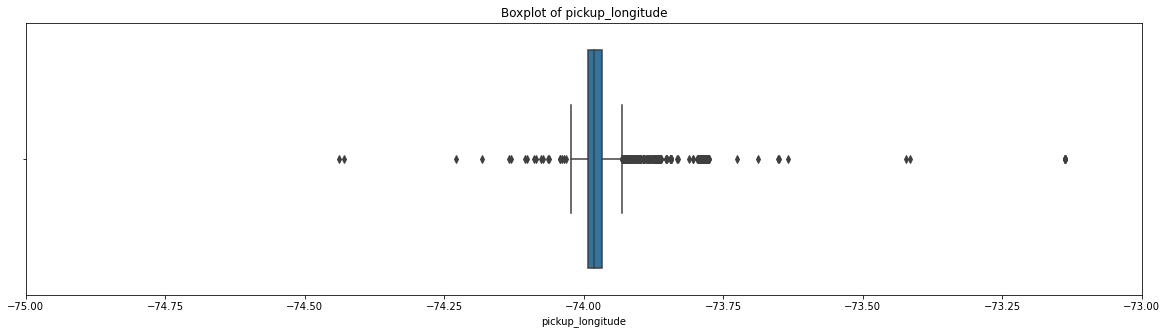

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5)) 
plt.xlim(-75,-73)
sns.boxplot(x=df_1['pickup_longitude'],data=df_1,orient='h')
plt.title('Boxplot of pickup_longitude')
plt.show()

In [135]:
q75,q25=np.percentile(df_1.loc[:,"pickup_longitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -74.02885038125 max: -73.93157377125


In [136]:
df_1[(df_1['pickup_longitude']>max) | (df_1['pickup_longitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,4.50
27,2009-01-09 16:10:00+00:00,-73.873027,40.773883,-73.984545,40.769545,3,31.90
78,2011-08-31 08:21:47+00:00,-73.917399,40.746485,-73.973756,40.763836,1,12.50
96,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,52.00
108,2012-05-11 15:03:53+00:00,-73.872862,40.774105,-73.970593,40.764393,2,32.50
...,...,...,...,...,...,...,...
15495,2009-12-20 14:13:00+00:00,-73.791823,40.645207,-73.952637,40.767205,1,49.57
15497,2012-04-26 17:05:54+00:00,-73.783577,40.648660,-73.978550,40.762548,1,49.80
15505,2009-08-25 21:53:00+00:00,-73.876153,40.772007,-73.981828,40.781113,1,25.30
15535,2010-05-28 02:58:00+00:00,-73.920900,40.756573,-73.815065,40.705340,3,30.50


In [137]:
index=df_1[(df_1['pickup_longitude']>max) | (df_1['pickup_longitude']<min)].index
index

Int64Index([    0,    27,    78,    96,   108,   113,   152,   176,   180,
              185,
            ...
            15408, 15422, 15427, 15433, 15488, 15495, 15497, 15505, 15535,
            15544],
           dtype='int64', length=804)

In [138]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (15586, 7) 

Shape of dataset after dropping: (14782, 7)


### 3.1.2 case 2

In [139]:
df_2['pickup_longitude'].describe()

count    15586.000000
mean       -73.911174
std          2.665436
min        -74.438233
25%        -73.992372
50%        -73.982042
75%        -73.968052
max         40.766125
Name: pickup_longitude, dtype: float64

In [140]:
df_2[(df_2['pickup_longitude']>-73.137)].sort_values('pickup_longitude',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6468,2013-05-22 15:33:00+00:00,40.766125,-73.983285,40.757417,-73.977962,2,13.0
9228,2013-07-13 12:31:00+00:00,40.764420,-73.992947,40.802437,-73.950730,1,15.5
7267,2013-05-22 10:54:00+00:00,40.760495,-73.973047,40.740367,-73.994392,1,13.0
2026,2013-05-24 14:54:00+00:00,40.751582,-73.986968,40.758867,-73.978353,2,5.0
4592,2013-05-22 06:28:00+00:00,40.748262,-73.991840,40.740372,-73.979010,1,6.5
9757,2013-05-22 20:15:00+00:00,40.736875,-74.006210,40.736887,-74.006377,6,52.0
8156,2013-05-24 00:32:00+00:00,40.729127,-74.006893,40.763367,-73.961550,1,15.0
3661,2013-06-20 04:28:00+00:00,40.719830,-73.988467,40.723305,-73.939430,1,11.0
1097,2012-10-11 00:21:00+00:00,-0.004093,0.033500,0.016852,0.017980,2,25.0


#### By seeing the observation , pickup_longitude >-73.137 is set as outlier

In [141]:
index=df_2[(df_2['pickup_longitude']>-73.137)].index
index

Int64Index([1097, 2026, 3661, 4592, 6468, 7267, 8156, 9228, 9757], dtype='int64')

In [142]:
df_2=drop(df_2,index,0)

Shape of dataset before dropping: (15586, 7) 

Shape of dataset after dropping: (15577, 7)


### 3.1.3 case 3

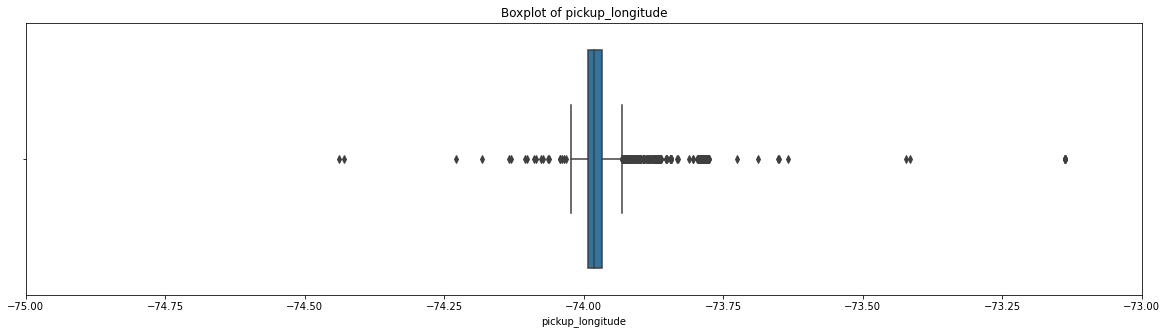

In [143]:
plt.figure(figsize=(20,5)) 
plt.xlim(-75,-73)
sns.boxplot(x=df_3['pickup_longitude'],data=df_3,orient='h')
plt.title('Boxplot of pickup_longitude')
plt.show()

In [144]:
q75,q25=np.percentile(df_3.loc[:,"pickup_longitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -74.02885237500001 max: -73.931615375


In [145]:
df_3[(df_3['pickup_longitude']>max) | (df_3['pickup_longitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,4.50
28,2009-01-09 16:10:00+00:00,-73.873027,40.773883,-73.984545,40.769545,3,31.90
81,2011-08-31 08:21:47+00:00,-73.917399,40.746485,-73.973756,40.763836,1,12.50
100,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,52.00
113,2012-05-11 15:03:53+00:00,-73.872862,40.774105,-73.970593,40.764393,2,32.50
...,...,...,...,...,...,...,...
15624,2009-12-20 14:13:00+00:00,-73.791823,40.645207,-73.952637,40.767205,1,49.57
15626,2012-04-26 17:05:54+00:00,-73.783577,40.648660,-73.978550,40.762548,1,49.80
15634,2009-08-25 21:53:00+00:00,-73.876153,40.772007,-73.981828,40.781113,1,25.30
15664,2010-05-28 02:58:00+00:00,-73.920900,40.756573,-73.815065,40.705340,3,30.50


In [146]:
df_3.loc[(df_3['pickup_longitude']>max) | (df_3['pickup_longitude']<min),'pickup_longitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

### 3.1.4 case 4

In [147]:
df_4['pickup_longitude'].describe()

count    15716.000000
mean       -73.911723
std          2.654397
min        -74.438233
25%        -73.992389
50%        -73.982050
75%        -73.968079
max         40.766125
Name: pickup_longitude, dtype: float64

In [148]:
df_4[(df_4['pickup_longitude']>-73.137)].sort_values('pickup_longitude',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6550,2013-05-22 15:33:00+00:00,40.766125,-73.983285,40.757417,-73.977962,2,13.0
9339,2013-07-13 12:31:00+00:00,40.764420,-73.992947,40.802437,-73.950730,1,15.5
7353,2013-05-22 10:54:00+00:00,40.760495,-73.973047,40.740367,-73.994392,1,13.0
2084,2013-05-24 14:54:00+00:00,40.751582,-73.986968,40.758867,-73.978353,2,5.0
4663,2013-05-22 06:28:00+00:00,40.748262,-73.991840,40.740372,-73.979010,1,6.5
9869,2013-05-22 20:15:00+00:00,40.736875,-74.006210,40.736887,-74.006377,6,52.0
8255,2013-05-24 00:32:00+00:00,40.729127,-74.006893,40.763367,-73.961550,1,15.0
3728,2013-06-20 04:28:00+00:00,40.719830,-73.988467,40.723305,-73.939430,1,11.0
1141,2012-10-11 00:21:00+00:00,-0.004093,0.033500,0.016852,0.017980,2,25.0


#### By seeing the observation , pickup_longitude >-73.137 is set as outlier

In [149]:
df_4.loc[(df_4['pickup_longitude']>-73.137),'pickup_longitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

## 3.2 pickup_latitude

### 3.2.1 case 1

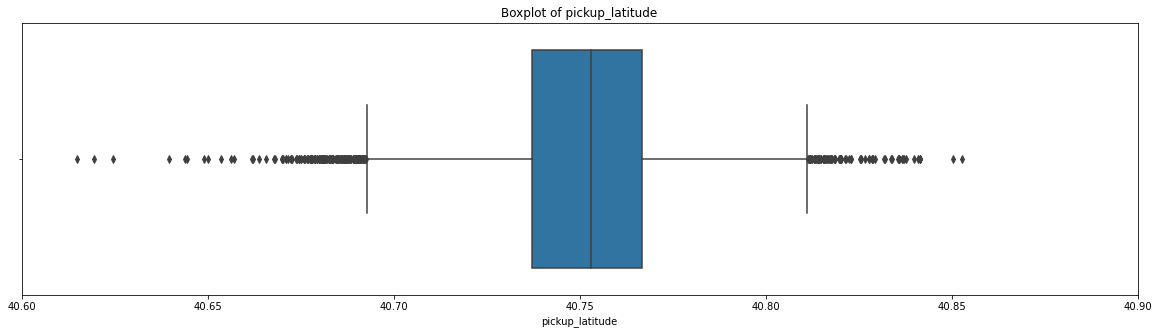

In [150]:
plt.figure(figsize=(20,5)) 
plt.xlim(40.6,40.9)
sns.boxplot(x=df_1['pickup_latitude'],data=df_1,orient='h')
plt.title('Boxplot of pickup_latitude')
plt.show()

In [151]:
q75,q25=np.percentile(df_1.loc[:,"pickup_latitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: 40.69270012499999 max: 40.811133125


In [152]:
df_1[(df_1['pickup_latitude']>max) | (df_1['pickup_latitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
23,2012-05-04 06:11:20+00:00,-73.989258,40.690835,-74.004133,40.725690,1,9.3
74,2014-03-21 11:00:29+00:00,-73.950688,40.828531,-73.964101,40.808140,1,8.0
113,2014-09-12 23:10:00+00:00,-73.983837,40.676052,-74.002522,40.723145,1,16.5
134,2009-07-16 20:33:00+00:00,-73.980755,40.680558,-73.989110,40.726788,2,12.9
279,2009-01-26 00:44:42+00:00,-73.994279,40.690409,-74.016739,40.709063,1,10.6
...,...,...,...,...,...,...,...
14126,2010-05-06 08:57:00+00:00,-73.954058,40.821483,-73.988980,40.756983,1,17.3
14440,2013-08-13 20:32:00+00:00,-73.956427,40.818390,-73.965502,40.800962,1,7.5
14445,2010-05-19 21:48:00+00:00,-73.983860,40.676007,-73.983083,40.672987,1,3.3
14455,2014-03-30 18:05:00+00:00,-73.990385,40.686905,-73.973727,40.682937,1,9.0


In [153]:
index=df_1[(df_1['pickup_latitude']>max) | (df_1['pickup_latitude']<min)].index
index

Int64Index([   23,    74,   113,   134,   279,   307,   440,   499,   613,
              646,
            ...
            13547, 13573, 13734, 13871, 13925, 14126, 14440, 14445, 14455,
            14543],
           dtype='int64', length=260)

In [154]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (14782, 7) 

Shape of dataset after dropping: (14522, 7)


### 3.2.2 case 2

In [155]:
df_2['pickup_latitude'].describe()

count    15577.000000
mean        40.750921
std          0.038021
min         39.603178
25%         40.736588
50%         40.753350
75%         40.767807
max         41.366138
Name: pickup_latitude, dtype: float64

#### By seeing the observation , there is no outlier in pickup_latitude

### 3.2.3 case 3

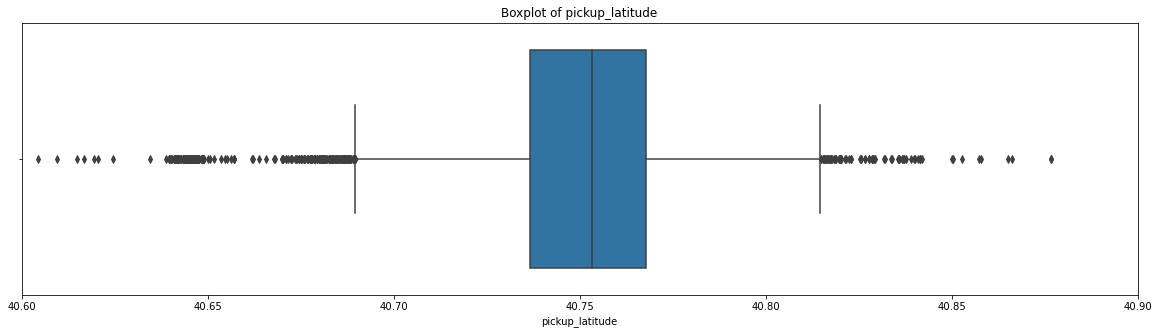

In [156]:
plt.figure(figsize=(20,5)) 
plt.xlim(40.6,40.9)
sns.boxplot(x=df_3['pickup_latitude'],data=df_3,orient='h')
plt.title('Boxplot of pickup_latitude')
plt.show()

In [157]:
q75,q25=np.percentile(df_3.loc[:,"pickup_latitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: 40.689670500000005 max: 40.81467649999999


In [158]:
df_3[(df_3['pickup_latitude']>max) | (df_3['pickup_latitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
79,2014-03-21 11:00:29+00:00,-73.950688,40.828531,-73.964101,40.808140,1,8.00
124,2014-09-12 23:10:00+00:00,-73.983837,40.676052,-74.002522,40.723145,1,16.50
147,2009-07-16 20:33:00+00:00,-73.980755,40.680558,-73.989110,40.726788,2,12.90
240,2010-05-28 21:33:07+00:00,NaN,40.647040,-73.815622,40.680364,1,16.10
274,2013-06-14 17:37:00+00:00,NaN,40.645007,-73.981802,40.762515,1,57.33
...,...,...,...,...,...,...,...
15556,2011-10-24 06:19:00+00:00,NaN,40.644745,-73.975865,40.688232,1,32.90
15562,2011-11-20 12:58:00+00:00,NaN,40.616788,-73.928838,40.616788,2,12.50
15624,2009-12-20 14:13:00+00:00,NaN,40.645207,-73.952637,40.767205,1,49.57
15626,2012-04-26 17:05:54+00:00,NaN,40.648660,-73.978550,40.762548,1,49.80


In [159]:
df_3.loc[(df_3['pickup_latitude']>max) | (df_3['pickup_latitude']<min),'pickup_latitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

### 3.2.4 case 4

In [160]:
df_4['pickup_latitude'].describe()

count    15716.000000
mean        40.689903
std          2.608731
min        -74.006893
25%         40.736548
50%         40.753294
75%         40.767799
max         41.366138
Name: pickup_latitude, dtype: float64

In [161]:
df_4[df_4['pickup_latitude']<39.6].sort_values('pickup_latitude')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
8255,2013-05-24 00:32:00+00:00,NaN,-74.006893,40.763367,-73.961550,1,15.0
9869,2013-05-22 20:15:00+00:00,NaN,-74.006210,40.736887,-74.006377,6,52.0
9339,2013-07-13 12:31:00+00:00,NaN,-73.992947,40.802437,-73.950730,1,15.5
4663,2013-05-22 06:28:00+00:00,NaN,-73.991840,40.740372,-73.979010,1,6.5
3728,2013-06-20 04:28:00+00:00,NaN,-73.988467,40.723305,-73.939430,1,11.0
2084,2013-05-24 14:54:00+00:00,NaN,-73.986968,40.758867,-73.978353,2,5.0
6550,2013-05-22 15:33:00+00:00,NaN,-73.983285,40.757417,-73.977962,2,13.0
7353,2013-05-22 10:54:00+00:00,NaN,-73.973047,40.740367,-73.994392,1,13.0
1141,2012-10-11 00:21:00+00:00,NaN,0.033500,0.016852,0.017980,2,25.0


#### By seeing the observation , pickup_latitude <39.6 is set as outlier

In [162]:
df_4.loc[df_4['pickup_latitude']<39.6,'pickup_latitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

## 3.3 dropoff_longitude

### 3.3.1 case 1

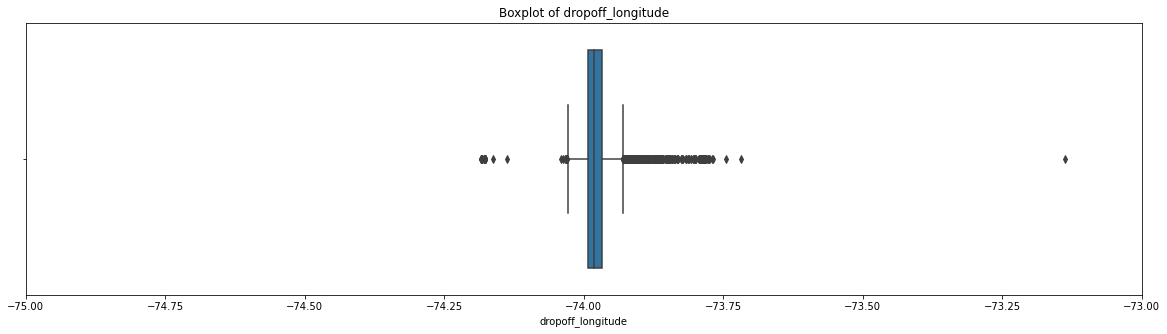

In [163]:
plt.figure(figsize=(20,5)) 
plt.xlim(-75,-73)
sns.boxplot(x=df_1['dropoff_longitude'],data=df_1,orient='h')
plt.title('Boxplot of dropoff_longitude')
plt.show()

In [164]:
q75,q25=np.percentile(df_1.loc[:,"dropoff_longitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -74.02879098749996 max: -73.92959050750004


In [165]:
df_1[(df_1['dropoff_longitude']>max) | (df_1['dropoff_longitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
48,2010-05-31 18:06:00+00:00,-73.985427,40.758853,-73.872907,40.774497,1,34.67
67,2011-08-12 04:20:00+00:00,-74.006662,40.731210,-73.925940,40.825588,1,24.90
111,2009-09-22 21:14:00+00:00,-73.977023,40.752600,-73.790310,40.643783,2,49.57
112,2012-02-12 01:26:00+00:00,-73.988200,40.759090,-73.923683,40.868610,5,22.50
125,2014-05-13 22:19:00+00:00,-73.982265,40.762062,-73.768550,40.675135,1,52.50
...,...,...,...,...,...,...,...
14420,2014-04-14 21:15:33+00:00,-73.984604,40.748209,-73.869463,40.859598,1,38.00
14440,2015-04-05 10:39:11+00:00,-73.978905,40.783115,-73.871956,40.772133,2,33.50
14443,2015-04-15 21:02:56+00:00,-74.004700,40.741741,-73.808159,40.757359,2,47.04
14469,2009-09-13 01:07:20+00:00,-73.975717,40.795568,-73.922822,40.866558,2,16.10


In [166]:
index=df_1[(df_1['dropoff_longitude']>max) | (df_1['dropoff_longitude']<min)].index
index

Int64Index([   48,    67,   111,   112,   125,   151,   186,   198,   219,
              259,
            ...
            14262, 14317, 14344, 14405, 14409, 14420, 14440, 14443, 14469,
            14512],
           dtype='int64', length=663)

In [167]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (14522, 7) 

Shape of dataset after dropping: (13859, 7)


### 3.3.2 case 2

In [168]:
df_2['dropoff_longitude'].describe()

count    15577.000000
mean       -73.960104
std          0.991741
min        -74.429332
25%        -73.991369
50%        -73.980555
75%        -73.965385
max          0.000000
Name: dropoff_longitude, dtype: float64

In [169]:
df_2[(df_2['dropoff_longitude']>-73.137)].sort_values('dropoff_longitude',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2154,2011-08-29 08:24:00+00:00,-73.936667,40.757815,0.00000,40.757815,1,8.9
15269,2012-05-12 17:58:00+00:00,-73.967183,40.772403,0.00000,40.740677,1,10.9
5640,2012-03-04 01:35:00+00:00,-73.995030,40.744945,-7.98664,40.729937,1,8.5


#### By seeing the observation , dropoff_longitude >-73.137 is set as outlier

In [170]:
index=df_2[(df_2['dropoff_longitude']>-73.137)].index
index

Int64Index([2154, 5640, 15269], dtype='int64')

In [171]:
df_2=drop(df_2,index,0)

Shape of dataset before dropping: (15577, 7) 

Shape of dataset after dropping: (15574, 7)


### 3.3.3 case 3

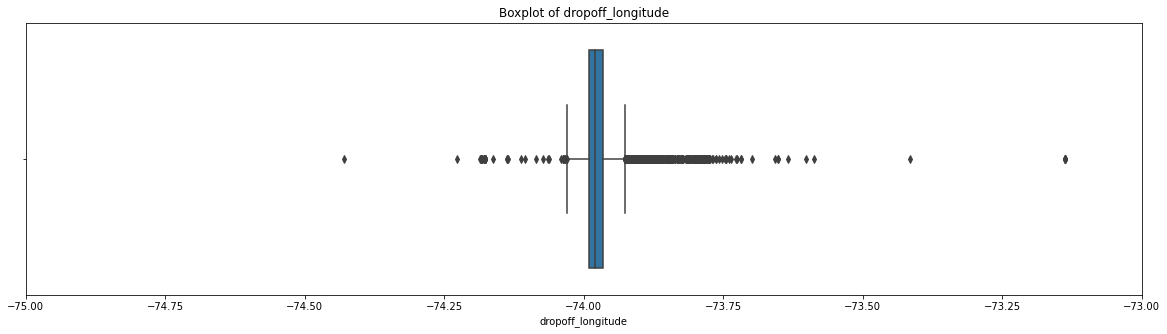

In [172]:
plt.figure(figsize=(20,5)) 
plt.xlim(-75,-73)
sns.boxplot(x=df_3['dropoff_longitude'],data=df_3,orient='h')
plt.title('Boxplot of dropoff_longitude')
plt.show()

In [173]:
q75,q25=np.percentile(df_3.loc[:,"dropoff_longitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -74.03036654749998 max: -73.92637108750002


In [174]:
df_3[(df_3['dropoff_longitude']>max) | (df_3['dropoff_longitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2009-06-15 17:26:21+00:00,NaN,40.721319,-73.841610,40.712278,1,4.50
52,2010-05-31 18:06:00+00:00,-73.985427,40.758853,-73.872907,40.774497,1,34.67
72,2011-08-12 04:20:00+00:00,-74.006662,40.731210,-73.925940,40.825588,1,24.90
100,2009-03-25 00:08:52+00:00,NaN,40.747320,-74.035839,40.747320,1,52.00
118,2012-08-19 19:56:34+00:00,NaN,40.773748,-73.808317,40.700300,1,17.70
...,...,...,...,...,...,...,...
15630,2015-04-05 10:39:11+00:00,-73.978905,40.783115,-73.871956,40.772133,2,33.50
15633,2015-04-15 21:02:56+00:00,-74.004700,40.741741,-73.808159,40.757359,2,47.04
15660,2009-09-13 01:07:20+00:00,-73.975717,40.795568,-73.922822,40.866558,2,16.10
15664,2010-05-28 02:58:00+00:00,NaN,40.756573,-73.815065,40.705340,3,30.50


In [175]:
df_3.loc[(df_3['dropoff_longitude']>max) | (df_3['dropoff_longitude']<min),'dropoff_longitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

### 3.3.4 case 4

In [176]:
df_4['dropoff_longitude'].describe()

count    15716.000000
mean       -73.897143
std          2.831607
min        -74.429332
25%        -73.991368
50%        -73.980563
75%        -73.965369
max         40.802437
Name: dropoff_longitude, dtype: float64

In [177]:
df_4[(df_4['dropoff_longitude']>-73.137)].sort_values('dropoff_longitude',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
9339,2013-07-13 12:31:00+00:00,NaN,NaN,40.802437,-73.950730,1,15.5
8255,2013-05-24 00:32:00+00:00,NaN,NaN,40.763367,-73.961550,1,15.0
2084,2013-05-24 14:54:00+00:00,NaN,NaN,40.758867,-73.978353,2,5.0
6550,2013-05-22 15:33:00+00:00,NaN,NaN,40.757417,-73.977962,2,13.0
4663,2013-05-22 06:28:00+00:00,NaN,NaN,40.740372,-73.979010,1,6.5
7353,2013-05-22 10:54:00+00:00,NaN,NaN,40.740367,-73.994392,1,13.0
9869,2013-05-22 20:15:00+00:00,NaN,NaN,40.736887,-74.006377,6,52.0
3728,2013-06-20 04:28:00+00:00,NaN,NaN,40.723305,-73.939430,1,11.0
1141,2012-10-11 00:21:00+00:00,NaN,NaN,0.016852,0.017980,2,25.0
2216,2011-08-29 08:24:00+00:00,-73.936667,40.757815,0.000000,40.757815,1,8.9


#### By seeing the observation , dropoff_longitude >-73.137 is set as outlier

In [178]:
df_4.loc[(df_4['dropoff_longitude']>-73.137),'dropoff_longitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

## 3.4 dropoff_latitude

### 3.4.1 case 1

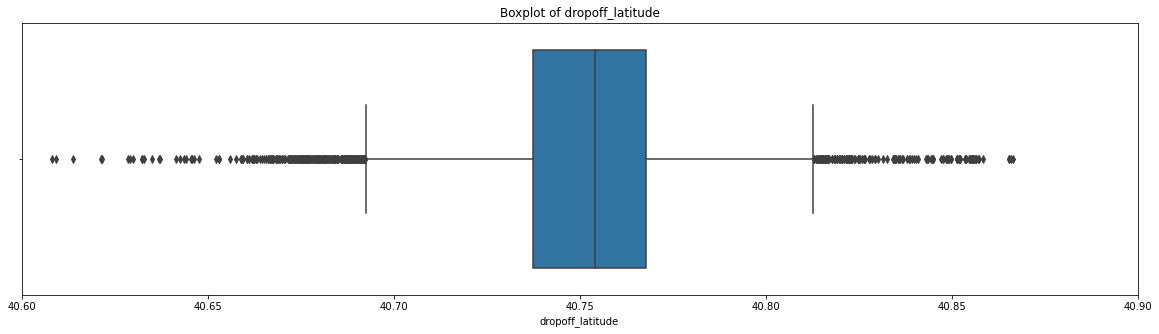

In [179]:
plt.figure(figsize=(20,5)) 
plt.xlim(40.6,40.9)
sns.boxplot(x=df_1['dropoff_latitude'],data=df_1,orient='h')
plt.title('Boxplot of dropoff_latitude')
plt.show()

In [180]:
q75,q25=np.percentile(df_1.loc[:,"dropoff_latitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: 40.69240849500001 max: 40.812931175


In [181]:
df_1[(df_1['dropoff_latitude']>max) | (df_1['dropoff_latitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
26,2011-09-07 23:05:44+00:00,-73.993717,40.740785,-73.999272,40.676617,1,18.1
27,2015-01-11 03:15:38+00:00,-73.983330,40.738720,-73.933197,40.847225,1,58.0
46,2013-11-10 01:12:19+00:00,-73.974497,40.751603,-73.934927,40.851567,4,25.5
98,2010-03-27 02:26:39+00:00,-73.961598,40.716487,-73.960417,40.674963,2,14.5
120,2010-08-24 01:39:26+00:00,-74.003848,40.720855,-73.980980,40.668304,1,12.5
...,...,...,...,...,...,...,...
13736,2010-11-16 22:43:00+00:00,-73.976240,40.761445,-73.963042,40.688533,2,19.3
13766,2013-11-06 21:08:00+00:00,-73.983790,40.741055,-73.984917,40.687787,4,20.0
13768,2014-02-09 14:37:00+00:00,-73.975885,40.787825,-73.950372,40.671797,2,26.5
13781,2009-07-30 21:35:12+00:00,-73.980865,40.760029,-73.994966,40.684292,1,21.3


In [182]:
index=df_1[(df_1['dropoff_latitude']>max) | (df_1['dropoff_latitude']<min)].index
index

Int64Index([   26,    27,    46,    98,   120,   130,   140,   199,   219,
              220,
            ...
            13653, 13685, 13703, 13711, 13715, 13736, 13766, 13768, 13781,
            13794],
           dtype='int64', length=405)

In [183]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (13859, 7) 

Shape of dataset after dropping: (13454, 7)


### 3.4.2 case 2

In [184]:
df_2['dropoff_latitude'].describe()

count    15574.000000
mean        40.748841
std          0.323157
min          0.728087
25%         40.736332
50%         40.754242
75%         40.768332
max         41.366138
Name: dropoff_latitude, dtype: float64

In [185]:
df_2[df_2['dropoff_latitude']<39.6].sort_values('dropoff_latitude')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6761,2011-06-18 04:03:00+00:00,-73.98898,40.721697,-74.001073,0.728087,3,4.5


#### By seeing the observation , dropoff_latitude <39.6 is set as outlier

In [186]:
index=df_2[df_2['dropoff_latitude']<39.6].index
index

Int64Index([6761], dtype='int64')

In [187]:
df_2=drop(df_2,index,0)

Shape of dataset before dropping: (15574, 7) 

Shape of dataset after dropping: (15573, 7)


### 3.4.3 case 3

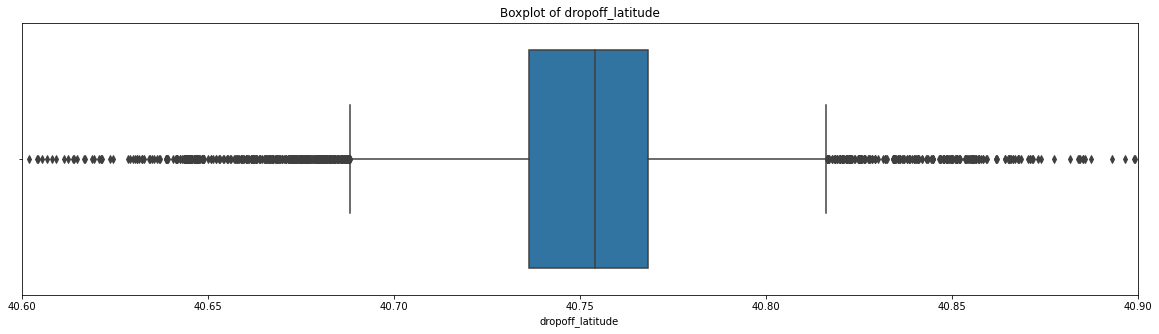

In [188]:
plt.figure(figsize=(20,5)) 
plt.xlim(40.6,40.9)
sns.boxplot(x=df_3['dropoff_latitude'],data=df_3,orient='h')
plt.title('Boxplot of dropoff_latitude')
plt.show()

In [189]:
q75,q25=np.percentile(df_3.loc[:,"dropoff_latitude"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: 40.68826587499998 max: 40.81633287500002


In [190]:
df_3[(df_3['dropoff_latitude']>max) | (df_3['dropoff_latitude']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
27,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,40.660366,1,22.54
30,2011-09-07 23:05:44+00:00,-73.993717,40.740785,-73.999272,40.676617,1,18.10
31,2015-01-11 03:15:38+00:00,-73.983330,40.738720,-73.933197,40.847225,1,58.00
50,2013-11-10 01:12:19+00:00,-73.974497,40.751603,-73.934927,40.851567,4,25.50
72,2011-08-12 04:20:00+00:00,-74.006662,40.731210,NaN,40.825588,1,24.90
...,...,...,...,...,...,...,...
15612,2013-11-06 21:08:00+00:00,-73.983790,40.741055,-73.984917,40.687787,4,20.00
15614,2014-02-09 14:37:00+00:00,-73.975885,40.787825,-73.950372,40.671797,2,26.50
15617,2010-05-11 00:10:42+00:00,NaN,40.770229,-73.932235,40.650819,1,33.30
15631,2009-07-30 21:35:12+00:00,-73.980865,40.760029,-73.994966,40.684292,1,21.30


In [191]:
df_3.loc[(df_3['dropoff_latitude']>max) | (df_3['dropoff_latitude']<min),'dropoff_latitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

### 3.4.4 case 4

In [192]:
df_4['dropoff_latitude'].describe()

count    15716.000000
mean        40.687861
std          2.627792
min        -74.006377
25%         40.736291
50%         40.754220
75%         40.768308
max         41.366138
Name: dropoff_latitude, dtype: float64

In [193]:
df_4[df_4['dropoff_latitude']<39.6].sort_values('dropoff_latitude')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
9869,2013-05-22 20:15:00+00:00,NaN,NaN,NaN,-74.006377,6,52.0
7353,2013-05-22 10:54:00+00:00,NaN,NaN,NaN,-73.994392,1,13.0
4663,2013-05-22 06:28:00+00:00,NaN,NaN,NaN,-73.979010,1,6.5
2084,2013-05-24 14:54:00+00:00,NaN,NaN,NaN,-73.978353,2,5.0
6550,2013-05-22 15:33:00+00:00,NaN,NaN,NaN,-73.977962,2,13.0
8255,2013-05-24 00:32:00+00:00,NaN,NaN,NaN,-73.961550,1,15.0
9339,2013-07-13 12:31:00+00:00,NaN,NaN,NaN,-73.950730,1,15.5
3728,2013-06-20 04:28:00+00:00,NaN,NaN,NaN,-73.939430,1,11.0
1141,2012-10-11 00:21:00+00:00,NaN,NaN,NaN,0.017980,2,25.0
6852,2011-06-18 04:03:00+00:00,-73.98898,40.721697,-74.001073,0.728087,3,4.5


#### By seeing the observation , dropoff_latitude <39.6 is set as outlier

In [194]:
df_4.loc[df_4['dropoff_latitude']<39.6,'dropoff_latitude']=np.nan

#### Missing value imputation will be done at the end of outlier analysis

## 3.5 fare_amount

#### Since fare_amount is the target variable, we will be directly dropping the outliers instead of setting to NaN 

### 3.5.1 case 1

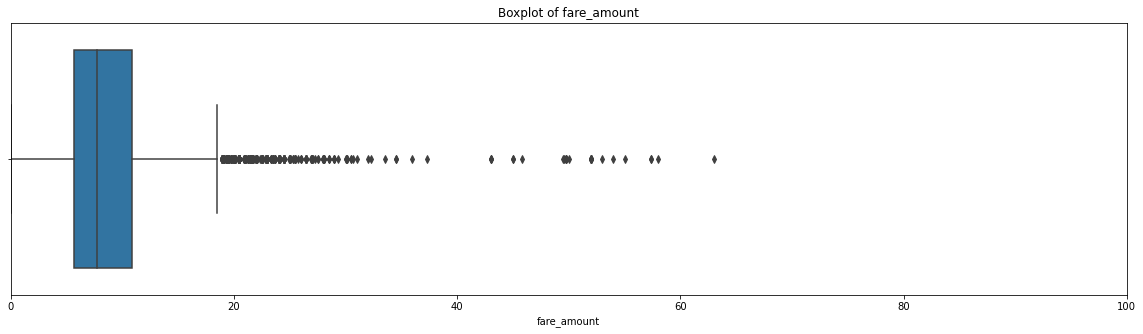

In [195]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=df_1['fare_amount'],data=df_1,orient='h')
plt.title('Boxplot of fare_amount')
plt.show()

In [196]:
q75,q25=np.percentile(df_1.loc[:,"fare_amount"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -2.1000000000000005 max: 18.700000000000003


In [197]:
df_1[(df_1['fare_amount']>max) | (df_1['fare_amount']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
148,2014-07-12 15:22:00+00:00,-74.012780,40.707952,-73.997932,40.760632,6,24.5
152,2013-05-02 07:41:00+00:00,-73.987285,40.718622,-73.959295,40.778482,1,27.0
243,2014-08-21 10:21:17+00:00,-73.974020,40.762828,-73.940839,40.726467,1,19.0
255,2011-12-05 08:38:34+00:00,-73.968619,40.766432,-74.008559,40.704591,1,20.5
261,2010-02-27 20:13:00+00:00,-73.977765,40.766177,-73.977982,40.766937,5,26.5
...,...,...,...,...,...,...,...
13306,2014-03-17 12:12:00+00:00,-74.013310,40.708689,-73.980225,40.761226,1,22.0
13339,2013-05-10 01:30:41+00:00,-74.006340,40.733718,-73.959535,40.730950,2,23.0
13340,2009-01-06 09:29:00+00:00,-74.015903,40.711410,-73.954777,40.765363,1,19.3
13342,2015-05-07 18:44:17+00:00,-74.008736,40.712700,-73.977959,40.766418,1,24.0


In [198]:
index=df_1[(df_1['fare_amount']>max) | (df_1['fare_amount']<min)].index
index

Int64Index([  148,   152,   243,   255,   261,   267,   273,   294,   319,
              330,
            ...
            13237, 13238, 13264, 13273, 13302, 13306, 13339, 13340, 13342,
            13448],
           dtype='int64', length=519)

In [199]:
df_1=drop(df_1,index,0)

Shape of dataset before dropping: (13454, 7) 

Shape of dataset after dropping: (12935, 7)


### 3.5.2 case 2

In [200]:
df_2['fare_amount'].describe()

count    15573.000000
mean        15.159538
std        436.903326
min          0.010000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

In [201]:
df_2[df_2['fare_amount']>180].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
935,2015-02-27 17:03:50+00:00,-74.003319,40.727455,-73.964470,40.764378,1,54343.0
991,2012-01-15 20:42:04+00:00,-73.976309,40.751634,-74.014854,40.709044,1,4343.0
555,2011-03-03 07:40:59+00:00,-74.007816,40.733536,-73.986556,40.740040,1,453.0
901,2011-10-24 22:54:00+00:00,-73.990602,40.761100,-73.960025,40.779580,2,434.0
1041,2009-09-22 19:01:01+00:00,-73.979610,40.771326,-73.975764,40.781965,1,430.0


#### By seeing the observation , fare_amount >180 is set as outlier

In [202]:
index=df_2[df_2['fare_amount']>180].index
index

Int64Index([555, 901, 935, 991, 1041], dtype='int64')

In [203]:
df_2=drop(df_2,index,0)

Shape of dataset before dropping: (15573, 7) 

Shape of dataset after dropping: (15568, 7)


### 3.5.3 case 3

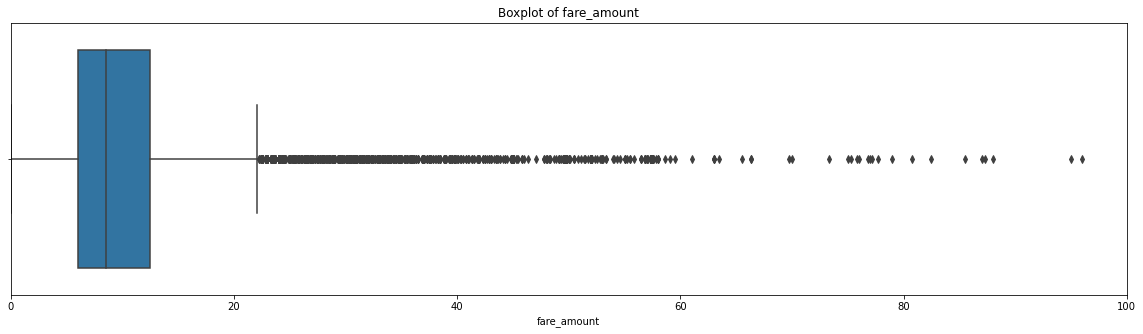

In [204]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=df_3['fare_amount'],data=df_3,orient='h')
plt.title('Boxplot of fare_amount')
plt.show()

In [205]:
q75,q25=np.percentile(df_3.loc[:,"fare_amount"],[75,25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)
print("min:",min,"max:",max)

min: -3.75 max: 22.25


In [206]:
df_3[(df_3['fare_amount']>max) | (df_3['fare_amount']<min)]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
27,2015-06-21 21:46:34+00:00,-74.010483,40.717667,-73.985771,NaN,1,22.54
28,2009-01-09 16:10:00+00:00,NaN,40.773883,-73.984545,40.769545,3,31.90
31,2015-01-11 03:15:38+00:00,-73.983330,40.738720,-73.933197,NaN,1,58.00
50,2013-11-10 01:12:19+00:00,-73.974497,40.751603,-73.934927,NaN,4,25.50
52,2010-05-31 18:06:00+00:00,-73.985427,40.758853,NaN,40.774497,1,34.67
...,...,...,...,...,...,...,...
15633,2015-04-15 21:02:56+00:00,-74.004700,40.741741,NaN,40.757359,2,47.04
15634,2009-08-25 21:53:00+00:00,NaN,40.772007,-73.981828,40.781113,1,25.30
15664,2010-05-28 02:58:00+00:00,NaN,40.756573,NaN,40.705340,3,30.50
15673,2013-09-10 19:03:00+00:00,NaN,NaN,-73.982160,40.761590,2,57.33


In [207]:
index=df_3[(df_3['fare_amount']>max) | (df_3['fare_amount']<min)].index
index

Int64Index([   27,    28,    31,    50,    52,    72,   100,   107,   113,
              125,
            ...
            15614, 15617, 15624, 15626, 15630, 15633, 15634, 15664, 15673,
            15705],
           dtype='int64', length=1362)

In [208]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (15716, 7) 

Shape of dataset after dropping: (14354, 7)


### 3.5.4 case 4

In [209]:
df_4['fare_amount'].describe()

count    15716.000000
mean        15.113220
std        434.911842
min          0.010000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

In [210]:
df_4[df_4['fare_amount']>180].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
975,2015-02-27 17:03:50+00:00,-74.003319,40.727455,-73.964470,40.764378,1,54343.0
1032,2012-01-15 20:42:04+00:00,-73.976309,40.751634,-74.014854,40.709044,1,4343.0
583,2011-03-03 07:40:59+00:00,-74.007816,40.733536,-73.986556,40.740040,1,453.0
940,2011-10-24 22:54:00+00:00,-73.990602,40.761100,-73.960025,40.779580,2,434.0
1083,2009-09-22 19:01:01+00:00,-73.979610,40.771326,-73.975764,40.781965,1,430.0


#### By seeing the observation , fare_amount >180 is set as outlier

In [211]:
index=df_4[df_4['fare_amount']>180].index
index

Int64Index([583, 940, 975, 1032, 1083], dtype='int64')

In [212]:
df_4=drop(df_4,index,0)

Shape of dataset before dropping: (15716, 7) 

Shape of dataset after dropping: (15711, 7)


## 3.6 Imputation of missing values of outliers

### 3.6.1 case 3

#### Checking whether pickup_longitude and pickup_latitude = NaN or dropoff_longitude and dropoff_latitude = NaN
#### If found drop them

In [213]:
df_3[(df_3['pickup_longitude'].isna() & df_3['pickup_latitude'].isna()) | (df_3['dropoff_longitude'].isna() & df_3['dropoff_latitude'].isna())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
220,2010-05-28 21:33:07+00:00,NaN,NaN,NaN,NaN,1,16.1
531,2013-10-05 20:24:51+00:00,NaN,NaN,NaN,NaN,1,16.0
582,2013-04-12 19:57:22+00:00,NaN,NaN,-73.996509,40.737216,1,5.5
635,2010-06-15 01:06:00+00:00,NaN,NaN,NaN,NaN,1,8.9
914,2011-03-24 22:20:12+00:00,-73.940342,40.800480,NaN,NaN,1,14.9
...,...,...,...,...,...,...,...
13893,2010-08-09 06:07:10+00:00,NaN,NaN,-74.006270,40.708667,1,13.7
14040,2009-10-03 18:06:46+00:00,NaN,NaN,NaN,40.712621,1,19.3
14158,2013-04-05 20:40:00+00:00,-73.991130,40.700835,NaN,NaN,2,20.5
14214,2011-11-20 12:58:00+00:00,NaN,NaN,-73.928838,NaN,2,12.5


In [214]:
index=df_3[(df_3['pickup_longitude'].isna() & df_3['pickup_latitude'].isna()) | (df_3['dropoff_longitude'].isna() & df_3['dropoff_latitude'].isna())].index
index

Int64Index([  220,   531,   582,   635,   914,   975,   993,  1351,  1452,
             1472,
            ...
            13186, 13610, 13631, 13776, 13841, 13893, 14040, 14158, 14214,
            14301],
           dtype='int64', length=110)

In [215]:
df_3=drop(df_3,index,0)

Shape of dataset before dropping: (14354, 7) 

Shape of dataset after dropping: (14244, 7)


In [216]:
pd.DataFrame(pd.concat([df_3.isnull().sum(),df_3.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
dropoff_latitude,303,2.127211
dropoff_longitude,268,1.881494
pickup_longitude,205,1.439202
pickup_latitude,175,1.228587
pickup_datetime,0,0.000000
passenger_count,0,0.000000
fare_amount,0,0.000000


#### Here we are using KNN imputation for missing value imputation

In [217]:
df_3_testing=pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df_3.iloc[:,1:]),columns=df_3.columns[1:])

In [218]:
df_3=pd.concat([df_3.iloc[:,0],df_3_testing],axis=1)

In [219]:
df_3['passenger_count']=pd.to_numeric(df_3['passenger_count']).astype('int64')

In [220]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14244 entries, 0 to 14243
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    14244 non-null  datetime64[ns, UTC]
 1   pickup_longitude   14244 non-null  float64            
 2   pickup_latitude    14244 non-null  float64            
 3   dropoff_longitude  14244 non-null  float64            
 4   dropoff_latitude   14244 non-null  float64            
 5   passenger_count    14244 non-null  int64              
 6   fare_amount        14244 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 779.1 KB


In [221]:
df_3.isna().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

### 3.6.2 case 4

#### Checking whether pickup_longitude and pickup_latitude = NaN or dropoff_longitude and dropoff_latitude = NaN
#### If found drop them

In [222]:
df_4[(df_4['pickup_longitude'].isna() & df_4['pickup_latitude'].isna()) | (df_4['dropoff_longitude'].isna() & df_4['dropoff_latitude'].isna())]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
1136,2012-10-11 00:21:00+00:00,NaN,NaN,NaN,NaN,2,25.0
2079,2013-05-24 14:54:00+00:00,NaN,NaN,NaN,NaN,2,5.0
3723,2013-06-20 04:28:00+00:00,NaN,NaN,NaN,NaN,1,11.0
4658,2013-05-22 06:28:00+00:00,NaN,NaN,NaN,NaN,1,6.5
6545,2013-05-22 15:33:00+00:00,NaN,NaN,NaN,NaN,2,13.0
7348,2013-05-22 10:54:00+00:00,NaN,NaN,NaN,NaN,1,13.0
8250,2013-05-24 00:32:00+00:00,NaN,NaN,NaN,NaN,1,15.0
9334,2013-07-13 12:31:00+00:00,NaN,NaN,NaN,NaN,1,15.5
9864,2013-05-22 20:15:00+00:00,NaN,NaN,NaN,NaN,6,52.0


In [223]:
index=df_4[(df_4['pickup_longitude'].isna() & df_4['pickup_latitude'].isna()) | (df_4['dropoff_longitude'].isna() & df_4['dropoff_latitude'].isna())].index
index

Int64Index([1136, 2079, 3723, 4658, 6545, 7348, 8250, 9334, 9864], dtype='int64')

In [224]:
df_4=drop(df_4,index,0)

Shape of dataset before dropping: (15711, 7) 

Shape of dataset after dropping: (15702, 7)


In [225]:
pd.DataFrame(pd.concat([df_4.isnull().sum(),df_4.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
dropoff_longitude,3,0.019106
dropoff_latitude,1,0.006369
pickup_datetime,0,0.000000
pickup_longitude,0,0.000000
pickup_latitude,0,0.000000
passenger_count,0,0.000000
fare_amount,0,0.000000


#### Here we are using KNN imputation for missing value imputation

In [226]:
df_4_testing=pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df_4.iloc[:,1:]),columns=df_4.columns[1:])

In [227]:
df_4=pd.concat([df_4.iloc[:,0],df_4_testing],axis=1)

In [228]:
df_4['passenger_count']=pd.to_numeric(df_4['passenger_count']).astype('int64')

In [229]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15702 non-null  datetime64[ns, UTC]
 1   pickup_longitude   15702 non-null  float64            
 2   pickup_latitude    15702 non-null  float64            
 3   dropoff_longitude  15702 non-null  float64            
 4   dropoff_latitude   15702 non-null  float64            
 5   passenger_count    15702 non-null  int64              
 6   fare_amount        15702 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 858.8 KB


In [230]:
df_4.isna().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

# 4.Feature Extraction

## 4.1 Using pickup_longitude, pickup_latitude, dropoff_longitude and dropoff_latitude

In [231]:
!pip install vincenty

In [232]:
from vincenty import vincenty

In [233]:
#creating a function dist to calculate the distance
def dist(df):
    dist=[]
    for i in range(len(df)):
        pickup_latitude=df.loc[i,'pickup_latitude']
        pickup_longitude=df.loc[i,'pickup_longitude']
        dropoff_latitude=df.loc[i,'dropoff_latitude']
        dropoff_longitude=df.loc[i,'dropoff_longitude']
        pickup_place = (pickup_latitude,pickup_longitude)
        dropoff_place = (dropoff_latitude,dropoff_longitude)
        dist.append(vincenty(pickup_place, dropoff_place))
    return dist

In [234]:
df_1['distance']=dist(df_1)
df_2['distance']=dist(df_2)
df_3['distance']=dist(df_3)
df_4['distance']=dist(df_4)
test['distance']=dist(test)
valid['distance']=dist(valid)

In [235]:
df_1['distance'].describe()

count    12935.000000
mean         2.246305
std          1.478465
min          0.000000
25%          1.165144
50%          1.876459
75%          2.970621
max          9.910799
Name: distance, dtype: float64

In [236]:
df_2['distance'].describe()

count    15568.000000
mean         3.409912
std          4.590243
min          0.000000
25%          1.257965
50%          2.170056
75%          3.898851
max        129.767395
Name: distance, dtype: float64

In [237]:
df_3['distance'].describe()

count    14244.000000
mean         2.384545
std          1.637553
min          0.000000
25%          1.193217
50%          1.945168
75%          3.164825
max         11.409653
Name: distance, dtype: float64

In [238]:
df_4['distance'].describe()

count    15702.000000
mean         3.405270
std          4.578931
min          0.000000
25%          1.257765
50%          2.169765
75%          3.896224
max        129.767395
Name: distance, dtype: float64

In [239]:
test['distance'].describe()

count    9914.000000
mean        3.436325
std         3.975529
min         0.000000
25%         1.299268
50%         2.218088
75%         4.045368
max       100.063275
Name: distance, dtype: float64

In [240]:
valid['distance'].describe()

count    15551.000000
mean         3.373013
std          4.119983
min          0.000000
25%          1.258036
50%          2.170023
75%          3.896387
max        101.166020
Name: distance, dtype: float64

In [241]:
df_1[df_1['distance']==0].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,distance
7414,2012-04-16 23:58:00+00:00,-73.972258,40.781455,-73.972258,40.781455,1,17.3,0.0
12694,2012-12-21 20:35:18+00:00,-74.003743,40.756404,-74.003743,40.756404,1,17.0,0.0
10348,2009-04-07 23:35:00+00:00,-73.986127,40.717632,-73.986127,40.717632,5,16.9,0.0
4964,2010-09-19 19:42:12+00:00,-73.968646,40.801638,-73.968646,40.801638,3,15.3,0.0
8067,2011-04-12 13:57:00+00:00,-73.994422,40.720175,-73.994422,40.720175,1,13.7,0.0
...,...,...,...,...,...,...,...,...
1087,2013-07-21 00:10:23+00:00,-73.956556,40.779828,-73.956556,40.779828,1,2.5,0.0
5325,2010-07-28 17:37:49+00:00,-74.001027,40.727612,-74.001027,40.727612,1,2.5,0.0
8618,2013-09-13 16:14:28+00:00,-73.950813,40.771671,-73.950813,40.771671,1,2.5,0.0
501,2009-08-25 01:50:21+00:00,-73.986410,40.763350,-73.986410,40.763350,1,2.5,0.0


In [242]:
df_2[df_2['distance']==0].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,distance
1239,2013-01-16 20:19:58+00:00,-74.429332,40.500046,-74.429332,40.500046,1,180.00,0.0
12508,2011-09-07 01:14:49+00:00,-73.652179,40.801690,-73.652179,40.801690,1,96.00,0.0
10159,2010-05-04 14:12:00+00:00,-74.181602,40.687722,-74.181602,40.687722,1,75.80,0.0
2214,2009-02-07 00:14:00+00:00,-74.086412,40.841982,-74.086412,40.841982,1,63.00,0.0
675,2014-08-11 19:37:00+00:00,-73.776477,40.646290,-73.776477,40.646290,2,57.33,0.0
...,...,...,...,...,...,...,...,...
13133,2009-03-09 12:26:25+00:00,-73.416169,40.784140,-73.416169,40.784140,1,2.50,0.0
1319,2013-07-21 00:10:23+00:00,-73.956556,40.779828,-73.956556,40.779828,1,2.50,0.0
7141,2011-01-18 16:07:22+00:00,-73.960443,40.761375,-73.960443,40.761375,1,2.50,0.0
6385,2010-07-28 17:37:49+00:00,-74.001027,40.727612,-74.001027,40.727612,1,2.50,0.0


In [243]:
df_3[df_3['distance']==0].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,distance
8142,2012-04-16 23:58:00+00:00,-73.972258,40.781455,-73.972258,40.781455,1,17.3,0.0
13986,2012-12-21 20:35:18+00:00,-74.003743,40.756404,-74.003743,40.756404,1,17.0,0.0
11406,2009-04-07 23:35:00+00:00,-73.986127,40.717632,-73.986127,40.717632,5,16.9,0.0
5474,2010-09-19 19:42:12+00:00,-73.968646,40.801638,-73.968646,40.801638,3,15.3,0.0
8872,2011-04-12 13:57:00+00:00,-73.994422,40.720175,-73.994422,40.720175,1,13.7,0.0
...,...,...,...,...,...,...,...,...
1230,2013-07-21 00:10:23+00:00,-73.956556,40.779828,-73.956556,40.779828,1,2.5,0.0
5865,2010-07-28 17:37:49+00:00,-74.001027,40.727612,-74.001027,40.727612,1,2.5,0.0
9481,2013-09-13 16:14:28+00:00,-73.950813,40.771671,-73.950813,40.771671,1,2.5,0.0
566,2009-08-25 01:50:21+00:00,-73.986410,40.763350,-73.986410,40.763350,1,2.5,0.0


In [244]:
df_4[df_4['distance']==0].sort_values('fare_amount',ascending=False)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,distance
1285,2013-01-16 20:19:58+00:00,-74.429332,40.500046,-74.429332,40.500046,1,180.00,0.0
12630,2011-09-07 01:14:49+00:00,-73.652179,40.801690,-73.652179,40.801690,1,96.00,0.0
10274,2010-05-04 14:12:00+00:00,-74.181602,40.687722,-74.181602,40.687722,1,75.80,0.0
2275,2009-02-07 00:14:00+00:00,-74.086412,40.841982,-74.086412,40.841982,1,63.00,0.0
708,2014-08-11 19:37:00+00:00,-73.776477,40.646290,-73.776477,40.646290,2,57.33,0.0
...,...,...,...,...,...,...,...,...
9546,2013-03-29 18:45:53+00:00,-73.874439,40.773819,-73.874439,40.773819,1,2.50,0.0
1713,2012-08-27 15:24:00+00:00,-73.950282,40.701282,-73.950282,40.701282,1,2.50,0.0
8702,2011-09-13 18:45:31+00:00,-73.783300,40.648600,-73.783300,40.648600,1,2.50,0.0
8960,2010-12-06 11:48:34+00:00,-73.946993,40.744583,-73.946993,40.744583,3,2.50,0.0


#### Since min value of distance=0 for test.csv dataset, we are not removing or setting to NaN for those observations in our train dataset.

### Assuming that there is no round trip, no waiting charge, no cancellation fee(if using an app)
### Implies fare_amount should be zero for distance equals to zero

In [246]:
df_1.loc[df_1['distance']==0,'fare_amount']=0
df_2.loc[df_2['distance']==0,'fare_amount']=0
df_3.loc[df_3['distance']==0,'fare_amount']=0
df_4.loc[df_4['distance']==0,'fare_amount']=0
valid.loc[valid['distance']==0,'fare_amount']=0

## 4.2 Using pickup_datetime

In [247]:
a=pd.DataFrame()
a["pickup_year"] = test["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = test["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = test["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = test["pickup_datetime"].apply(lambda row: row.hour)
test=pd.concat([a,test.iloc[:,5:7]],axis=1)
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,2015,1,1,13,1,2.320991
1,2015,1,1,13,1,2.423802
2,2011,10,5,11,1,0.618182
3,2012,12,5,21,1,1.959671
4,2012,12,5,21,1,5.382833


In [248]:
test['pickup_year'].value_counts()

2011    2050
2014    1902
2010    1753
2012    1433
2013    1135
2009    1022
2015     619
Name: pickup_year, dtype: int64

In [249]:
year={2009:0,2010:1,2011:2,2012:3,2013:4,2014:5,2015:6}
test["pickup_year"] = test["pickup_year"].map(year)
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,6,1,1,13,1,2.320991
1,6,1,1,13,1,2.423802
2,2,10,5,11,1,0.618182
3,3,12,5,21,1,1.959671
4,3,12,5,21,1,5.382833


In [250]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         9914 non-null   int64  
 1   pickup_month        9914 non-null   int64  
 2   pickup_day_of_week  9914 non-null   int64  
 3   pickup_hour         9914 non-null   int64  
 4   passenger_count     9914 non-null   int64  
 5   distance            9914 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 464.8 KB


In [251]:
a=pd.DataFrame()
a["pickup_year"] = valid["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = valid["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = valid["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = valid["pickup_datetime"].apply(lambda row: row.hour)
valid=pd.concat([a,valid.iloc[:,[5,7,6]]],axis=1)
valid["pickup_year"] = valid["pickup_year"].map(year)
valid.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


In [252]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15551 entries, 0 to 15550
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         15551 non-null  int64  
 1   pickup_month        15551 non-null  int64  
 2   pickup_day_of_week  15551 non-null  int64  
 3   pickup_hour         15551 non-null  int64  
 4   passenger_count     15551 non-null  int64  
 5   distance            15551 non-null  float64
 6   fare_amount         15551 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 850.6 KB


In [253]:
valid.describe()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
count,15551.000000,15551.000000,15551.000000,15551.000000,15551.000000,15551.000000,15551.000000
mean,2.734615,6.270658,3.033696,13.499839,1.650376,3.373013,11.182602
std,1.869741,3.447706,1.970104,6.507990,1.265828,4.119983,9.389796
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,1.000000,9.000000,1.000000,1.258036,6.000000
50%,3.000000,6.000000,3.000000,14.000000,1.000000,2.170023,8.500000
75%,4.000000,9.000000,5.000000,19.000000,2.000000,3.896387,12.500000
max,6.000000,12.000000,6.000000,23.000000,6.000000,101.166020,108.000000


In [254]:
test.describe()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,2.815816,6.857979,2.852834,13.467420,1.671273,3.436325
std,1.803347,3.353272,1.994451,6.868584,1.278747,3.975529
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,4.000000,1.000000,8.000000,1.000000,1.299268
50%,3.000000,7.000000,3.000000,15.000000,1.000000,2.218088
75%,5.000000,10.000000,5.000000,19.000000,2.000000,4.045368
max,6.000000,12.000000,6.000000,23.000000,6.000000,100.063275


### 4.2.1 case 1

In [255]:
a=pd.DataFrame()
a["pickup_year"] = df_1["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = df_1["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = df_1["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = df_1["pickup_datetime"].apply(lambda row: row.hour)
df_1=pd.concat([a,df_1.iloc[:,[5,7,6]]],axis=1)
df_1["pickup_year"] = df_1["pickup_year"].map(year)
df_1.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,1,1,1,16,1,8.443441,16.9
1,2,8,3,0,2,1.389132,5.7
2,3,4,5,4,1,2.795790,7.7
3,1,3,1,7,1,1.998338,5.3
4,2,1,3,9,1,3.787980,12.1


In [256]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12935 entries, 0 to 12934
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         12935 non-null  int64  
 1   pickup_month        12935 non-null  int64  
 2   pickup_day_of_week  12935 non-null  int64  
 3   pickup_hour         12935 non-null  int64  
 4   passenger_count     12935 non-null  int64  
 5   distance            12935 non-null  float64
 6   fare_amount         12935 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 707.5 KB


In [257]:
df_1.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,1,1,1,16,1,8.443441,16.9
1,2,8,3,0,2,1.389132,5.7
2,3,4,5,4,1,2.795790,7.7
3,1,3,1,7,1,1.998338,5.3
4,2,1,3,9,1,3.787980,12.1


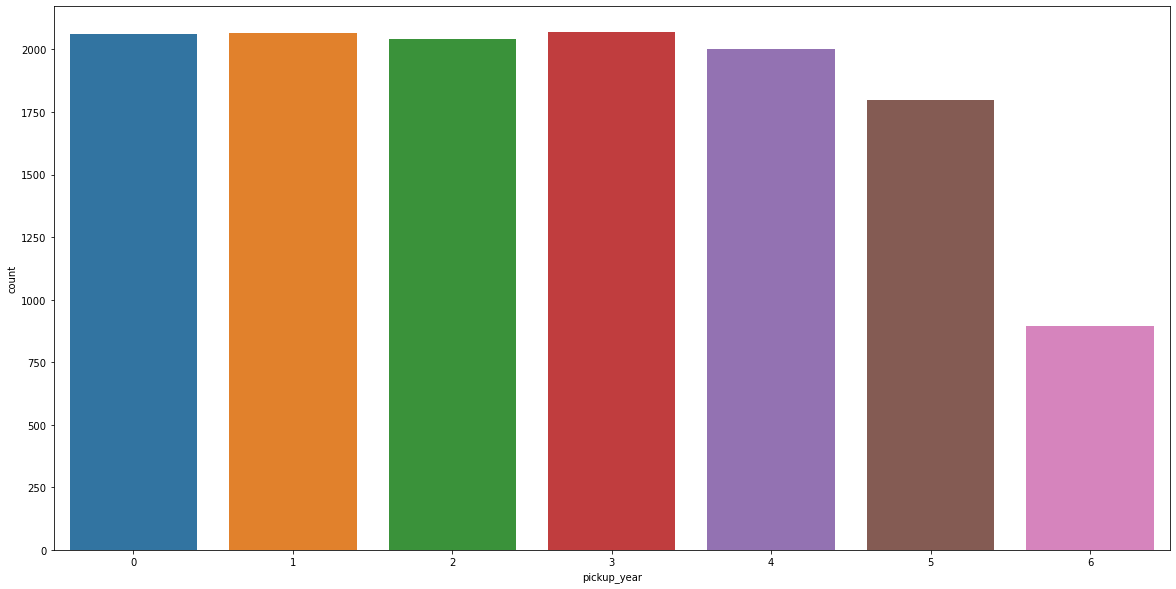

In [258]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['pickup_year'])

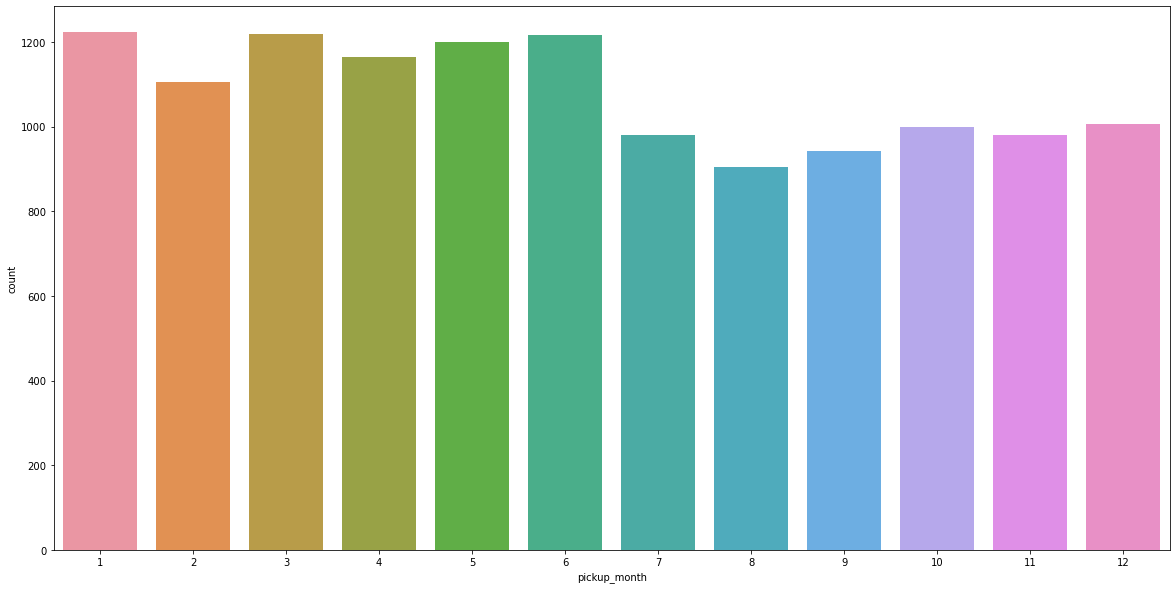

In [259]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['pickup_month'])

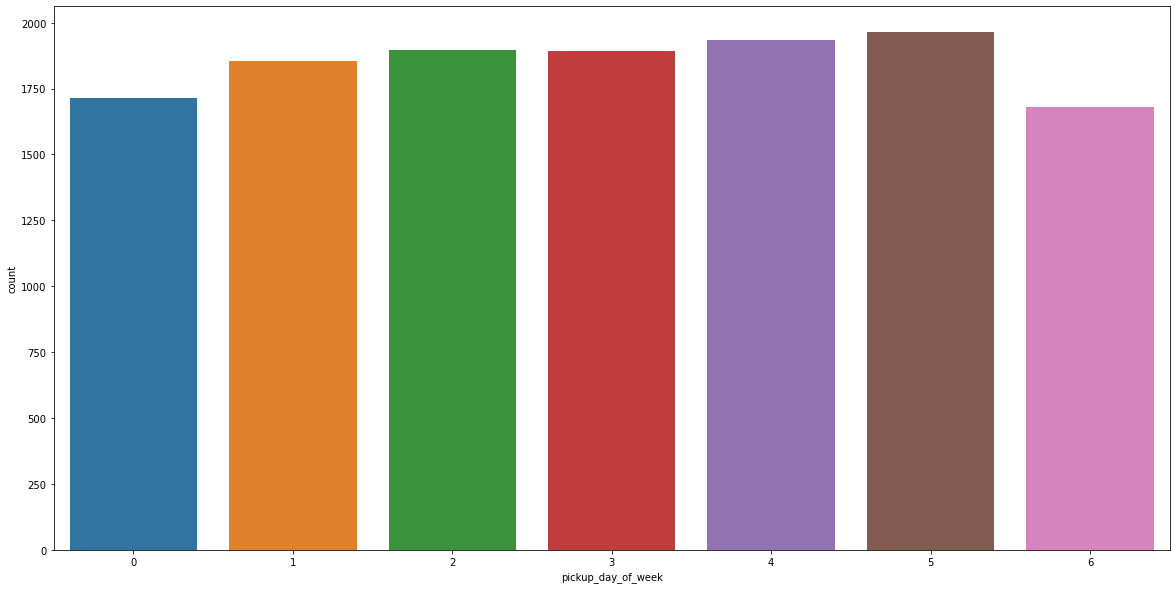

In [260]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['pickup_day_of_week'])

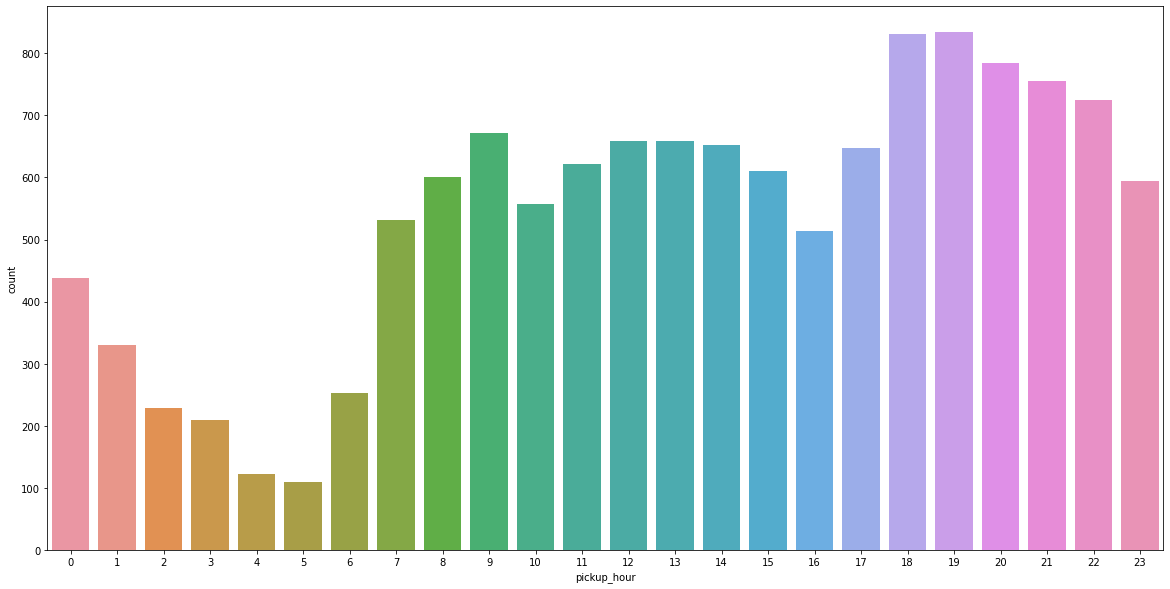

In [261]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['pickup_hour'])

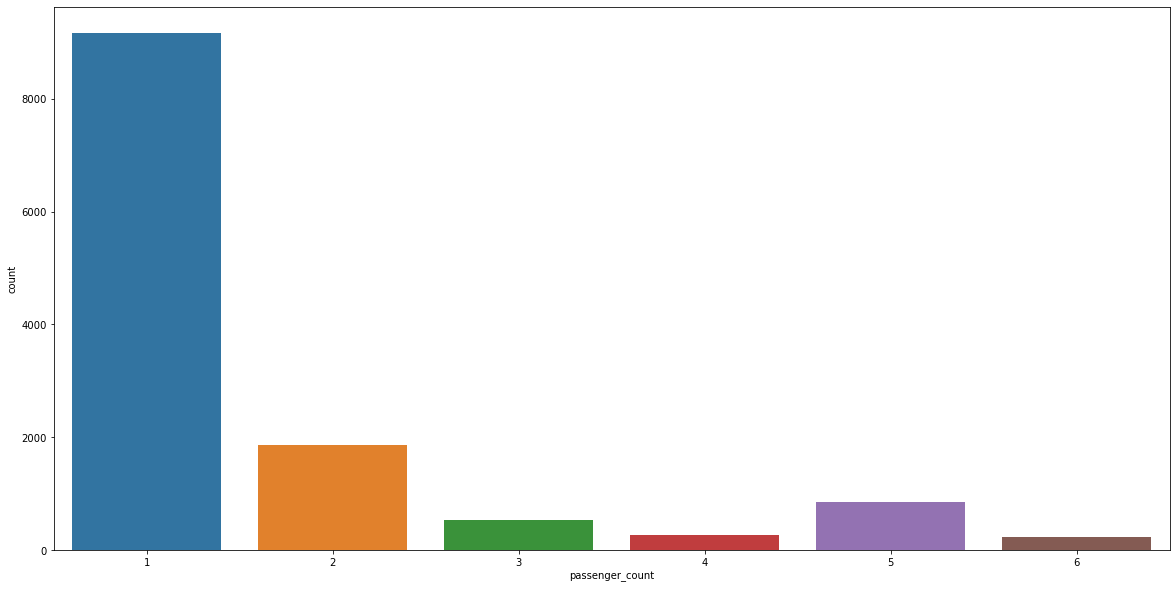

In [262]:
plt.figure(figsize=(20,10))
sns.countplot(df_1['passenger_count'])

### 4.2.2 case 2

In [263]:
a=pd.DataFrame()
a["pickup_year"] = df_2["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = df_2["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = df_2["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = df_2["pickup_datetime"].apply(lambda row: row.hour)
df_2=pd.concat([a,df_2.iloc[:,[5,7,6]]],axis=1)
df_2["pickup_year"] = df_2["pickup_year"].map(year)
df_2.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


In [264]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15568 entries, 0 to 15567
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         15568 non-null  int64  
 1   pickup_month        15568 non-null  int64  
 2   pickup_day_of_week  15568 non-null  int64  
 3   pickup_hour         15568 non-null  int64  
 4   passenger_count     15568 non-null  int64  
 5   distance            15568 non-null  float64
 6   fare_amount         15568 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 851.5 KB


In [265]:
df_2.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


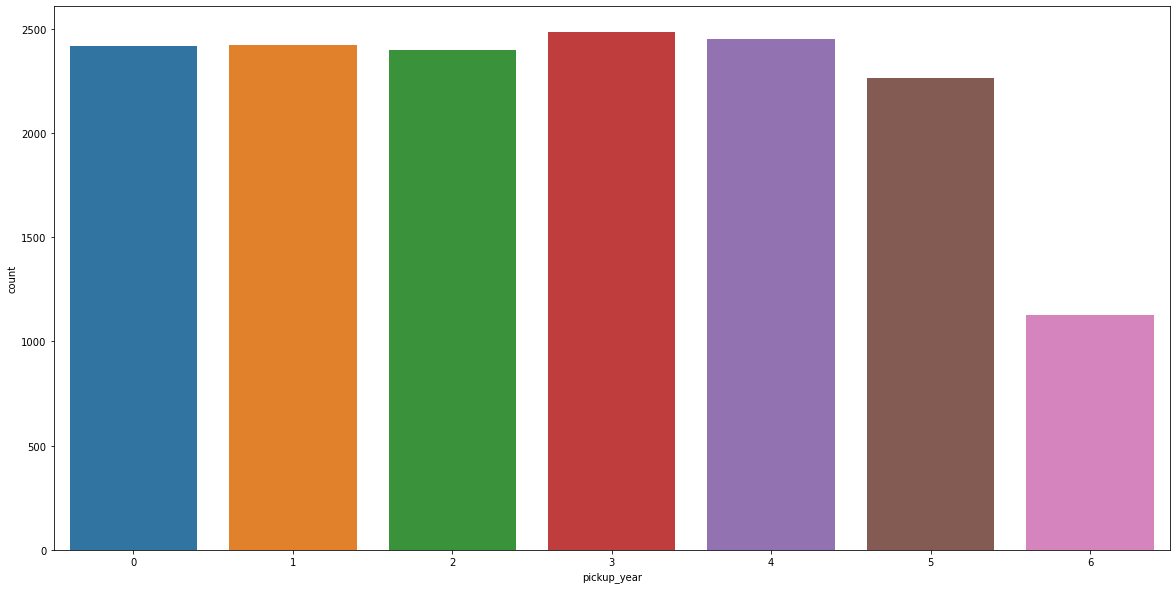

In [266]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['pickup_year'])

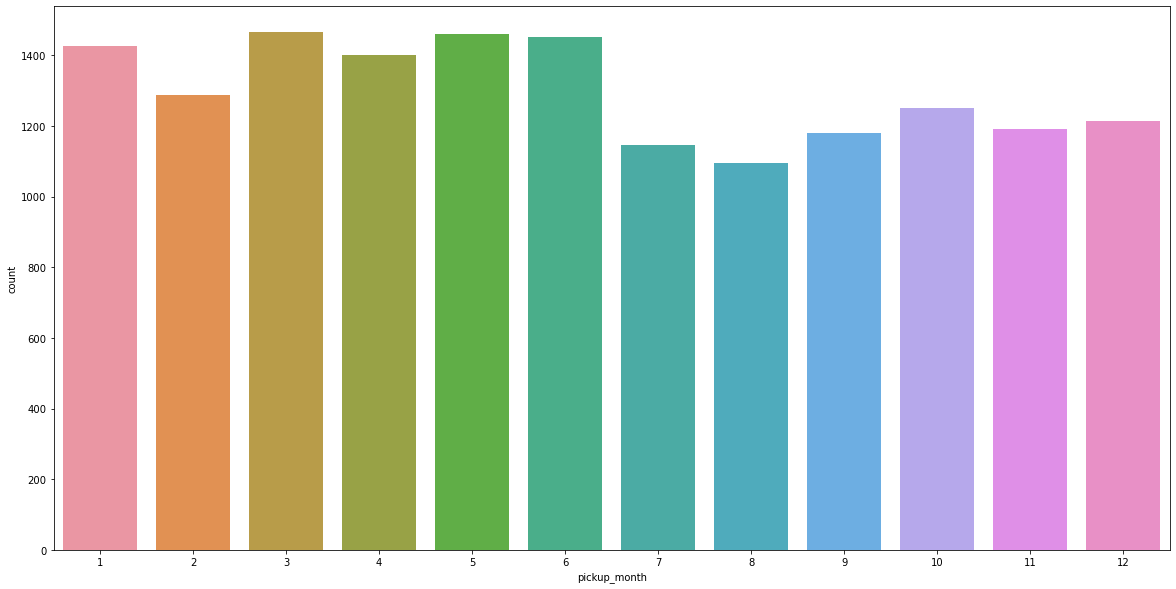

In [267]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['pickup_month'])

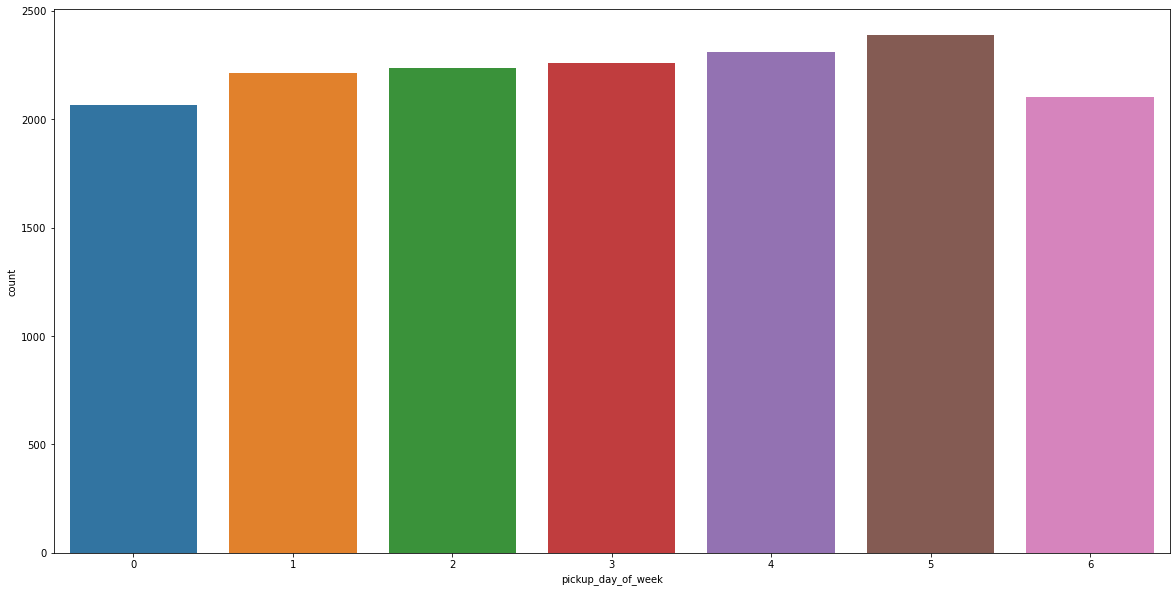

In [268]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['pickup_day_of_week'])

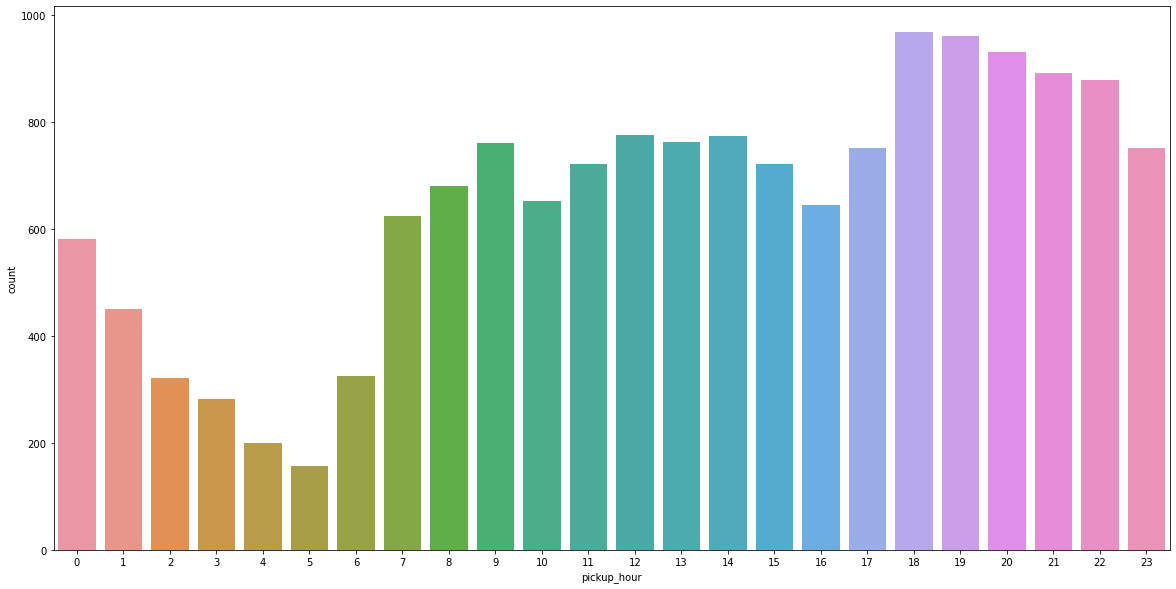

In [269]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['pickup_hour'])

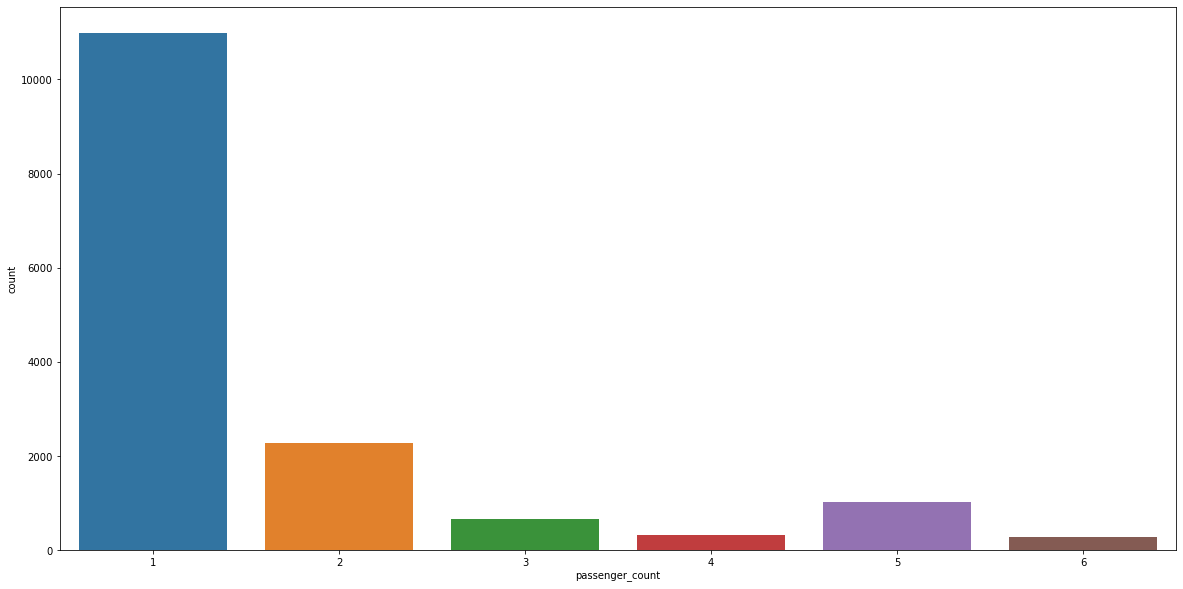

In [270]:
plt.figure(figsize=(20,10))
sns.countplot(df_2['passenger_count'])

### 4.2.3 case 3

In [271]:
a=pd.DataFrame()
a["pickup_year"] = df_3["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = df_3["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = df_3["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = df_3["pickup_datetime"].apply(lambda row: row.hour)
df_3=pd.concat([a,df_3.iloc[:,[5,7,6]]],axis=1)
df_3["pickup_year"] = df_3["pickup_year"].map(year)
df_3.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.052860,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


In [272]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14244 entries, 0 to 14243
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         14244 non-null  int64  
 1   pickup_month        14244 non-null  int64  
 2   pickup_day_of_week  14244 non-null  int64  
 3   pickup_hour         14244 non-null  int64  
 4   passenger_count     14244 non-null  int64  
 5   distance            14244 non-null  float64
 6   fare_amount         14244 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 779.1 KB


In [273]:
df_3.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.052860,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


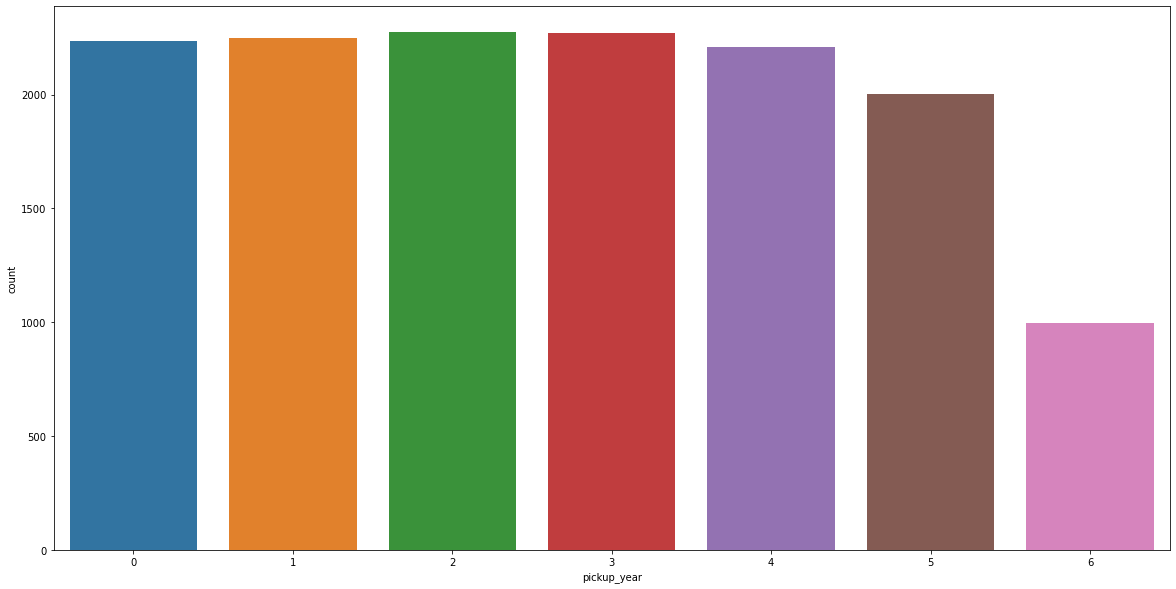

In [274]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['pickup_year'])

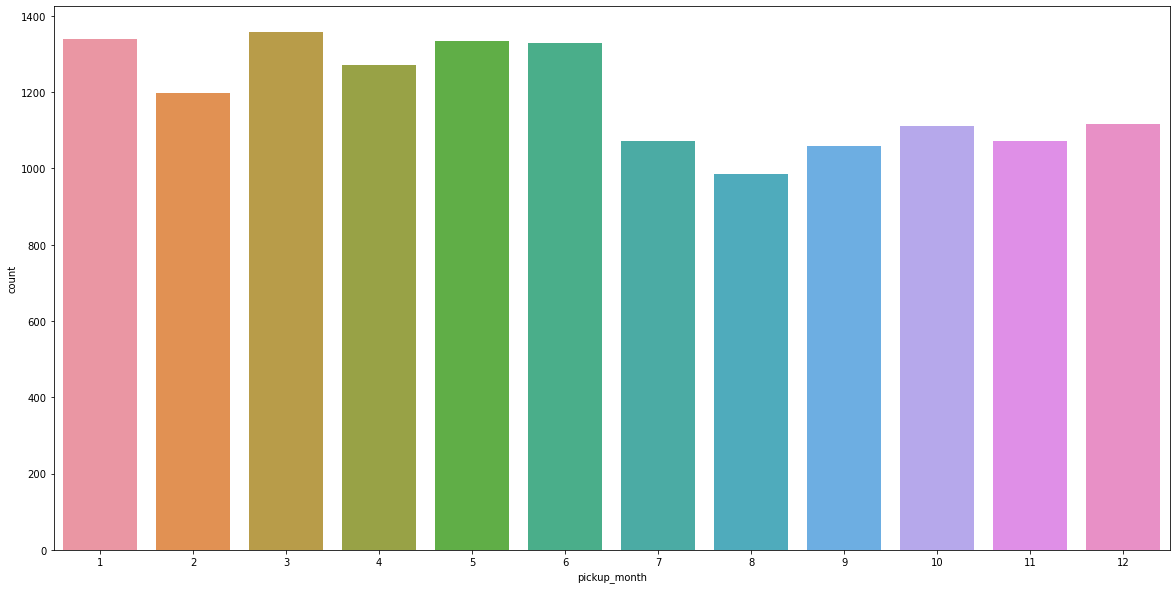

In [275]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['pickup_month'])

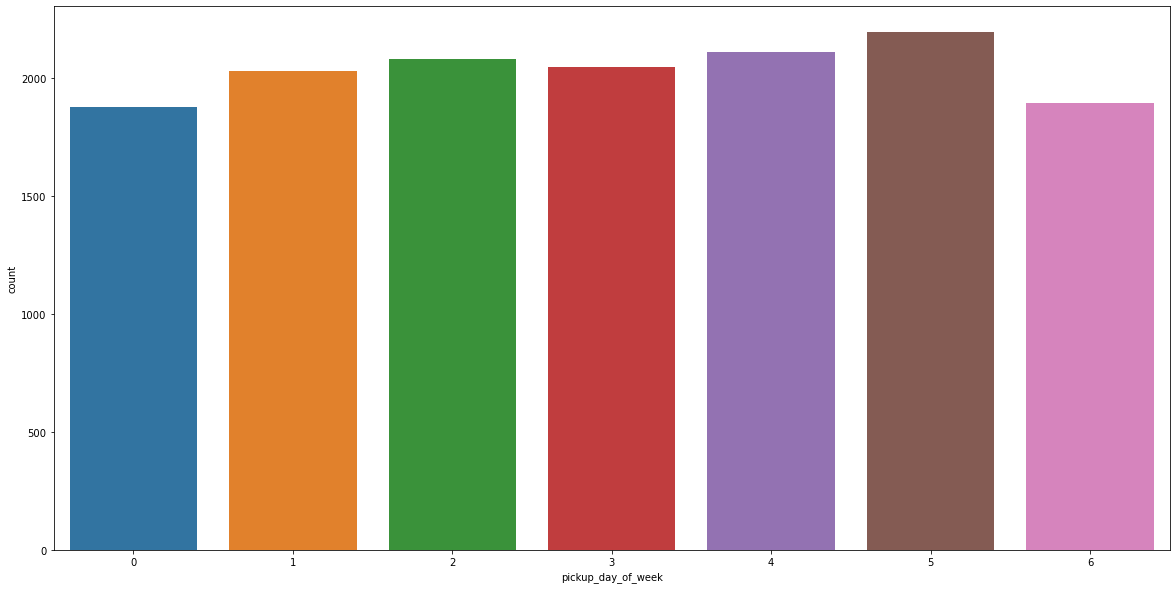

In [276]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['pickup_day_of_week'])

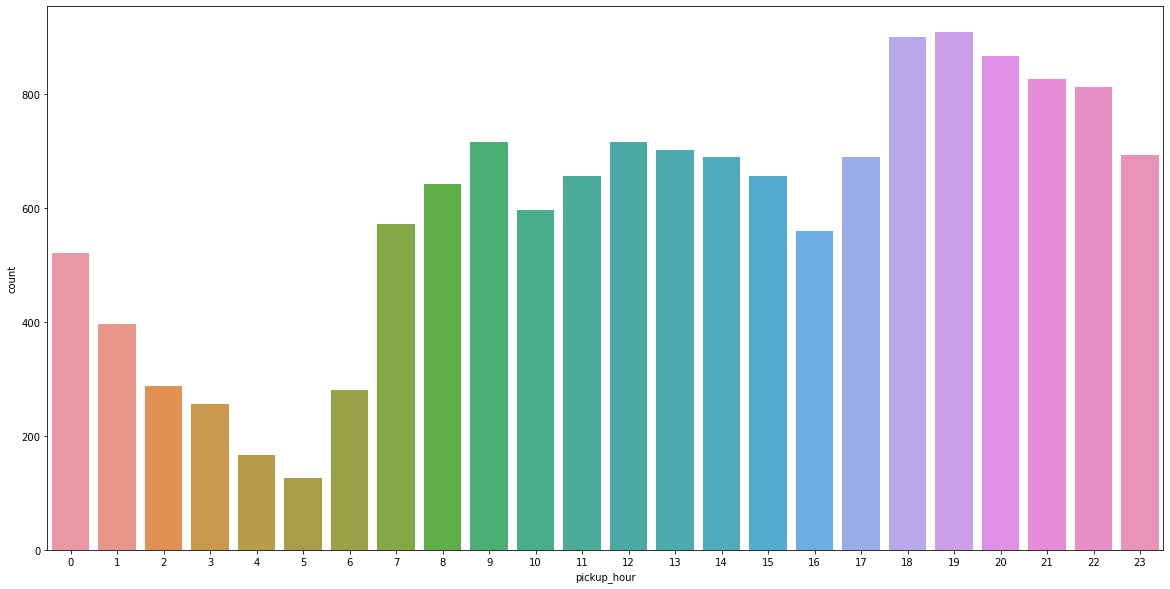

In [277]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['pickup_hour'])

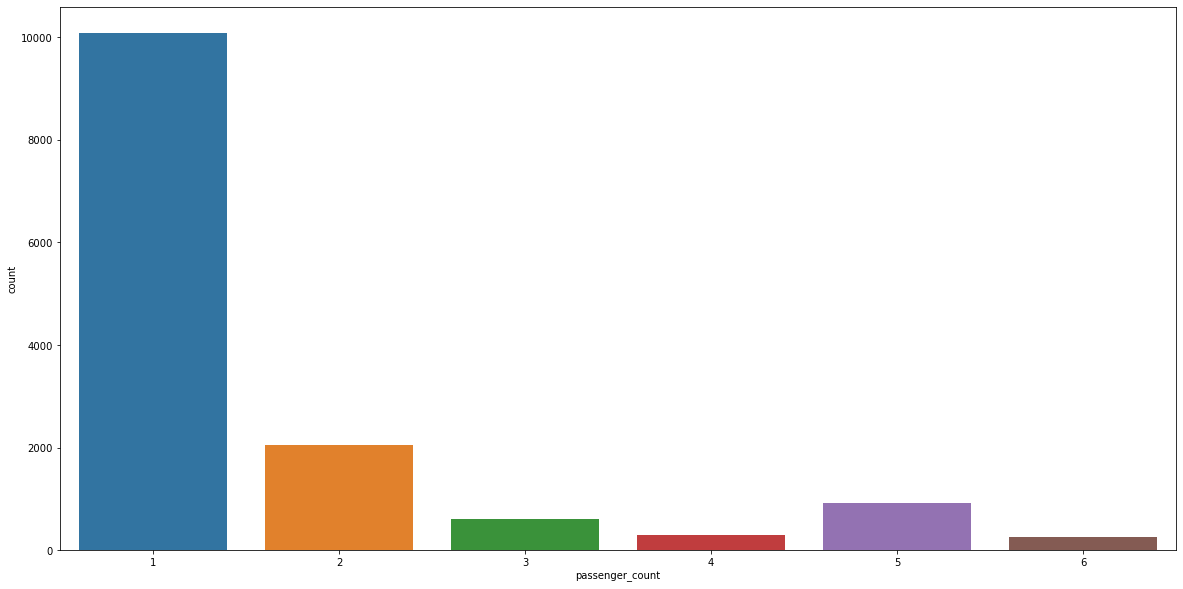

In [278]:
plt.figure(figsize=(20,10))
sns.countplot(df_3['passenger_count'])

### 4.2.4 case 4

In [279]:
a=pd.DataFrame()
a["pickup_year"] = df_4["pickup_datetime"].apply(lambda row: row.year)
a["pickup_month"] = df_4["pickup_datetime"].apply(lambda row: row.month)
a["pickup_day_of_week"] = df_4["pickup_datetime"].apply(lambda row: row.dayofweek)
a["pickup_hour"] = df_4["pickup_datetime"].apply(lambda row: row.hour)
df_4=pd.concat([a,df_4.iloc[:,[5,7,6]]],axis=1)
df_4["pickup_year"] = df_4["pickup_year"].map(year)
df_4.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


In [280]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pickup_year         15702 non-null  int64  
 1   pickup_month        15702 non-null  int64  
 2   pickup_day_of_week  15702 non-null  int64  
 3   pickup_hour         15702 non-null  int64  
 4   passenger_count     15702 non-null  int64  
 5   distance            15702 non-null  float64
 6   fare_amount         15702 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 858.8 KB


In [281]:
df_4.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.029601,4.5
1,1,1,1,16,1,8.443441,16.9
2,2,8,3,0,2,1.389132,5.7
3,3,4,5,4,1,2.795790,7.7
4,1,3,1,7,1,1.998338,5.3


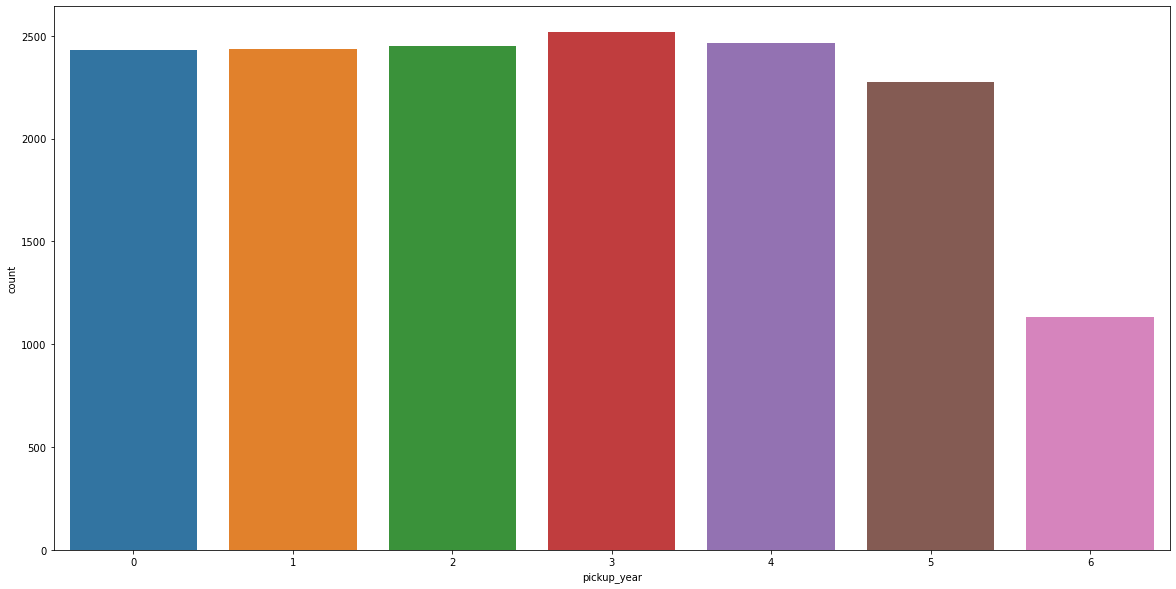

In [282]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['pickup_year'])

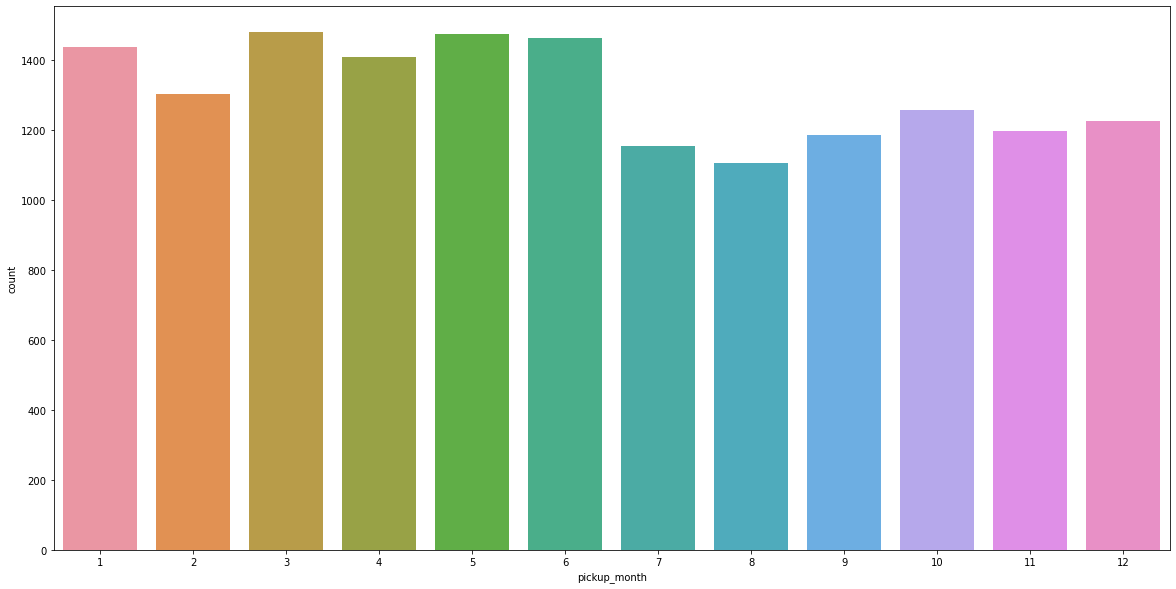

In [283]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['pickup_month'])

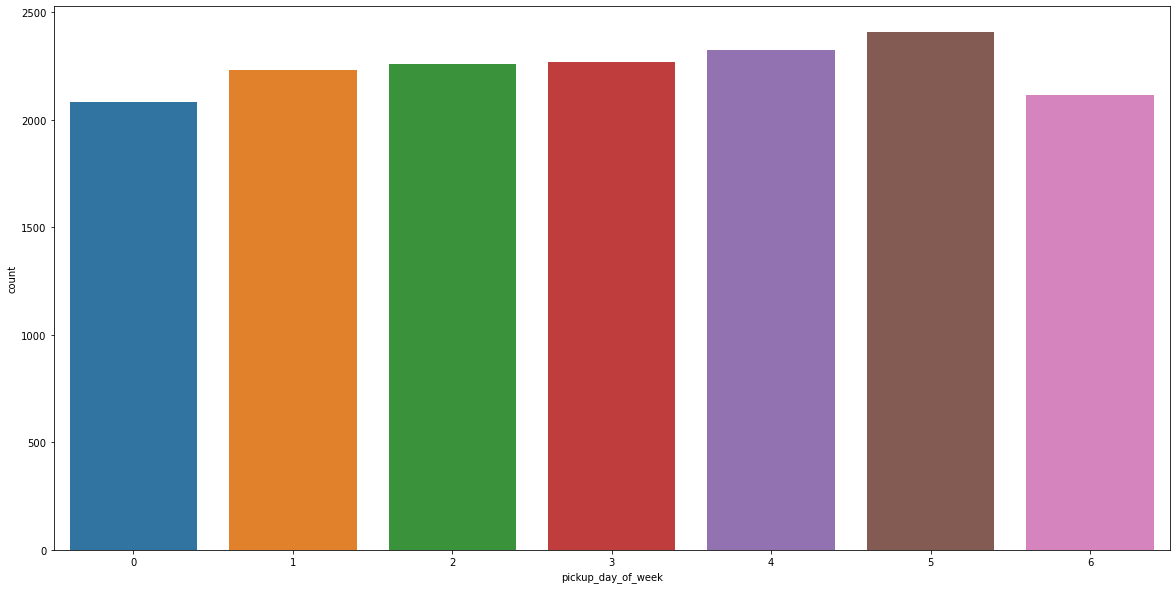

In [284]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['pickup_day_of_week'])

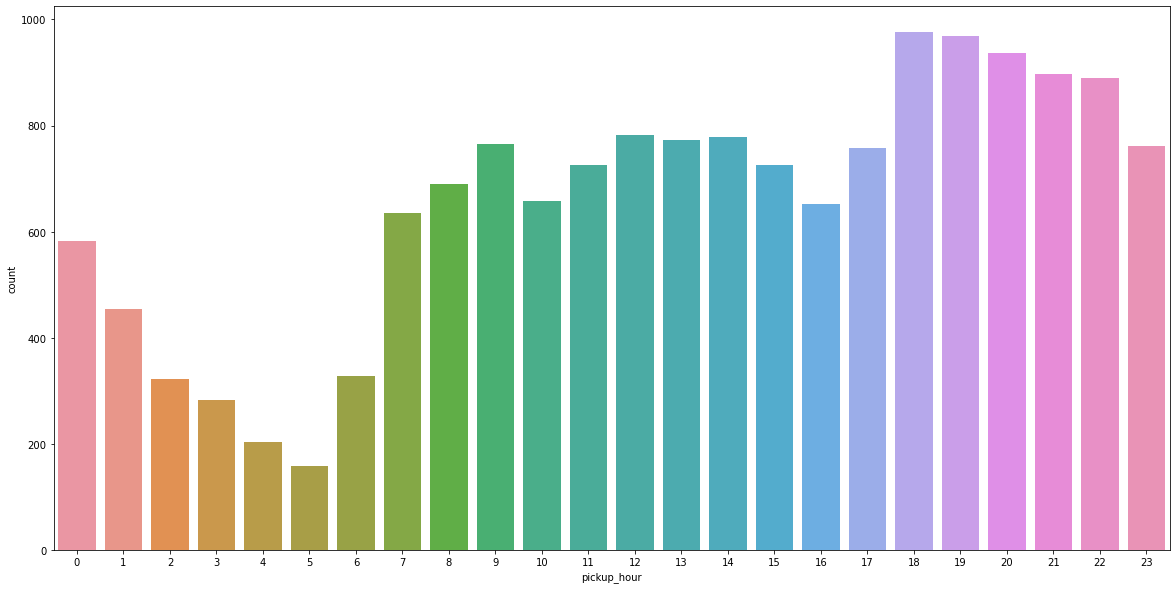

In [285]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['pickup_hour'])

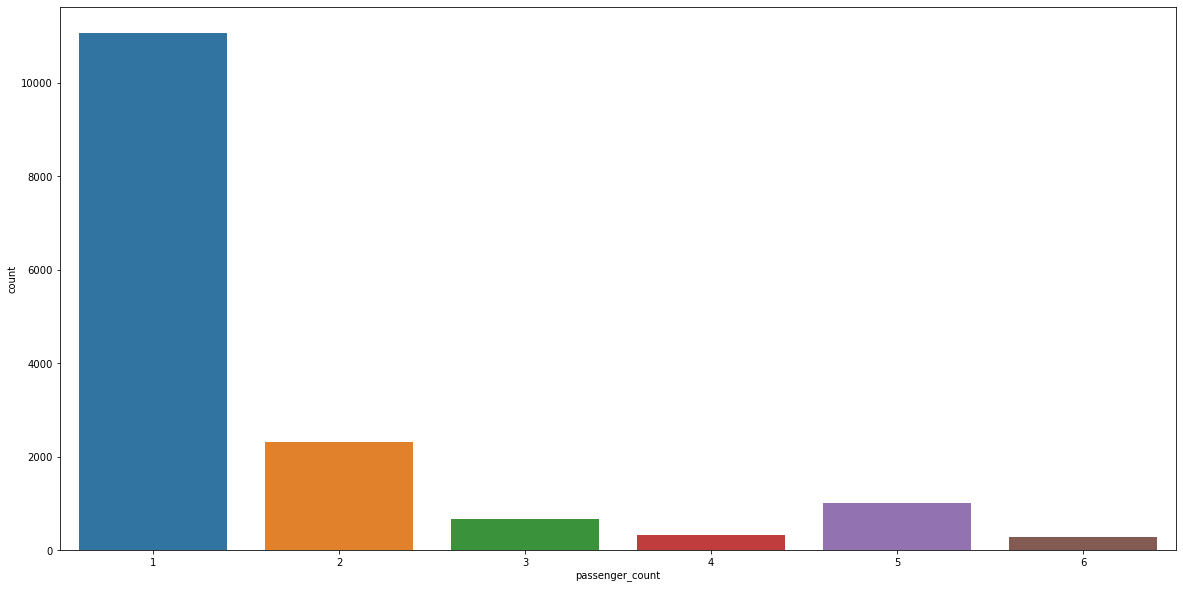

In [286]:
plt.figure(figsize=(20,10))
sns.countplot(df_4['passenger_count'])

# 5.Feature Selection

In [287]:
cat_var=['pickup_year','pickup_month','pickup_day_of_week','pickup_hour','passenger_count']

In [288]:
num_var=['distance','fare_amount']

## 5.1 case 1

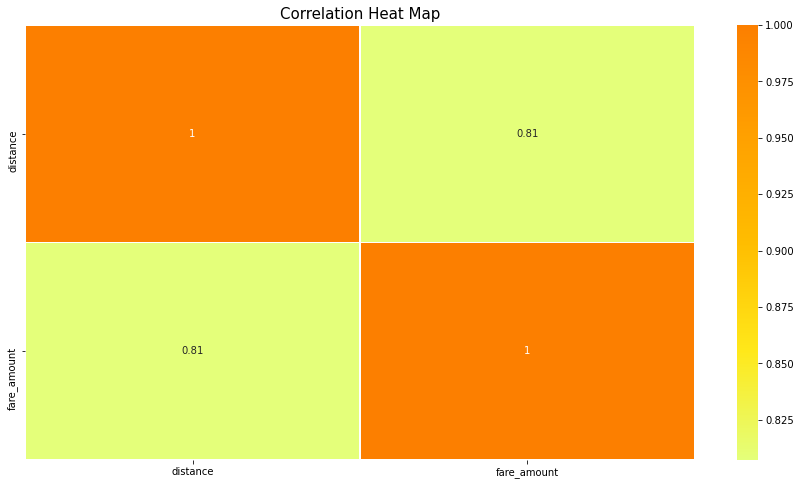

In [289]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_1[num_var].corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

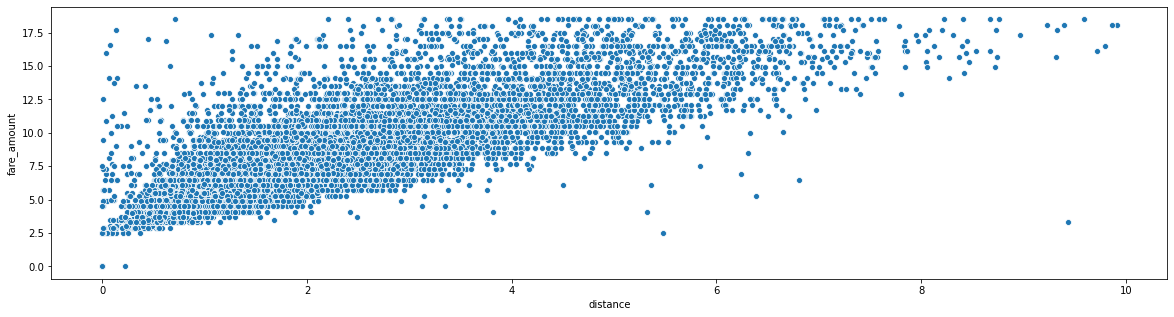

In [290]:
plt.figure(figsize=(20,5)) 
sns.scatterplot(df_1['distance'],df_1['fare_amount'])

## 5.2 case 2

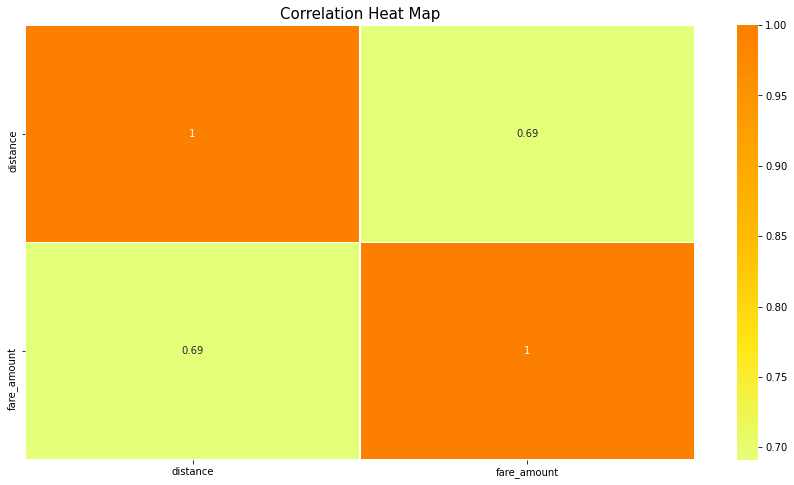

In [291]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_2[num_var].corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

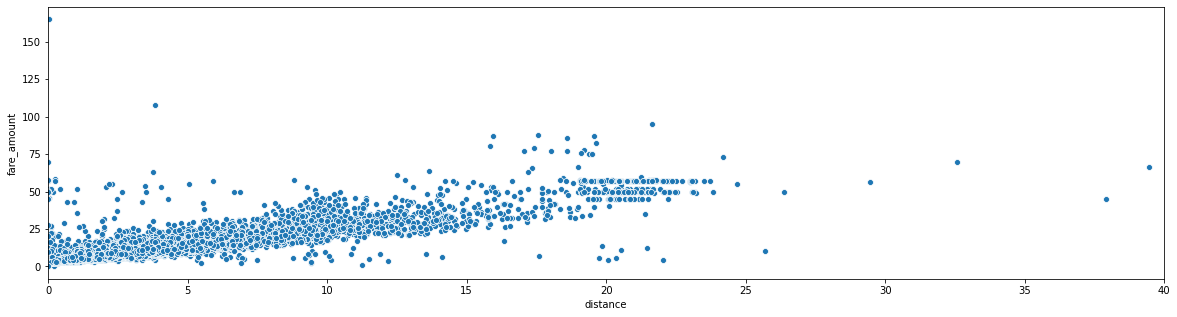

In [292]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,40)
sns.scatterplot(df_2['distance'],df_2['fare_amount'])

## 5.3 case 3

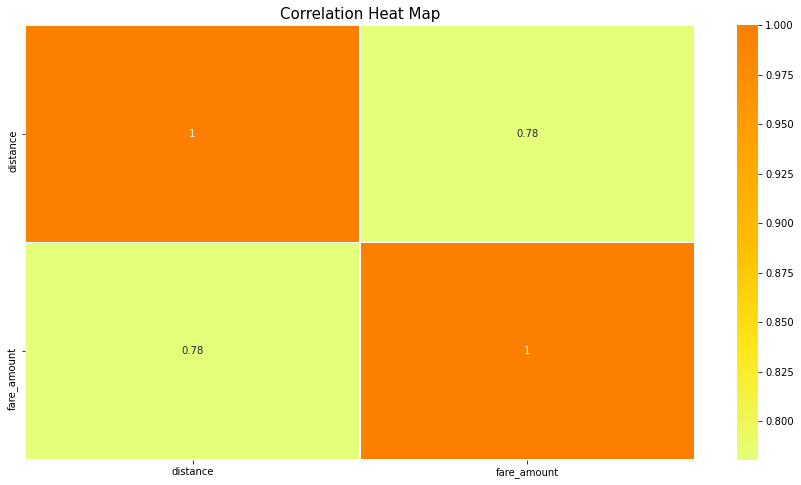

In [293]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_3[num_var].corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

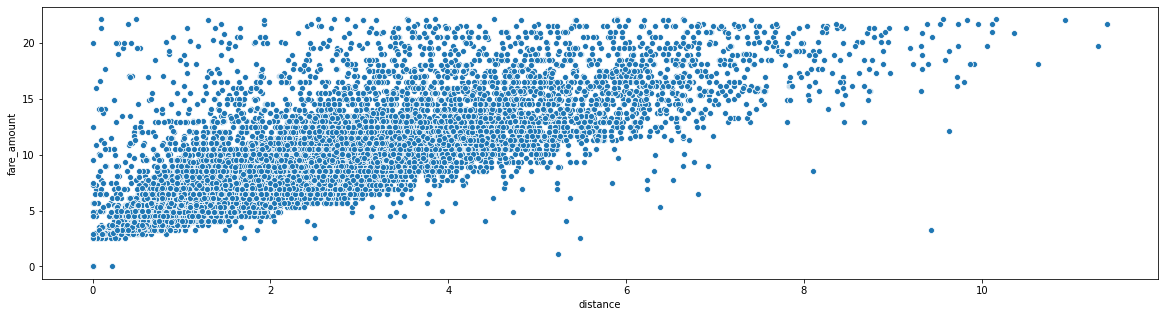

In [294]:
plt.figure(figsize=(20,5)) 
sns.scatterplot(df_3['distance'],df_3['fare_amount'])

## 5.4 case 4

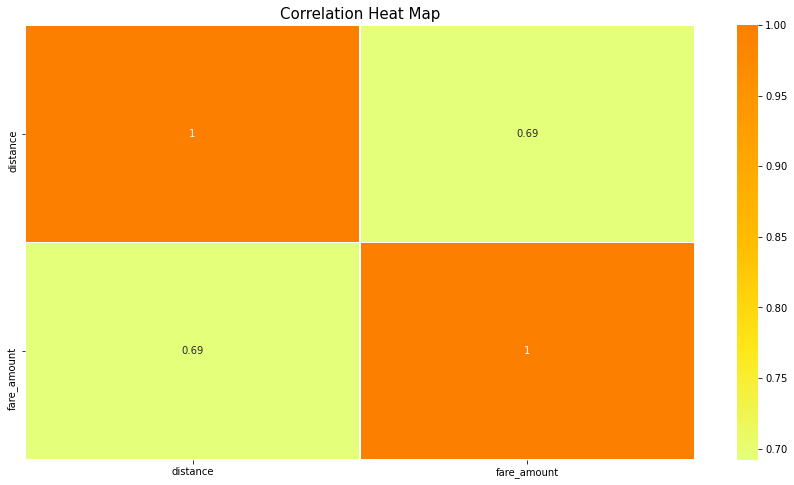

In [295]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_4[num_var].corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

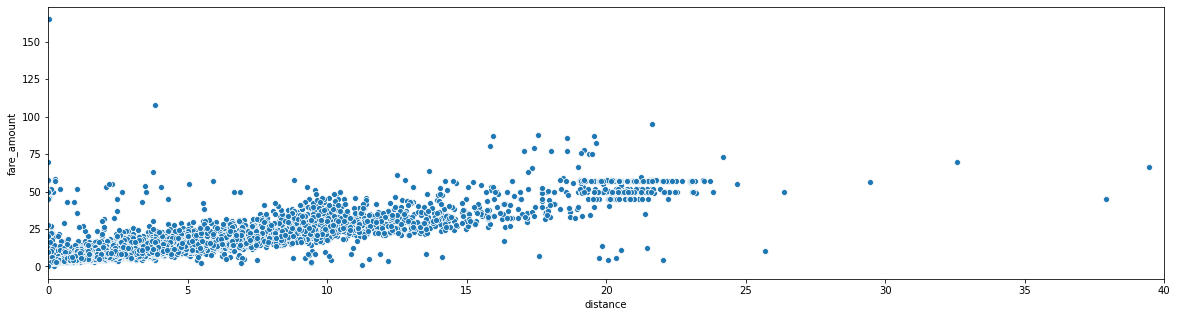

In [296]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,40)
sns.scatterplot(df_4['distance'],df_4['fare_amount'])

# 6.Feature Transformation

## 6.1 distance

In [297]:
import scipy.stats as stat
import pylab 

In [298]:
#### If you want to check whether feature is guassian or normal distributed
#### Q-Q plot
def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.suptitle(feature, fontsize = 15)
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

### 6.1.1 case 1

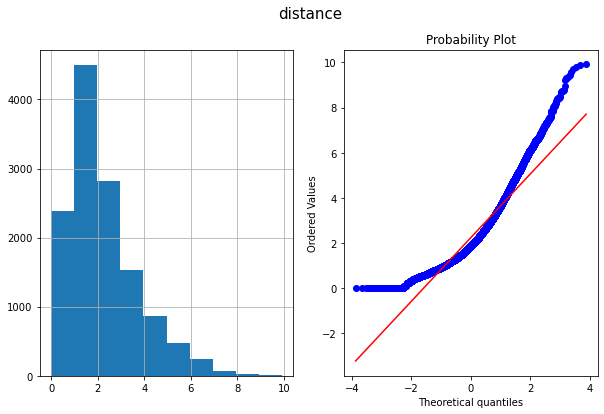

In [299]:
plot_data(df_1,'distance')

#### Not a gaussian distribution

In [300]:
a=pd.DataFrame()

### 6.1.1.1 Logarithmic Transformation

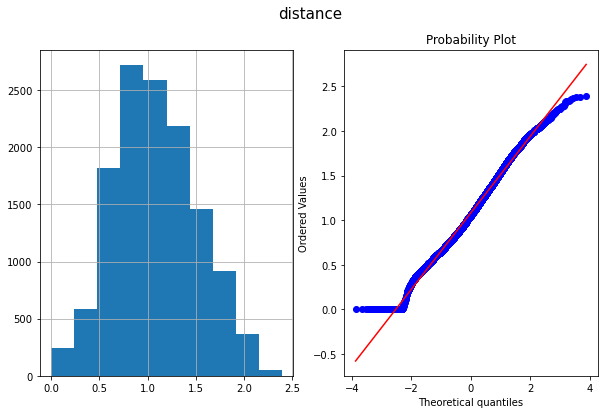

In [301]:
a['distance']=np.log(df_1['distance']+1)
plot_data(a,'distance')

### 6.1.1.2 Reciprocal Transformation

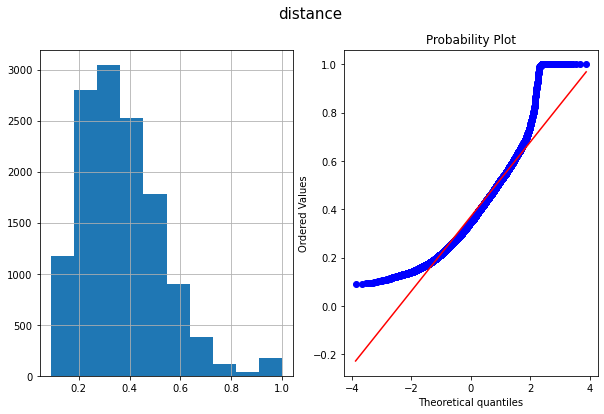

In [302]:
a['distance']=1/(df_1['distance']+1)
plot_data(a,'distance')

### 6.1.1.3 Square Root Transformation

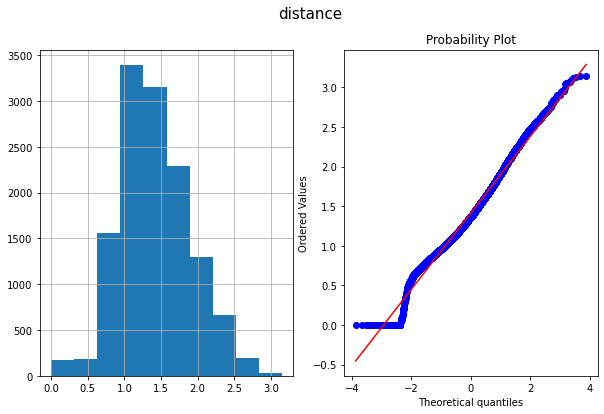

In [303]:
a['distance']=df_1['distance']**(1/2)
plot_data(a,'distance')

### 6.1.1.4 Exponential Transformation

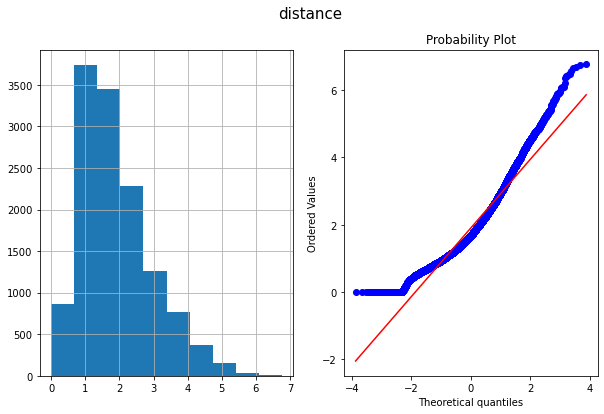

In [304]:
a['distance']=df_1['distance']**(1/1.2)
plot_data(a,'distance')

#### Based on Q-Q plot we select square root transformation for distance variable

In [305]:
df_1['distance']=df_1['distance']**(1/2)

### 6.1.2 case 2

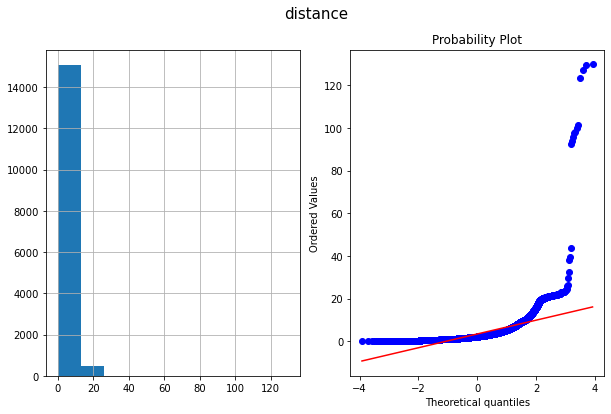

In [306]:
plot_data(df_2,'distance')

#### Not a gaussian distribution

### 6.1.2.1 Logarithmic Transformation

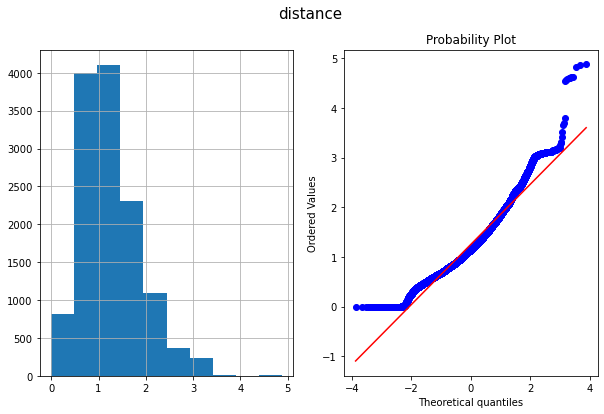

In [307]:
a['distance']=np.log(df_2['distance']+1)
plot_data(a,'distance')

### 6.1.2.2 Reciprocal Transformation

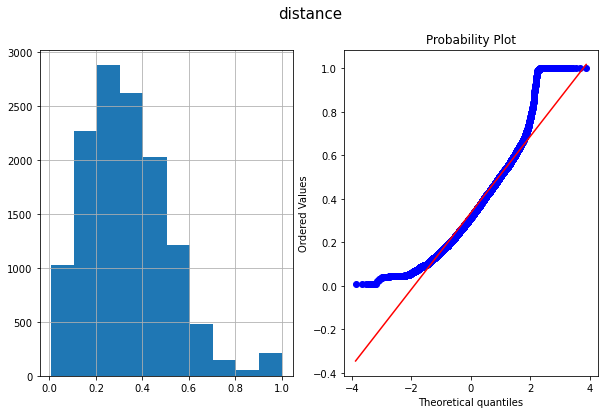

In [308]:
a['distance']=1/(df_2['distance']+1)
plot_data(a,'distance')

### 6.1.2.3 Square Root Transformation

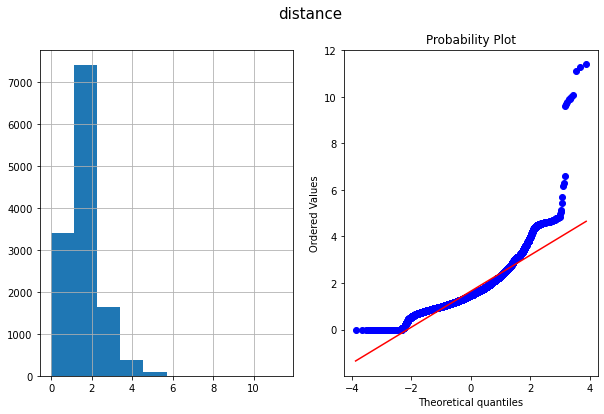

In [309]:
a['distance']=df_2['distance']**(1/2)
plot_data(a,'distance')

### 6.1.2.4 Exponential Transformation

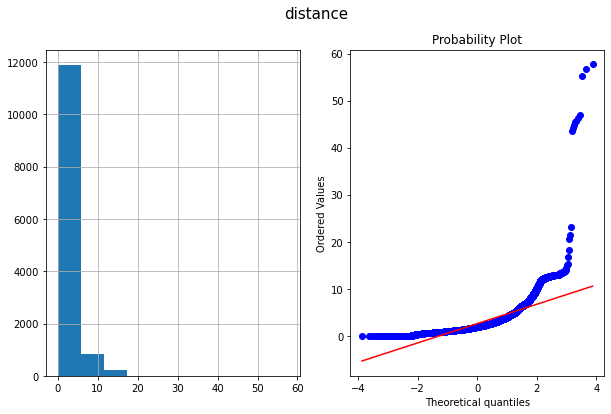

In [310]:
a['distance']=df_2['distance']**(1/1.2)
plot_data(a,'distance')

#### Based on Q-Q plot we select Logarithmic transformation for distance variable

In [311]:
df_2['distance']=np.log(df_2['distance']+1)

### 6.1.3 case 3

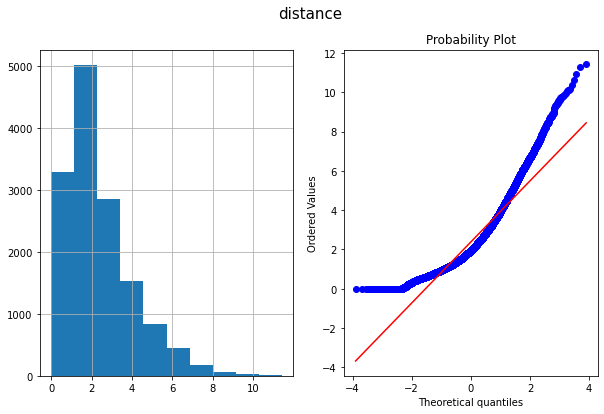

In [312]:
plot_data(df_3,'distance')

#### Not a gaussian distribution

### 6.1.3.1 Logarithmic Transformation

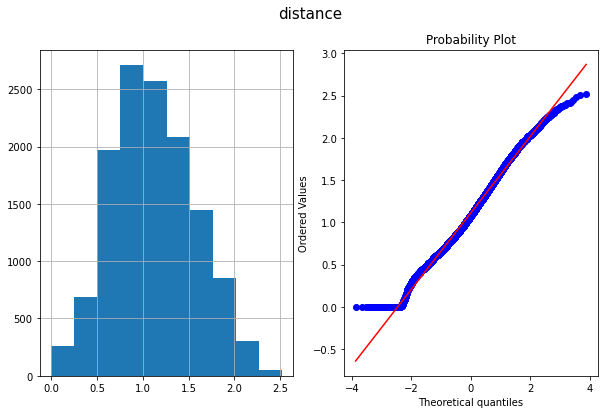

In [313]:
a['distance']=np.log(df_3['distance']+1)
plot_data(a,'distance')

### 6.1.3.2 Reciprocal Transformation

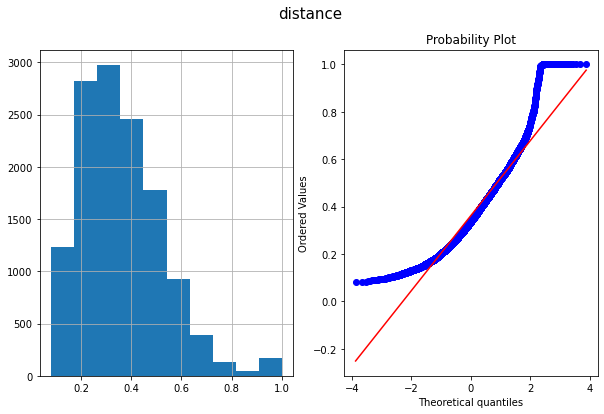

In [314]:
a['distance']=1/(df_3['distance']+1)
plot_data(a,'distance')

### 6.1.3.3 Square Root Transformation

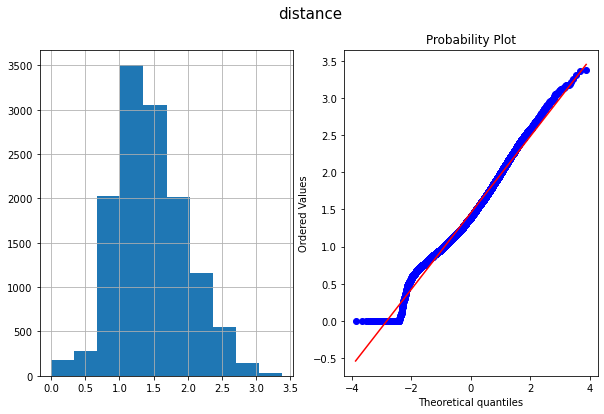

In [315]:
a['distance']=df_3['distance']**(1/2)
plot_data(a,'distance')

### 6.1.3.4 Exponential Transformation

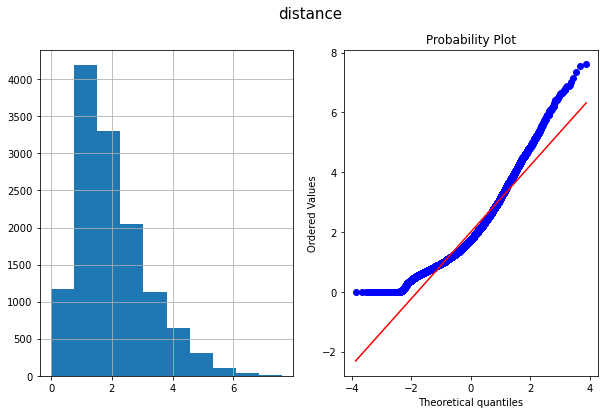

In [316]:
a['distance']=df_3['distance']**(1/1.2)
plot_data(a,'distance')

#### Based on Q-Q plot we select square root transformation for distance variable

In [317]:
df_3['distance']=df_3['distance']**(1/2)

### 6.1.4 case 4

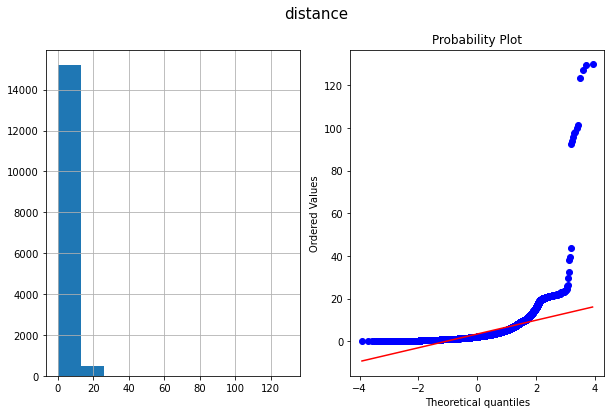

In [318]:
plot_data(df_4,'distance')

#### Not a gaussian distribution

### 6.1.4.1 Logarithmic Transformation

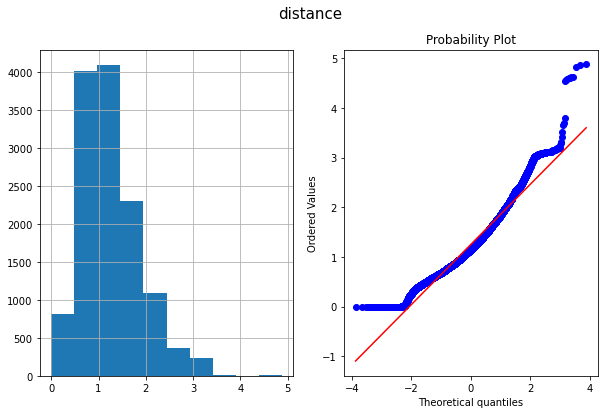

In [319]:
a['distance']=np.log(df_4['distance']+1)
plot_data(a,'distance')

### 6.1.4.2 Reciprocal Transformation

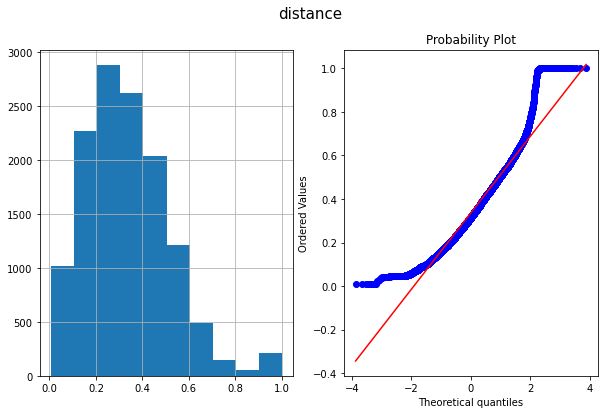

In [320]:
a['distance']=1/(df_4['distance']+1)
plot_data(a,'distance')

### 6.1.4.3 Square Root Transformation

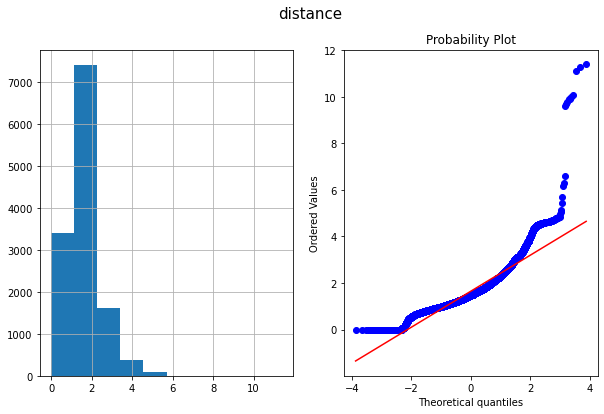

In [321]:
a['distance']=df_4['distance']**(1/2)
plot_data(a,'distance')

### 6.1.4.4 Exponential Transformation

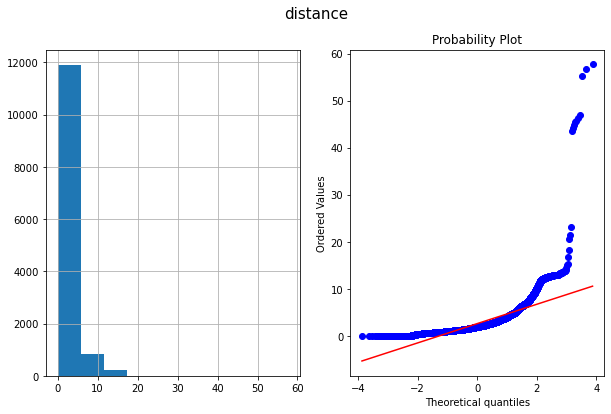

In [322]:
a['distance']=df_4['distance']**(1/1.2)
plot_data(a,'distance')

#### Based on Q-Q plot we select Logarithmic transformation for distance variable

In [323]:
df_4['distance']=np.log(df_4['distance']+1)

# 7.Feature Scaling

In [324]:
from sklearn.preprocessing import StandardScaler

## 7.1 case 1

In [325]:
scaler_1=StandardScaler()
df_standard=pd.DataFrame(scaler_1.fit_transform(df_1[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,3.062126
1,-0.492254
2,0.523236
3,-0.008612
4,1.087550


In [326]:
df_1['distance']=df_standard.copy()

## 7.2 case 2

In [327]:
scaler_2=StandardScaler()
df_standard=pd.DataFrame(scaler_2.fit_transform(df_2[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.881008
1,1.607590
2,-0.617026
3,0.132334
4,-0.249392


In [328]:
df_2['distance']=df_standard.copy()

## 7.3 case 3

In [329]:
scaler_3=StandardScaler()
df_standard=pd.DataFrame(scaler_3.fit_transform(df_3[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.829383
1,2.805163
2,-0.534460
3,0.419674
4,-0.080040


In [330]:
df_3['distance']=df_standard.copy()

## 7.4 case 4

In [331]:
scaler_4=StandardScaler()
df_standard=pd.DataFrame(scaler_4.fit_transform(df_4[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.881051
1,1.610251
2,-0.616782
3,0.133393
4,-0.248749


In [332]:
df_4['distance']=df_standard.copy()

# 8.Model Building

## 8.1 Train,Test splitting

In [333]:
from sklearn.model_selection import train_test_split

### 8.1.1 case 1

In [334]:
df_1.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,1,1,1,16,1,3.062126,16.9
1,2,8,3,0,2,-0.492254,5.7
2,3,4,5,4,1,0.523236,7.7
3,1,3,1,7,1,-0.008612,5.3
4,2,1,3,9,1,1.087550,12.1


In [335]:
x_1=df_1.iloc[:,:-1]
y_1=df_1.iloc[:,-1]

In [336]:
x_1_train,x_1_test,y_1_train,y_1_test=train_test_split(x_1,y_1,train_size=0.7,random_state=1234)

In [337]:
x_1_train.shape

(9054, 6)

In [338]:
x_1_test.shape

(3881, 6)

### 8.1.2 case 2

In [339]:
df_2.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.881008,4.5
1,1,1,1,16,1,1.607590,16.9
2,2,8,3,0,2,-0.617026,5.7
3,3,4,5,4,1,0.132334,7.7
4,1,3,1,7,1,-0.249392,5.3


In [340]:
x_2=df_2.iloc[:,:-1]
y_2=df_2.iloc[:,-1]

In [341]:
x_2_train,x_2_test,y_2_train,y_2_test=train_test_split(x_2,y_2,train_size=0.7,random_state=1234)

In [342]:
x_2_train.shape

(10897, 6)

In [343]:
x_2_test.shape

(4671, 6)

### 8.1.3 case 3

In [344]:
df_3.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.829383,4.5
1,1,1,1,16,1,2.805163,16.9
2,2,8,3,0,2,-0.534460,5.7
3,3,4,5,4,1,0.419674,7.7
4,1,3,1,7,1,-0.080040,5.3


In [345]:
x_3=df_3.iloc[:,:-1]
y_3=df_3.iloc[:,-1]

In [346]:
x_3_train,x_3_test,y_3_train,y_3_test=train_test_split(x_3,y_3,train_size=0.7,random_state=1234)

In [347]:
x_3_train.shape

(9970, 6)

In [348]:
x_3_test.shape

(4274, 6)

### 8.1.4 case 4

In [349]:
df_4.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.881051,4.5
1,1,1,1,16,1,1.610251,16.9
2,2,8,3,0,2,-0.616782,5.7
3,3,4,5,4,1,0.133393,7.7
4,1,3,1,7,1,-0.248749,5.3


In [350]:
x_4=df_4.iloc[:,:-1]
y_4=df_4.iloc[:,-1]

In [351]:
x_4_train,x_4_test,y_4_train,y_4_test=train_test_split(x_4,y_4,train_size=0.7,random_state=1234)

In [352]:
x_4_train.shape

(10991, 6)

In [353]:
x_4_test.shape

(4711, 6)

## 8.2 Linear Regression

In [354]:
from sklearn.linear_model  import LinearRegression

In [355]:
# function to calculate adjusted r^2
def adj_r2(x,y,model):
    r2=model.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [356]:
# function to calculate RMSE
def RMSE(y_true,y_pred):
    rmse=(np.mean((y_true-y_pred)**2))**(1/2)
    return rmse

In [357]:
!pip install RegscorePy

In [358]:
from RegscorePy import *

### 8.2.1 case 1

In [359]:
LR_1 = LinearRegression()
LR_1.fit(x_1_train,y_1_train)

LinearRegression()

In [360]:
LR_1.coef_

array([ 0.32168633,  0.04631159, -0.01706722,  0.00862156,  0.04837053,
        2.88877042])

In [369]:
y_pred_LR_1=LR_1.predict(x_1_test)
y_pred_train_LR_1=LR_1.predict(x_1_train)

In [361]:
# r^2 value for train
LR_1.score(x_1_train,y_1_train)

0.6965802411028926

In [362]:
# r^2 value for test
LR_1.score(x_1_test,y_1_test)

0.6811209253646785

In [363]:
# adjusted r^2 value for train
adj_r2(x_1_train,y_1_train,LR_1)

0.6963790121260625

In [364]:
# adjusted r^2 value for test
adj_r2(x_1_test,y_1_test,LR_1)

0.6806270496682894

In [370]:
# RMSE value
RMSE(y_1_test,y_pred_LR_1)

1.9716121785747585

In [371]:
# AIC value
aic.aic(y_1_train, y_pred_train_LR_1, p=7)

12055.09631185186

### 8.2.2 case 2

In [372]:
LR_2 = LinearRegression()
LR_2.fit(x_2_train,y_2_train)

LinearRegression()

In [373]:
LR_2.coef_

array([ 5.06480332e-01,  1.06577935e-01, -5.46595258e-02,  9.04913262e-04,
        6.59541577e-03,  7.27811261e+00])

In [374]:
y_pred_LR_2=LR_2.predict(x_2_test)
y_pred_train_LR_2=LR_2.predict(x_2_train)

In [375]:
# r^2 value for train
LR_2.score(x_2_train,y_2_train)

0.6131056838850134

In [376]:
# r^2 value for test
LR_2.score(x_2_test,y_2_test)

0.6384803558199281

In [377]:
# adjusted r^2 value for train
adj_r2(x_2_train,y_2_train,LR_2)

0.6128925189725534

In [378]:
# adjusted r^2 value for test
adj_r2(x_2_test,y_2_test,LR_2)

0.6380152790907085

In [379]:
# RMSE value
RMSE(y_2_test,y_pred_LR_2)

5.862420830763255

In [380]:
# AIC value
aic.aic(y_2_train, y_pred_train_LR_2, p=7)

38438.108471096704

### 8.2.3 case 3

In [381]:
LR_3 = LinearRegression()
LR_3.fit(x_3_train,y_3_train)

LinearRegression()

In [382]:
LR_3.coef_

array([ 3.57245290e-01,  6.41807967e-02, -2.63357138e-02, -2.78408110e-03,
        3.25889944e-02,  3.25736450e+00])

In [383]:
y_pred_LR_3=LR_3.predict(x_3_test)
y_pred_train_LR_3=LR_3.predict(x_3_train)

In [384]:
# r^2 value for train
LR_3.score(x_3_train,y_3_train)

0.6273084869831798

In [385]:
# r^2 value for test
LR_3.score(x_3_test,y_3_test)

0.6490024367059136

In [386]:
# adjusted r^2 value for train
adj_r2(x_3_train,y_3_train,LR_3)

0.6270840416275538

In [387]:
# adjusted r^2 value for test
adj_r2(x_3_test,y_3_test,LR_3)

0.648508884941263

In [388]:
# RMSE value
RMSE(y_3_test,y_pred_LR_3)

2.4508669241700702

In [389]:
# AIC value
aic.aic(y_3_train, y_pred_train_LR_3, p=7)

18720.058628062743

### 8.2.4 case 4

In [390]:
LR_4 = LinearRegression()
LR_4.fit(x_4_train,y_4_train)

LinearRegression()

In [391]:
LR_4.coef_

array([ 5.23914782e-01,  1.07055883e-01, -7.06693794e-02, -5.83789297e-03,
        4.49698924e-02,  7.53637534e+00])

In [392]:
y_pred_LR_4=LR_4.predict(x_4_test)
y_pred_train_LR_4=LR_4.predict(x_4_train)

In [393]:
# r^2 value for train
LR_4.score(x_4_train,y_4_train)

0.6473690279089446

In [394]:
# r^2 value for test
LR_4.score(x_4_test,y_4_test)

0.5597747170236451

In [395]:
# adjusted r^2 value for train
adj_r2(x_4_train,y_4_train,LR_4)

0.6471764035614804

In [396]:
# adjusted r^2 value for test
adj_r2(x_4_test,y_4_test,LR_4)

0.559213205183114

In [397]:
# RMSE value
RMSE(y_4_test,y_pred_LR_4)

6.2453913021125445

In [398]:
# AIC value
aic.aic(y_4_train, y_pred_train_LR_4, p=7)

38030.791385057935

## 8.3 KNN algorithm

In [399]:
from sklearn.neighbors import KNeighborsRegressor

### 8.3.1 case 1

In [400]:
KNN_1=KNeighborsRegressor()

In [401]:
KNN_1.fit(x_1_train,y_1_train)

KNeighborsRegressor()

In [402]:
y_pred_KNN_1=KNN_1.predict(x_1_test)
y_pred_train_KNN_1=KNN_1.predict(x_1_train)

In [403]:
# r^2 value for train
KNN_1.score(x_1_train,y_1_train)

0.7105673148345638

In [404]:
# r^2 value for test
KNN_1.score(x_1_test,y_1_test)

0.545511359931091

In [405]:
# adjusted r^2 value for train
adj_r2(x_1_train,y_1_train,KNN_1)

0.7103753621307953

In [406]:
# adjusted r^2 value for test
adj_r2(x_1_test,y_1_test,KNN_1)

0.5448074539320168

In [407]:
# RMSE value
RMSE(y_1_test,y_pred_KNN_1)

2.3538023810548596

In [408]:
# AIC value
aic.aic(y_1_train, y_pred_train_KNN_1, p=7)

11627.79784535923

### 8.3.1.1 Hyper parameter Tuning

In [549]:
from sklearn.model_selection import GridSearchCV

In [375]:
param_grid = { 'n_neighbors' : list(range(3,14)),
               'weights'     : ['uniform','distance'],
               'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size'   : list(range(1,15)),
               'p'           : [2,1]
              }

In [376]:
gridsearch = GridSearchCV(KNN_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 2464 candidates, totalling 12320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 2880 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 6144 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 7488 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 8960 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 9972 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 10836 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 11764 tasks      

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             verbose=3)

In [377]:
gridsearch.best_params_

{'algorithm': 'brute',
 'leaf_size': 1,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'distance'}

In [409]:
KNN_1=KNeighborsRegressor(algorithm='brute', leaf_size= 1, n_neighbors= 9, p=2, weights='distance')
KNN_1.fit(x_1_train,y_1_train)
y_pred_KNN_1=KNN_1.predict(x_1_test)
y_pred_train_KNN_1=KNN_1.predict(x_1_train)

In [410]:
# r^2 value for train
KNN_1.score(x_1_train,y_1_train)

0.9999999999999988

In [411]:
# r^2 value for test
KNN_1.score(x_1_test,y_1_test)

0.5680237548777112

In [412]:
# adjusted r^2 value for train
adj_r2(x_1_train,y_1_train,KNN_1)

0.9999999999999988

In [413]:
# adjusted r^2 value for test
adj_r2(x_1_test,y_1_test,KNN_1)

0.5673547157783994

In [414]:
# RMSE value
RMSE(y_1_test,y_pred_KNN_1)

2.294766039759514

In [415]:
# AIC value
aic.aic(y_1_train, y_pred_train_KNN_1, p=7)

-288190.5230694524

### 8.3.2 case 2

In [426]:
KNN_2=KNeighborsRegressor()

In [427]:
KNN_2.fit(x_2_train,y_2_train)

KNeighborsRegressor()

In [428]:
y_pred_KNN_2=KNN_2.predict(x_2_test)
y_pred_train_KNN_2=KNN_2.predict(x_2_train)

In [429]:
# r^2 value for train
KNN_2.score(x_2_train,y_2_train)

0.7301230868237654

In [430]:
# r^2 value for test
KNN_2.score(x_2_test,y_2_test)

0.6344342355013654

In [431]:
# adjusted r^2 value for train
adj_r2(x_2_train,y_2_train,KNN_2)

0.7299743943096186

In [432]:
# adjusted r^2 value for test
adj_r2(x_2_test,y_2_test,KNN_2)

0.633963953643091

In [433]:
# RMSE value
RMSE(y_2_test,y_pred_KNN_2)

5.89513559555692

In [434]:
# AIC value
aic.aic(y_2_train, y_pred_train_KNN_2, p=7)

34513.16606601353

### 8.3.2.1 Hyper parameter Tuning

In [394]:
param_grid = { 'n_neighbors' : list(range(3,14)),
               'weights'     : ['uniform','distance'],
               'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size'   : list(range(1,15)),
               'p'           : [2,1]
              }

In [395]:
gridsearch = GridSearchCV(KNN_2, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_2_train,y_2_train)

Fitting 5 folds for each of 2464 candidates, totalling 12320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 2280 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 5160 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 7720 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 9192 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 10032 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 10896 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 11824 tasks    

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             verbose=3)

In [396]:
gridsearch.best_params_

{'algorithm': 'auto',
 'leaf_size': 1,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'distance'}

In [435]:
KNN_2=KNeighborsRegressor(algorithm='auto', leaf_size= 1, n_neighbors= 8, p=2, weights='distance')
KNN_2.fit(x_2_train,y_2_train)
y_pred_KNN_2=KNN_2.predict(x_2_test)
y_pred_train_KNN_2=KNN_2.predict(x_2_train)

In [436]:
# r^2 value for train
KNN_2.score(x_2_train,y_2_train)

1.0

In [437]:
# r^2 value for test
KNN_2.score(x_2_test,y_2_test)

0.6317697522903134

In [438]:
# adjusted r^2 value for train
adj_r2(x_2_train,y_2_train,KNN_2)

1.0

In [439]:
# adjusted r^2 value for test
adj_r2(x_2_test,y_2_test,KNN_2)

0.6312960427092118

In [440]:
# RMSE value
RMSE(y_2_test,y_pred_KNN_2)

5.916580399138197

In [441]:
# AIC value
aic.aic(y_2_train, y_pred_train_KNN_2, p=7)

C:\Users\ptyin\anaconda3\lib\site-packages\RegscorePy\aic.py:65: RuntimeWarning: divide by zero encountered in log
  aic_score = n*np.log(rss/n) + 2*p


-inf

### 8.3.3 case 3

In [442]:
KNN_3=KNeighborsRegressor()

In [443]:
KNN_3.fit(x_3_train,y_3_train)

KNeighborsRegressor()

In [444]:
y_pred_KNN_3=KNN_3.predict(x_3_test)
y_pred_train_KNN_3=KNN_3.predict(x_3_train)

In [445]:
# r^2 value for train
KNN_3.score(x_3_train,y_3_train)

0.6621886631627383

In [446]:
# r^2 value for test
KNN_3.score(x_3_test,y_3_test)

0.5177904472372596

In [447]:
# adjusted r^2 value for train
adj_r2(x_3_train,y_3_train,KNN_3)

0.6619852236343811

In [448]:
# adjusted r^2 value for test
adj_r2(x_3_test,y_3_test,KNN_3)

0.5171123930266723

In [449]:
# RMSE value
RMSE(y_3_test,y_pred_KNN_3)

2.8726689808377657

In [450]:
# AIC value
aic.aic(y_3_train, y_pred_train_KNN_3, p=7)

17740.37183219072

### 8.3.3.1 Hyper parameter Tuning

In [398]:
param_grid = { 'n_neighbors' : list(range(3,14)),
               'weights'     : ['uniform','distance'],
               'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size'   : list(range(1,15)),
               'p'           : [2,1]
              }

In [399]:
gridsearch = GridSearchCV(KNN_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 2464 candidates, totalling 12320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 2280 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 5160 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 7720 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9192 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 10036 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 10900 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 11828 tasks    

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             verbose=3)

In [400]:
gridsearch.best_params_

{'algorithm': 'brute',
 'leaf_size': 1,
 'n_neighbors': 10,
 'p': 2,
 'weights': 'distance'}

In [451]:
KNN_3=KNeighborsRegressor(algorithm='brute', leaf_size= 1, n_neighbors= 10, p=2, weights='distance')
KNN_3.fit(x_3_train,y_3_train)
y_pred_KNN_3=KNN_3.predict(x_3_test)
y_pred_train_KNN_3=KNN_3.predict(x_3_train)

In [452]:
# r^2 value for train
KNN_3.score(x_3_train,y_3_train)

0.9999999999999972

In [453]:
# r^2 value for test
KNN_3.score(x_3_test,y_3_test)

0.5409647006967091

In [454]:
# adjusted r^2 value for train
adj_r2(x_3_train,y_3_train,KNN_3)

0.9999999999999972

In [455]:
# adjusted r^2 value for test
adj_r2(x_3_test,y_3_test,KNN_3)

0.5403192327342484

In [456]:
# RMSE value
RMSE(y_3_test,y_pred_KNN_3)

2.802791048923546

In [457]:
# AIC value
aic.aic(y_3_train, y_pred_train_KNN_3, p=7)

-305459.2152686677

### 8.3.4 case 4

In [458]:
KNN_4=KNeighborsRegressor()

In [459]:
KNN_4.fit(x_4_train,y_4_train)

KNeighborsRegressor()

In [460]:
y_pred_KNN_4=KNN_4.predict(x_4_test)
y_pred_train_KNN_4=KNN_4.predict(x_4_train)

In [461]:
# r^2 value for train
KNN_4.score(x_4_train,y_4_train)

0.7614765218656667

In [462]:
# r^2 value for test
KNN_4.score(x_4_test,y_4_test)

0.5699288867841876

In [463]:
# adjusted r^2 value for train
adj_r2(x_4_train,y_4_train,KNN_4)

0.7613462286328913

In [464]:
# adjusted r^2 value for test
adj_r2(x_4_test,y_4_test,KNN_4)

0.5693803266908002

In [465]:
# RMSE value
RMSE(y_4_test,y_pred_KNN_4)

6.1729434718593925

In [466]:
# AIC value
aic.aic(y_4_train, y_pred_train_KNN_4, p=7)

33733.81202554072

### 8.3.4.1 Hyper parameter Tuning

In [402]:
param_grid = { 'n_neighbors' : list(range(3,14)),
               'weights'     : ['uniform','distance'],
               'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size'   : list(range(1,15)),
               'p'           : [2,1]
              }

In [403]:
gridsearch = GridSearchCV(KNN_4, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_4_train,y_4_train)

Fitting 5 folds for each of 2464 candidates, totalling 12320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2280 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3112 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5160 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7720 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 9192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 10032 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 10896 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 11824 tasks    

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             verbose=3)

In [404]:
gridsearch.best_params_

{'algorithm': 'brute',
 'leaf_size': 1,
 'n_neighbors': 6,
 'p': 2,
 'weights': 'distance'}

In [467]:
KNN_4=KNeighborsRegressor(algorithm='brute', leaf_size= 1, n_neighbors= 6, p=2, weights='distance')
KNN_4.fit(x_4_train,y_4_train)
y_pred_KNN_4=KNN_4.predict(x_4_test)
y_pred_train_KNN_4=KNN_4.predict(x_4_train)

In [468]:
# r^2 value for train
KNN_4.score(x_4_train,y_4_train)

0.9999999999999993

In [469]:
# r^2 value for test
KNN_4.score(x_4_test,y_4_test)

0.5760093142023395

In [470]:
# adjusted r^2 value for train
adj_r2(x_4_train,y_4_train,KNN_4)

0.9999999999999993

In [471]:
# adjusted r^2 value for test
adj_r2(x_4_test,y_4_test,KNN_4)

0.5754685097561689

In [472]:
# RMSE value
RMSE(y_4_test,y_pred_KNN_4)

6.129151008278235

In [473]:
# AIC value
aic.aic(y_4_train, y_pred_train_KNN_4, p=7)

-334521.9457974861

## 8.4 Decision Tree Regression

In [474]:
from sklearn.tree import DecisionTreeRegressor

### 8.4.1 case 1

In [475]:
DT_1=DecisionTreeRegressor()

In [476]:
DT_1.fit(x_1_train,y_1_train)

DecisionTreeRegressor()

In [477]:
y_pred_DT_1=DT_1.predict(x_1_test)
y_pred_train_DT_1=DT_1.predict(x_1_train)

In [478]:
# r^2 value for train
DT_1.score(x_1_train,y_1_train)

1.0

In [479]:
# r^2 value for test
DT_1.score(x_1_test,y_1_test)

0.39798756096517895

In [480]:
# adjusted r^2 value for train
adj_r2(x_1_train,y_1_train,DT_1)

1.0

In [481]:
# adjusted r^2 value for test
adj_r2(x_1_test,y_1_test,DT_1)

0.39705517205598717

In [482]:
# RMSE value
RMSE(y_1_test,y_pred_DT_1)

2.7090137791747715

In [483]:
# AIC value
aic.aic(y_1_train, y_pred_train_DT_1, p=7)

-687004.8664419429

### 8.4.1.1 Hyper parameter Tuning

In [407]:
param_grid = { 'criterion'         : ["mse", "friedman_mse", "mae"],
               'splitter'          : ["best", "random"],
               'max_depth'         : list(range(1,10)),
               'min_samples_split' : list(range(1,6)),
               'min_samples_leaf'  : list(range(1,10)),
              'max_features'       : ["auto", "sqrt", "log2"]
              }

In [408]:
gridsearch = GridSearchCV(DT_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4088 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 7672 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 12280 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 17912 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 24484 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 25176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 25976 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 26952 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 27664 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 28624 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 29524 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 30424 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 31368

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [1, 2, 3, 4, 5],
                         'splitter': ['best', 'random']},
             verbose=3)

In [409]:
gridsearch.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'splitter': 'best'}

In [484]:
DT_1=DecisionTreeRegressor(criterion= 'friedman_mse',max_depth= 6,max_features= 'auto',min_samples_leaf= 5,min_samples_split= 3,splitter= 'best')
DT_1.fit(x_1_train,y_1_train)
y_pred_DT_1=DT_1.predict(x_1_test)
y_pred_train_DT_1=DT_1.predict(x_1_train)

In [485]:
# r^2 value for train
DT_1.score(x_1_train,y_1_train)

0.7299394003958106

In [486]:
# r^2 value for test
DT_1.score(x_1_test,y_1_test)

0.6988013300023954

In [487]:
# adjusted r^2 value for train
adj_r2(x_1_train,y_1_train,DT_1)

0.7297602953225681

In [488]:
# adjusted r^2 value for test
adj_r2(x_1_test,y_1_test,DT_1)

0.6983348374830393

In [489]:
# RMSE value
RMSE(y_1_test,y_pred_DT_1)

1.9161742798734718

In [490]:
# AIC value
aic.aic(y_1_train, y_pred_train_DT_1, p=7)

11000.569571776792

### 8.4.2 case 2

In [491]:
DT_2=DecisionTreeRegressor()

In [492]:
DT_2.fit(x_2_train,y_2_train)

DecisionTreeRegressor()

In [493]:
y_pred_DT_2=DT_2.predict(x_2_test)
y_pred_train_DT_2=DT_2.predict(x_2_train)

In [494]:
# r^2 value for train
DT_2.score(x_2_train,y_2_train)

1.0

In [495]:
# r^2 value for test
DT_2.score(x_2_test,y_2_test)

0.6455601267706382

In [496]:
# adjusted r^2 value for train
adj_r2(x_2_train,y_2_train,DT_2)

1.0

In [497]:
# adjusted r^2 value for test
adj_r2(x_2_test,y_2_test,DT_2)

0.6451041578085078

In [498]:
# RMSE value
RMSE(y_2_test,y_pred_DT_2)

5.804734047152172

In [499]:
# AIC value
aic.aic(y_2_train, y_pred_train_DT_2, p=7)

-769990.3137807627

### 8.4.2.1 Hyper parameter Tuning

In [411]:
param_grid = { 'criterion'         : ["mse", "friedman_mse", "mae"],
               'splitter'          : ["best", "random"],
               'max_depth'         : list(range(1,10)),
               'min_samples_split' : list(range(1,10)),
               'min_samples_leaf'  : list(range(1,10)),
              'max_features'       : ["auto", "sqrt", "log2"]
              }

In [412]:
gridsearch = GridSearchCV(DT_2, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_2_train,y_2_train)

Fitting 5 folds for each of 13122 candidates, totalling 65610 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4088 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 7672 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 12280 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 17912 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 24568 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 32248 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 40952 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 44320 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 45236 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 46404 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 47204 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 48068 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 48996

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'splitter': ['best', 'random']},
             verbose=3)

In [413]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'splitter': 'best'}

In [500]:
DT_2=DecisionTreeRegressor(criterion= 'mse',max_depth= 5,max_features= 'auto',min_samples_leaf= 3,min_samples_split= 7,splitter= 'best')
DT_2.fit(x_2_train,y_2_train)
y_pred_DT_2=DT_2.predict(x_2_test)
y_pred_train_DT_2=DT_2.predict(x_2_train)

In [501]:
# r^2 value for train
DT_2.score(x_2_train,y_2_train)

0.7852880783010086

In [502]:
# r^2 value for test
DT_2.score(x_2_test,y_2_test)

0.8168277189665177

In [503]:
# adjusted r^2 value for train
adj_r2(x_2_train,y_2_train,DT_2)

0.78516977972156

In [504]:
# adjusted r^2 value for test
adj_r2(x_2_test,y_2_test,DT_2)

0.8165920770955484

In [505]:
# RMSE value
RMSE(y_2_test,y_pred_DT_2)

4.172928247904158

In [506]:
# AIC value
aic.aic(y_2_train, y_pred_train_DT_2, p=7)

32021.362726206287

### 8.4.3 case 3

In [507]:
DT_3=DecisionTreeRegressor()

In [508]:
DT_3.fit(x_3_train,y_3_train)

DecisionTreeRegressor()

In [509]:
y_pred_DT_3=DT_3.predict(x_3_test)
y_pred_train_DT_3=DT_3.predict(x_3_train)

In [510]:
# r^2 value for train
DT_3.score(x_3_train,y_3_train)

1.0

In [511]:
# r^2 value for test
DT_3.score(x_3_test,y_3_test)

0.26232569759250324

In [512]:
# adjusted r^2 value for train
adj_r2(x_3_train,y_3_train,DT_3)

1.0

In [513]:
# adjusted r^2 value for test
adj_r2(x_3_test,y_3_test,DT_3)

0.26128842414173103

In [514]:
# RMSE value
RMSE(y_3_test,y_pred_DT_3)

3.553039268568098

In [515]:
# AIC value
aic.aic(y_3_train, y_pred_train_DT_3, p=7)

-746135.2574561653

### 8.4.3.1 Hyper parameter Tuning

In [415]:
param_grid = { 'criterion'         : ["mse", "friedman_mse", "mae"],
               'splitter'          : ["best", "random"],
               'max_depth'         : list(range(1,10)),
               'min_samples_split' : list(range(1,10)),
               'min_samples_leaf'  : list(range(1,15)),
              'max_features'       : ["auto", "sqrt", "log2"]
              }

In [416]:
gridsearch = GridSearchCV(DT_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 20412 candidates, totalling 102060 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4088 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 7672 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 12280 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 17912 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 24568 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 32248 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 40952 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 50680 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 61432 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 68528 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 69328 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 70980 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 72348

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14],
                         'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'splitter': ['best', 'random']},
             verbose=3)

In [417]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

In [516]:
DT_3=DecisionTreeRegressor(criterion= 'mse',max_depth= 5,max_features= 'auto',min_samples_leaf= 5,min_samples_split= 2,splitter= 'best')
DT_3.fit(x_3_train,y_3_train)
y_pred_DT_3=DT_3.predict(x_3_test)
y_pred_train_DT_3=DT_3.predict(x_3_train)

In [521]:
# r^2 value for train
DT_3.score(x_3_train,y_3_train)

0.6544690043839884

In [517]:
# r^2 value for test
DT_3.score(x_3_test,y_3_test)

0.6584987168339859

In [518]:
# adjusted r^2 value for train
adj_r2(x_3_train,y_3_train,DT_3)

0.6542609158590766

In [519]:
# adjusted r^2 value for test
adj_r2(x_3_test,y_3_test,DT_3)

0.6580185181700543

In [520]:
# RMSE value
RMSE(y_3_test,y_pred_DT_3)

2.41748534471178

In [522]:
# AIC value
aic.aic(y_3_train, y_pred_train_DT_3, p=7)

17965.64185781818

### 8.4.4 case 4

In [523]:
DT_4=DecisionTreeRegressor()

In [524]:
DT_4.fit(x_4_train,y_4_train)

DecisionTreeRegressor()

In [525]:
y_pred_DT_4=DT_4.predict(x_4_test)
y_pred_train_DT_4=DT_4.predict(x_4_train)

In [526]:
# r^2 value for train
DT_4.score(x_4_train,y_4_train)

1.0

In [527]:
# r^2 value for test
DT_4.score(x_4_test,y_4_test)

0.5386968949808355

In [528]:
# adjusted r^2 value for train
adj_r2(x_4_train,y_4_train,DT_4)

1.0

In [529]:
# adjusted r^2 value for test
adj_r2(x_4_test,y_4_test,DT_4)

0.538108498163209

In [530]:
# RMSE value
RMSE(y_4_test,y_pred_DT_4)

6.3931567439096435

In [531]:
# AIC value
aic.aic(y_4_train, y_pred_train_DT_4, p=7)

-777953.0839900268

### 8.4.4.1 Hyper parameter Tuning

In [419]:
param_grid = { 'criterion'         : ["mse", "friedman_mse", "mae"],
               'splitter'          : ["best", "random"],
               'max_depth'         : list(range(1,10)),
               'min_samples_split' : list(range(1,7)),
               'min_samples_leaf'  : list(range(1,7)),
              'max_features'       : ["auto", "sqrt", "log2"]
              }

In [420]:
gridsearch = GridSearchCV(DT_4, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_4_train,y_4_train)

Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 4088 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 7672 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 12280 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 17912 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 20024 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 20768 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 21312 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 21936 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 22608 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 23344 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 24144 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 25008 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 25936

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [1, 2, 3, 4, 5, 6],
                         'splitter': ['best', 'random']},
             verbose=3)

In [421]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [532]:
DT_4=DecisionTreeRegressor(criterion= 'mse',max_depth= 6,max_features= 'auto',min_samples_leaf= 1,min_samples_split= 2,splitter= 'best')
DT_4.fit(x_4_train,y_4_train)
y_pred_DT_4=DT_4.predict(x_4_test)
y_pred_train_DT_4=DT_4.predict(x_4_train)

In [533]:
# r^2 value for train
DT_4.score(x_4_train,y_4_train)

0.8432248906765227

In [534]:
# r^2 value for test
DT_4.score(x_4_test,y_4_test)

0.6995826376780023

In [535]:
# adjusted r^2 value for train
adj_r2(x_4_train,y_4_train,DT_4)

0.8431392524157852

In [536]:
# adjusted r^2 value for test
adj_r2(x_4_test,y_4_test,DT_4)

0.6991994522668774

In [537]:
# RMSE value
RMSE(y_4_test,y_pred_DT_4)

5.159227487382717

In [538]:
# AIC value
aic.aic(y_4_train, y_pred_train_DT_4, p=7)

29121.379606109895

## 8.5 Random Forest Regression

In [539]:
from sklearn.ensemble import RandomForestRegressor

### 8.5.1 case 1

In [540]:
RF_1=RandomForestRegressor()

In [541]:
RF_1.fit(x_1_train,y_1_train)

RandomForestRegressor()

In [542]:
y_pred_RF_1=RF_1.predict(x_1_test)
y_pred_train_RF_1=RF_1.predict(x_1_train)

In [543]:
# r^2 value for train
RF_1.score(x_1_train,y_1_train)

0.9596713685263877

In [544]:
# r^2 value for test
RF_1.score(x_1_test,y_1_test)

0.6908429973943464

In [545]:
# adjusted r^2 value for train
adj_r2(x_1_train,y_1_train,RF_1)

0.9596446224460471

In [546]:
# adjusted r^2 value for test
adj_r2(x_1_test,y_1_test,RF_1)

0.6903641791146268

In [547]:
# RMSE value
RMSE(y_1_test,y_pred_RF_1)

1.9413240087208186

In [548]:
# AIC value
aic.aic(y_1_train, y_pred_train_RF_1, p=7)

-6216.378317364916

### 8.5.1.1 Hyper parameter Tuning

In [424]:
param_grid = { 'n_estimators'      : list(range(1,200,50)),
               'criterion'         : ["mse","mae"],
               'max_depth'         : list(range(1,4)),
               'min_samples_split' : list(range(1,4)),
               'min_samples_leaf'  : list(range(1,4)),
               'max_features'      : ["auto", "sqrt", "log2"],
               'max_leaf_nodes'    : list(range(1,4)),
               'n_jobs'            : [-1]  
              }

In [425]:
gridsearch = GridSearchCV(RF_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2180 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3012 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4908 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 6428 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 7344 tasks      | elapsed: 95.0min
[Parallel(n_jobs=-1)]: Done 8268 tasks      | elapsed: 121.4min
[Parallel(n_jobs=-1)]: Done 9196 tasks      | elapsed: 179.4min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [1, 51, 101, 151], 'n_jobs': [-1]},
             verbose=3)

In [426]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 101,
 'n_jobs': -1}

In [564]:
param_grid = { 'n_estimators'      : list(range(70,141,10)),
               'criterion'         : ["mse"],
               'max_depth'         : list(range(1,6)),
               'min_samples_split' : list(range(2,6)),
               'min_samples_leaf'  : list(range(1,6)),
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,6)),
               'n_jobs'            : [-1]  
              }

In [565]:
gridsearch = GridSearchCV(RF_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | e

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [1, 2, 3, 4, 5],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [70, 80, 90, 100, 110, 120, 130, 140],
                         'n_jobs': [-1]},
             verbose=3)

In [566]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 70,
 'n_jobs': -1}

In [568]:
param_grid = { 'n_estimators'      : list(range(51,80)),
               'criterion'         : ["mse"],
               'max_depth'         : [4],
               'min_samples_split' : [2],
               'min_samples_leaf'  : [3],
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,15)),
               'n_jobs'            : [-1]  
              }

In [569]:
gridsearch = GridSearchCV(RF_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 377 candidates, totalling 1885 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1885 out of 1885 | elapsed:  4.5min finished


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [4],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14],
                         'min_samples_leaf': [3], 'min_samples_split': [2],
                         'n_estimators': [51, 52, 53, 54, 55, 56, 57, 58, 59,
                                          60, 61, 62, 63, 64, 65, 66, 67, 68,
                                          69, 70, 71, 72, 73, 74, 75, 76, 77,
                                          78, 79],
                         'n_jobs': [-1]},
             verbose=3)

In [570]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': 14,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 68,
 'n_jobs': -1}

In [571]:
param_grid = { 'n_estimators'      : [68],
               'criterion'         : ["mse"],
               'max_depth'         : [4],
               'min_samples_split' : [2],
               'min_samples_leaf'  : [3],
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(14,50)),
               'n_jobs'            : [-1]  
              }

In [572]:
gridsearch = GridSearchCV(RF_1, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_1_train,y_1_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   28.0s finished


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [4],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [14, 15, 16, 17, 18, 19, 20, 21, 22,
                                            23, 24, 25, 26, 27, 28, 29, 30, 31,
                                            32, 33, 34, 35, 36, 37, 38, 39, 40,
                                            41, 42, 43, ...],
                         'min_samples_leaf': [3], 'min_samples_split': [2],
                         'n_estimators': [68], 'n_jobs': [-1]},
             verbose=3)

In [573]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': 41,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 68,
 'n_jobs': -1}

In [574]:
RF_1=RandomForestRegressor(criterion= 'mse',max_depth= 4,max_features= 'auto',max_leaf_nodes= 41,min_samples_leaf= 3,min_samples_split= 2,
 n_estimators= 68,n_jobs= -1)
RF_1.fit(x_1_train,y_1_train)
y_pred_RF_1=RF_1.predict(x_1_test)
y_pred_train_RF_1=RF_1.predict(x_1_train)

In [575]:
# r^2 value for train
RF_1.score(x_1_train,y_1_train)

0.713745022910159

In [576]:
# r^2 value for test
RF_1.score(x_1_test,y_1_test)

0.6931411188026907

In [577]:
# adjusted r^2 value for train
adj_r2(x_1_train,y_1_train,RF_1)

0.713555177672783

In [578]:
# adjusted r^2 value for test
adj_r2(x_1_test,y_1_test,RF_1)

0.6926658598230357

In [579]:
# RMSE value
RMSE(y_1_test,y_pred_RF_1)

1.9340951247752933

In [580]:
# AIC value
aic.aic(y_1_train, y_pred_train_RF_1, p=7)

11527.84343253095

### 8.5.2 case 2

In [581]:
RF_2=RandomForestRegressor()

In [582]:
RF_2.fit(x_2_train,y_2_train)

RandomForestRegressor()

In [583]:
y_pred_RF_2=RF_2.predict(x_2_test)
y_pred_train_RF_2=RF_2.predict(x_2_train)

In [584]:
# r^2 value for train
RF_2.score(x_2_train,y_2_train)

0.9669660547187751

In [585]:
# r^2 value for test
RF_2.score(x_2_test,y_2_test)

0.8140630111356

In [586]:
# adjusted r^2 value for train
adj_r2(x_2_train,y_2_train,RF_2)

0.9669478541979589

In [587]:
# adjusted r^2 value for test
adj_r2(x_2_test,y_2_test,RF_2)

0.8138238126079014

In [588]:
# RMSE value
RMSE(y_2_test,y_pred_RF_2)

4.204302317441243

In [589]:
# AIC value
aic.aic(y_2_train, y_pred_train_RF_2, p=7)

11624.77708396819

### 8.5.2.1 Hyper parameter Tuning

In [428]:
param_grid = { 'n_estimators'      : list(range(50,200,50)),
               'criterion'         : ["mse","mae"],
               'max_depth'         : list(range(1,4)),
               'min_samples_split' : list(range(1,4)),
               'min_samples_leaf'  : list(range(1,4)),
               'max_features'      : ["auto", "sqrt", "log2"],
               'max_leaf_nodes'    : list(range(1,4)),
               'n_jobs'            : [-1]  
              }

In [429]:
gridsearch = GridSearchCV(RF_2, param_grid,verbose=3,cv=5,n_jobs=-1)
gridsearch.fit(x_2_train,y_2_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1696 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3328 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4000 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 4736 tasks      | elapsed: 67.2min
[Parallel(n_jobs=-1)]: Done 5536 tasks      | elapsed: 152.3min
[Parallel(n_jobs=-1)]: Done 6400 tasks      | elapsed: 233.0min
[Parallel(n_jobs=-1)]: Done 7290 out of 7290 

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [50, 100, 150], 'n_jobs': [-1]},
             verbose=3)

In [430]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50,
 'n_jobs': -1}

In [590]:
param_grid = { 'n_estimators'      : list(range(10,91,10)),
               'criterion'         : ["mse"],
               'max_depth'         : list(range(1,6)),
               'min_samples_split' : list(range(2,6)),
               'min_samples_leaf'  : list(range(1,6)),
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,6)),
               'n_jobs'            : [-1]  
              }

In [591]:
gridsearch = GridSearchCV(RF_2, param_grid,verbose=3,cv=5,n_jobs=-1)
gridsearch.fit(x_2_train,y_2_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | e

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [1, 2, 3, 4, 5],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90],
                         'n_jobs': [-1]},
             verbose=3)

In [592]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 30,
 'n_jobs': -1}

In [593]:
param_grid = { 'n_estimators'      : list(range(21,40)),
               'criterion'         : ["mse"],
               'max_depth'         : [3],
               'min_samples_split' : [3],
               'min_samples_leaf'  : [3],
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,50)),
               'n_jobs'            : [-1]  
              }

In [594]:
gridsearch = GridSearchCV(RF_2, param_grid,verbose=3,cv=5,n_jobs=-1)
gridsearch.fit(x_2_train,y_2_train)

Fitting 5 folds for each of 912 candidates, totalling 4560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2280 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3112 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4560 out of 4560 | elapsed:  5.7min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [3],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_leaf': [3], 'min_samples_split': [3],
                         'n_estimators': [21, 22, 23, 24, 25, 26, 27, 28, 29,
                                          30, 31, 32, 33, 34, 35, 36, 37, 38,
                                          39],
                         'n_jobs': [-1]},
             verbose=3)

In [595]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 19,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 33,
 'n_jobs': -1}

In [596]:
RF_2=RandomForestRegressor(criterion= 'mse',max_depth= 3,max_features= 'auto',max_leaf_nodes= 19,min_samples_leaf= 3,min_samples_split= 3,
 n_estimators= 33,n_jobs= -1)
RF_2.fit(x_2_train,y_2_train)
y_pred_RF_2=RF_2.predict(x_2_test)
y_pred_train_RF_2=RF_2.predict(x_2_train)

In [597]:
# r^2 value for train
RF_2.score(x_2_train,y_2_train)

0.7554938491077783

In [598]:
# r^2 value for test
RF_2.score(x_2_test,y_2_test)

0.7869044269111606

In [599]:
# adjusted r^2 value for train
adj_r2(x_2_train,y_2_train,RF_2)

0.7553591349750552

In [600]:
# adjusted r^2 value for test
adj_r2(x_2_test,y_2_test,RF_2)

0.7866302902390909

In [601]:
# RMSE value
RMSE(y_2_test,y_pred_RF_2)

4.500888498553278

In [602]:
# AIC value
aic.aic(y_2_train, y_pred_train_RF_2, p=7)

33437.354158394846

### 8.5.3 case 3

In [603]:
RF_3=RandomForestRegressor()

In [604]:
RF_3.fit(x_3_train,y_3_train)

RandomForestRegressor()

In [612]:
y_pred_RF_3=RF_3.predict(x_3_test)
y_pred_train_RF_3=RF_3.predict(x_3_train)

In [606]:
# r^2 value for train
RF_3.score(x_3_train,y_3_train)

0.9476295854132343

In [607]:
# r^2 value for test
RF_3.score(x_3_test,y_3_test)

0.644587999115679

In [608]:
# adjusted r^2 value for train
adj_r2(x_3_train,y_3_train,RF_3)

0.9475980464703937

In [609]:
# adjusted r^2 value for test
adj_r2(x_3_test,y_3_test,RF_3)

0.6440882400331137

In [610]:
# RMSE value
RMSE(y_3_test,y_pred_RF_3)

2.4662308392567773

In [613]:
# AIC value
aic.aic(y_3_train, y_pred_train_RF_3, p=7)

-845.1611941543505

### 8.5.3.1 Hyper parameter Tuning

In [432]:
param_grid = { 'n_estimators'      : list(range(50,200,50)),
               'criterion'         : ["mse","mae"],
               'max_depth'         : list(range(1,4)),
               'min_samples_split' : list(range(1,4)),
               'min_samples_leaf'  : list(range(1,4)),
               'max_features'      : ["auto", "sqrt", "log2"],
               'max_leaf_nodes'    : list(range(1,4)),
               'n_jobs'            : [-1]  
              }

In [433]:
gridsearch = GridSearchCV(RF_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3280 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3888 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 4560 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 5296 tasks      | elapsed: 113.2min
[Parallel(n_jobs=-1)]: Done 6096 tasks      | elapsed: 153.4min
[Parallel(n_jobs=-1)]: Done 6960 tasks      | elapsed: 225.3min
[Parallel(n_jobs=-1)]: Done 7290 out of 72

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [50, 100, 150], 'n_jobs': [-1]},
             verbose=3)

In [434]:
gridsearch.best_params_

{'criterion': 'mae',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'n_jobs': -1}

In [616]:
param_grid = { 'n_estimators'      : list(range(60,141,10)),
               'criterion'         : ["mse"],
               'max_depth'         : list(range(1,6)),
               'min_samples_split' : list(range(2,6)),
               'min_samples_leaf'  : list(range(1,6)),
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,6)),
               'n_jobs'            : [-1]  
              }

In [617]:
gridsearch = GridSearchCV(RF_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | e

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [1, 2, 3, 4, 5],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [60, 70, 80, 90, 100, 110, 120, 130,
                                          140],
                         'n_jobs': [-1]},
             verbose=3)

In [618]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 90,
 'n_jobs': -1}

In [621]:
param_grid = { 'n_estimators'      : list(range(81,100)),
               'criterion'         : ["mse"],
               'max_depth'         : [3],
               'min_samples_split' : list(range(2,11)),
               'min_samples_leaf'  : [1],
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(5,6)),
               'n_jobs'            : [-1]  
              }

In [622]:
gridsearch = GridSearchCV(RF_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 171 candidates, totalling 855 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 855 out of 855 | elapsed:  2.6min finished


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [3],
                         'max_features': ['auto'], 'max_leaf_nodes': [5],
                         'min_samples_leaf': [1],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [81, 82, 83, 84, 85, 86, 87, 88, 89,
                                          90, 91, 92, 93, 94, 95, 96, 97, 98,
                                          99],
                         'n_jobs': [-1]},
             verbose=3)

In [623]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 86,
 'n_jobs': -1}

In [624]:
param_grid = { 'n_estimators'      : [86],
               'criterion'         : ["mse"],
               'max_depth'         : [3],
               'min_samples_split' : [8],
               'min_samples_leaf'  : [1],
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,51)),
               'n_jobs'            : [-1]  
              }

In [625]:
gridsearch = GridSearchCV(RF_3, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_3_train,y_3_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:   41.5s finished


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [3],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_leaf': [1], 'min_samples_split': [8],
                         'n_estimators': [86], 'n_jobs': [-1]},
             verbose=3)

In [626]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 34,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 86,
 'n_jobs': -1}

In [627]:
RF_3=RandomForestRegressor(criterion= 'mse',max_depth= 3,max_features= 'auto',max_leaf_nodes= 34,min_samples_leaf= 1,min_samples_split= 8,
 n_estimators= 86,n_jobs= -1)
RF_3.fit(x_3_train,y_3_train)
y_pred_RF_3=RF_3.predict(x_3_test)
y_pred_train_RF_3=RF_3.predict(x_3_train)

In [628]:
# r^2 value for train
RF_3.score(x_3_train,y_3_train)

0.6252770522615855

In [629]:
# r^2 value for test
RF_3.score(x_3_test,y_3_test)

0.6380517983464904

In [630]:
# adjusted r^2 value for train
adj_r2(x_3_train,y_3_train,RF_3)

0.6250513835185934

In [631]:
# adjusted r^2 value for test
adj_r2(x_3_test,y_3_test,RF_3)

0.6375428484496258

In [632]:
# RMSE value
RMSE(y_3_test,y_pred_RF_3)

2.488805120593984

In [633]:
# AIC value
aic.aic(y_3_train, y_pred_train_RF_3, p=7)

18774.254673524232

### 8.5.4 case 4

In [634]:
RF_4=RandomForestRegressor()

In [635]:
RF_4.fit(x_4_train,y_4_train)

RandomForestRegressor()

In [636]:
y_pred_RF_4=RF_4.predict(x_4_test)
y_pred_train_RF_4=RF_4.predict(x_4_train)

In [637]:
# r^2 value for train
RF_4.score(x_4_train,y_4_train)

0.9735604029550197

In [638]:
# r^2 value for test
RF_4.score(x_4_test,y_4_test)

0.7180903780309064

In [639]:
# adjusted r^2 value for train
adj_r2(x_4_train,y_4_train,RF_4)

0.9735459603492048

In [640]:
# adjusted r^2 value for test
adj_r2(x_4_test,y_4_test,RF_4)

0.717730799431456

In [641]:
# RMSE value
RMSE(y_4_test,y_pred_RF_4)

4.997779749956005

In [642]:
# AIC value
aic.aic(y_4_train, y_pred_train_RF_4, p=7)

9557.95378062819

### 8.5.4.1 Hyper parameter Tuning

In [436]:
param_grid = { 'n_estimators'      : list(range(50,200,50)),
               'criterion'         : ["mse","mae"],
               'max_depth'         : list(range(1,4)),
               'min_samples_split' : list(range(1,4)),
               'min_samples_leaf'  : list(range(1,4)),
               'max_features'      : ["auto", "sqrt", "log2"],
               'max_leaf_nodes'    : list(range(1,4)),
               'n_jobs'            : [-1]  
              }

In [437]:
gridsearch = GridSearchCV(RF_4, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_4_train,y_4_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 231 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3304 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3976 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 4712 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done 5512 tasks      | elapsed: 154.7min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed: 237.6min
[Parallel(n_jobs=-1)]: Done 7290 out of 7290 

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [50, 100, 150], 'n_jobs': [-1]},
             verbose=3)

In [438]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 50,
 'n_jobs': -1}

In [645]:
param_grid = { 'n_estimators'      : list(range(10,91,10)),
               'criterion'         : ["mse"],
               'max_depth'         : list(range(1,6)),
               'min_samples_split' : list(range(2,6)),
               'min_samples_leaf'  : list(range(1,6)),
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,6)),
               'n_jobs'            : [-1]  
              }

In [646]:
gridsearch = GridSearchCV(RF_4, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_4_train,y_4_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | e

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [1, 2, 3, 4, 5],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90],
                         'n_jobs': [-1]},
             verbose=3)

In [647]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 70,
 'n_jobs': -1}

In [648]:
param_grid = { 'n_estimators'      : list(range(61,80)),
               'criterion'         : ["mse"],
               'max_depth'         : [3],
               'min_samples_split' : [4],
               'min_samples_leaf'  : [1],
               'max_features'      : ["auto"],
               'max_leaf_nodes'    : list(range(2,50)),
               'n_jobs'            : [-1]  
              }

In [649]:
gridsearch = GridSearchCV(RF_4, param_grid,verbose=3,n_jobs=-1)
gridsearch.fit(x_4_train,y_4_train)

Fitting 5 folds for each of 912 candidates, totalling 4560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 4560 out of 4560 | elapsed: 12.4min finished


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [3],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_leaf': [1], 'min_samples_split': [4],
                         'n_estimators': [61, 62, 63, 64, 65, 66, 67, 68, 69,
                                          70, 71, 72, 73, 74, 75, 76, 77, 78,
                                          79],
                         'n_jobs': [-1]},
             verbose=3)

In [650]:
gridsearch.best_params_

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 37,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 66,
 'n_jobs': -1}

In [651]:
RF_4=RandomForestRegressor(criterion= 'mse',max_depth= 3,max_features= 'auto',max_leaf_nodes= 37,min_samples_leaf= 1,min_samples_split= 4,
 n_estimators= 66,n_jobs= -1)
RF_4.fit(x_4_train,y_4_train)
y_pred_RF_4=RF_4.predict(x_4_test)
y_pred_train_RF_4=RF_4.predict(x_4_train)

In [652]:
# r^2 value for train
RF_4.score(x_4_train,y_4_train)

0.795078712804599

In [653]:
# r^2 value for test
RF_4.score(x_4_test,y_4_test)

0.7045540529818786

In [654]:
# adjusted r^2 value for train
adj_r2(x_4_train,y_4_train,RF_4)

0.7949667747380319

In [655]:
# adjusted r^2 value for test
adj_r2(x_4_test,y_4_test,RF_4)

0.7041772086617024

In [659]:
# RMSE value
RMSE(y_4_test,y_pred_RF_4)

5.116361022718023

In [657]:
# AIC value
aic.aic(y_4_train, y_pred_train_RF_4, p=7)

32064.918738062133

# 9.Finding the best model

## 9.1 Within the test cases

### The model will be selected based on r^2 value, adjusted r^2 value, RMSE value and AIC value.

#### case 1: DT_1
#### case 2: RF_2
#### case 3: RF_3
#### case 4: RF_4

## 9.2 Between the test cases

In [662]:
valid_1=valid.copy()
valid_2=valid.copy()
valid_3=valid.copy()
valid_4=valid.copy()

### 9.2.1 case 1

In [663]:
valid_1['distance']=valid_1['distance']**(1/2)

In [665]:
valid_1.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.014693,4.5
1,1,1,1,16,1,2.905760,16.9
2,2,8,3,0,2,1.178614,5.7
3,3,4,5,4,1,1.672062,7.7
4,1,3,1,7,1,1.413626,5.3


In [667]:
df_standard=pd.DataFrame(scaler_1.transform(valid_1[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.829597
1,3.062126
2,-0.492254
3,0.523236
4,-0.008612


In [669]:
valid_1['distance']=df_standard.copy()
valid_1.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.829597,4.5
1,1,1,1,16,1,3.062126,16.9
2,2,8,3,0,2,-0.492254,5.7
3,3,4,5,4,1,0.523236,7.7
4,1,3,1,7,1,-0.008612,5.3


### 9.2.1.1 DT_1

In [671]:
DT_1=DecisionTreeRegressor(criterion= 'friedman_mse',max_depth= 6,max_features= 'auto',min_samples_leaf= 5,min_samples_split= 3,splitter= 'best')
DT_1.fit(x_1_train,y_1_train)
y_pred_valid_DT_1=DT_1.predict(valid_1.iloc[:,:-1])
# RMSE value
RMSE(valid_1.iloc[:,-1],y_pred_valid_DT_1)

7.286811148913542

### 9.2.2 case 2

In [674]:
valid_2['distance']=np.log(valid_2['distance']+1)
valid_2.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,0.707839,4.5
1,1,1,1,16,1,2.245320,16.9
2,2,8,3,0,2,0.870930,5.7
3,3,4,5,4,1,1.333893,7.7
4,1,3,1,7,1,1.098058,5.3


In [675]:
df_standard=pd.DataFrame(scaler_2.transform(valid_2[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.881008
1,1.607590
2,-0.617026
3,0.132334
4,-0.249392


In [676]:
valid_2['distance']=df_standard.copy()
valid_2.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.881008,4.5
1,1,1,1,16,1,1.607590,16.9
2,2,8,3,0,2,-0.617026,5.7
3,3,4,5,4,1,0.132334,7.7
4,1,3,1,7,1,-0.249392,5.3


### 9.2.2.1 RF_2

In [678]:
RF_2=RandomForestRegressor()
RF_2.fit(x_2_train,y_2_train)
y_pred_valid_RF_2=RF_2.predict(valid_2.iloc[:,:-1])
# RMSE value
RMSE(valid_2.iloc[:,-1],y_pred_valid_RF_2)

2.674245083137046

### 9.2.3 case 3

In [679]:
valid_3['distance']=valid_3['distance']**(1/2)
valid_3.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,1.014693,4.5
1,1,1,1,16,1,2.905760,16.9
2,2,8,3,0,2,1.178614,5.7
3,3,4,5,4,1,1.672062,7.7
4,1,3,1,7,1,1.413626,5.3


In [680]:
df_standard=pd.DataFrame(scaler_3.transform(valid_3[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.851420
1,2.805163
2,-0.534460
3,0.419674
4,-0.080040


In [681]:
valid_3['distance']=df_standard.copy()
valid_3.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.851420,4.5
1,1,1,1,16,1,2.805163,16.9
2,2,8,3,0,2,-0.534460,5.7
3,3,4,5,4,1,0.419674,7.7
4,1,3,1,7,1,-0.080040,5.3


### 9.2.3.1 RF_3

In [684]:
RF_3=RandomForestRegressor()
RF_3.fit(x_3_train,y_3_train)
y_pred_valid_RF_3=RF_3.predict(valid_3.iloc[:,:-1])
# RMSE value
RMSE(valid_3.iloc[:,-1],y_pred_valid_RF_3)

6.426188195216119

### 9.2.4 case 4

In [685]:
valid_4['distance']=np.log(valid_4['distance']+1)
valid_4.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,0.707839,4.5
1,1,1,1,16,1,2.245320,16.9
2,2,8,3,0,2,0.870930,5.7
3,3,4,5,4,1,1.333893,7.7
4,1,3,1,7,1,1.098058,5.3


In [686]:
df_standard=pd.DataFrame(scaler_4.transform(valid_4[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.881051
1,1.610251
2,-0.616782
3,0.133393
4,-0.248749


In [687]:
valid_4['distance']=df_standard.copy()
valid_4.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance,fare_amount
0,0,6,0,17,1,-0.881051,4.5
1,1,1,1,16,1,1.610251,16.9
2,2,8,3,0,2,-0.616782,5.7
3,3,4,5,4,1,0.133393,7.7
4,1,3,1,7,1,-0.248749,5.3


### 9.2.4.1 RF_4

In [690]:
RF_4=RandomForestRegressor()
RF_4.fit(x_4_train,y_4_train)
y_pred_valid_RF_4=RF_4.predict(valid_4.iloc[:,:-1])
# RMSE value
RMSE(valid_4.iloc[:,-1],y_pred_valid_RF_4)

2.7552525624838418

#### Since RMSE of RF_2 model of case 2 is least, it is the best model amongst all the test cases.

# 10.Prediction of fare_amount in test.csv dataset

In [691]:
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,6,1,1,13,1,2.320991
1,6,1,1,13,1,2.423802
2,2,10,5,11,1,0.618182
3,3,12,5,21,1,1.959671
4,3,12,5,21,1,5.382833


In [692]:
test['distance']=np.log(test['distance']+1)
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,6,1,1,13,1,1.200263
1,6,1,1,13,1,1.230752
2,2,10,5,11,1,0.481303
3,3,12,5,21,1,1.085078
4,3,12,5,21,1,1.853612


In [693]:
df_standard=pd.DataFrame(scaler_2.transform(test[['distance']]),columns=['distance'])
df_standard.head()

,distance
0,-0.083961
1,-0.034612
2,-1.247684
3,-0.270402
4,0.973563


In [694]:
test['distance']=df_standard.copy()
test.head()

,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,passenger_count,distance
0,6,1,1,13,1,-0.083961
1,6,1,1,13,1,-0.034612
2,2,10,5,11,1,-1.247684
3,3,12,5,21,1,-0.270402
4,3,12,5,21,1,0.973563


In [696]:
y_pred_test=RF_2.predict(test)

In [698]:
y_pred_test

array([12.995 , 12.79  ,  4.496 , ..., 37.6536, 24.7227,  6.685 ])